In [1]:
import torch
import torch.nn as nn
import numpy as np
import sympy as sp
from tqdm import tqdm

# Import KAN module (assuming it's available)
from kan import *  # Ensure that 'kan' is installed or available in your PYTHONPATH

def read_phi4pt_function(file_path):
    """
    Reads and preprocesses the 4pt function from a file.

    Args:
        file_path (str): Path to the 4pt function file.

    Returns:
        function: A numerical function of Z and Zb.
    """
    with open(file_path, 'r') as f:
        expr_str = f.read()
    expr_str = expr_str.replace('*^', 'e')
    expr_str = expr_str.replace('^', '**')
    expr_str = expr_str.replace('\n', ' ')
    Z_sym, Zb_sym = sp.symbols('Z Zb')
    expr = sp.sympify(expr_str, locals={'Z': Z_sym, 'Zb': Zb_sym})
    phi4pt_func = sp.lambdify((Z_sym, Zb_sym), expr, modules='numpy')
    return phi4pt_func

def crossing_equation(Z, Zb, phi_func, Delta_phi):
        epsilon = 1e-6
        Z = Z.clamp(min=epsilon, max=1 - epsilon)
        Zb = Zb.clamp(min=epsilon, max=1 - epsilon)
        term1 = (Z * Zb) ** (-Delta_phi) * phi_func(Z, Zb)
        term2 = ((1 - Z) * (1 - Zb)) ** (-Delta_phi) * phi_func(1 - Z, 1 - Zb)
        return term1 - term2

def loss_region_a(model_output, target_output):
    return torch.mean((model_output - target_output) ** 2)

def loss_region_b(crossing_values):
    return torch.mean(crossing_values ** 2)

def total_loss(model, Z_a, Zb_a, phi4pt_a, Z_b, Zb_b, Delta_phi, weight_a, weight_b):
    # Predictions in Region A
    inputs_a = torch.cat([Z_a, Zb_a], dim=1)
    outputs_a = model(inputs_a)
    loss_a = loss_region_a(outputs_a, phi4pt_a)

    # Predictions in Region B
    inputs_b = torch.cat([Z_b, Zb_b], dim=1)
    outputs_b = model(inputs_b)

    # Compute crossing equation values for outputs_b
    phi_func_model = lambda Z, Zb: model(torch.cat([Z, Zb], dim=1))
    crossing_b = crossing_equation(Z_b, Zb_b, phi_func_model, Delta_phi)
    loss_b = loss_region_b(crossing_b)

    # Total loss
    return weight_a * loss_a + weight_b * loss_b, loss_a, loss_b

def train_kan(file_path, Delta_phi, num_points, model=None, num_epochs=10000, weight_a=1.0, weight_b=1.0, width=[2,8,1], grid=10, k=3, seed=1, device=None,lr=1e-3,minZ=.25,maxZ=.85):
    """
    Trains the KAN network.

    Args:
        file_path (str): Path to the 4pt function file.
        Delta_phi (float): Scaling dimension.
        num_points (int): Number of random points to generate.
        model (KAN, optional): Existing KAN model to train. If None, a new model is created.
        num_epochs (int, optional): Number of training epochs. Defaults to 10000.
        weight_a (float, optional): Weight for Region A loss. Defaults to 1.0.
        weight_b (float, optional): Weight for Region B loss. Defaults to 1.0.
        width (list, optional): Width of the KAN network layers. Defaults to [2,8,1].
        grid (int, optional): Grid parameter for KAN. Defaults to 10.
        k (int, optional): K parameter for KAN. Defaults to 3.
        seed (int, optional): Seed for KAN. Defaults to 1.
        device (torch.device, optional): Device to use. Defaults to None.

    Returns:
        model: Trained KAN model.
        function: The original 4pt function for plotting.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using device: {device}')

    # Read the 4pt function
    phi4pt_func = read_phi4pt_function(file_path)

    # Generate random points in [0, 1] x [0, 1]
    Z_vals = np.random.uniform(0, 1, num_points)
    Zb_vals = np.random.uniform(0, 1, num_points)
    points = np.vstack((Z_vals, Zb_vals)).T

    # Define Region A: Z and Zb between 0.2 and 0.8
    mask_region_a = (Z_vals >= minZ) & (Z_vals <= maxZ) & (Zb_vals >= minZ) & (Zb_vals <= maxZ)
    mask_region_b = ~mask_region_a  # Points outside Region A

    # Points in Region A
    points_a = points[mask_region_a]
    Z_a = points_a[:, 0]
    Zb_a = points_a[:, 1]

    # Points in Region B
    points_b = points[mask_region_b]
    Z_b = points_b[:, 0]
    Zb_b = points_b[:, 1]

    # Convert to torch tensors
    Z_a_tensor = torch.tensor(Z_a, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_a_tensor = torch.tensor(Zb_a, dtype=torch.float32, device=device).unsqueeze(1)
    Z_b_tensor = torch.tensor(Z_b, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_b_tensor = torch.tensor(Zb_b, dtype=torch.float32, device=device).unsqueeze(1)

    # Compute the 4pt function values at points in Region A
    phi4pt_a = phi4pt_func(Z_a, Zb_a)
    phi4pt_a_tensor = torch.tensor(phi4pt_a, dtype=torch.float32, device=device).unsqueeze(1)

    # Initialize the model if not provided
    if model is None:
        model = KAN(width=width, grid=grid, k=k, seed=seed, device=device).to(device)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in tqdm(range(num_epochs), desc='Training'):
        optimizer.zero_grad()

        # Compute total loss
        loss_total, loss_a_value, loss_b_value = total_loss(
            model,
            Z_a_tensor, Zb_a_tensor, phi4pt_a_tensor,
            Z_b_tensor, Zb_b_tensor,
            Delta_phi,
            weight_a, weight_b
        )

        # Backpropagation
        loss_total.backward()
        optimizer.step()

        # Print losses every (num_epochs/10) epochs
        if epoch % max(int(num_epochs/10),1) == 0:
            print(f'Epoch {epoch}: Total Loss = {loss_total.item():.6f}, '
                  f'Loss A = {loss_a_value.item():.6f}, Loss B = {loss_b_value.item():.6f}')

    # Return the trained model and the phi4pt_func for plotting
    return model, phi4pt_func

def plot_results(model, phi4pt_func, device, grid_size=100,min=.15,max=.85):
    """
    Plots the original 4pt function, the KAN network's output, and their difference.

    Args:
        model: Trained KAN model.
        phi4pt_func (function): The original 4pt function.
        device (torch.device): Device to use.
        grid_size (int, optional): Grid size for plotting. Defaults to 100.
    """
    import matplotlib.pyplot as plt

    # Define the grid for plotting
    Z_plot = np.linspace(min,max, grid_size)
    Zb_plot = np.linspace(min,max, grid_size)
    Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
    Z_flat = Z_grid.flatten()
    Zb_flat = Zb_grid.flatten()

    # Convert grid points to tensors
    Z_tensor = torch.tensor(Z_flat, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_tensor = torch.tensor(Zb_flat, dtype=torch.float32, device=device).unsqueeze(1)

    # Evaluate the original 4pt function on the grid
    phi4pt_values = phi4pt_func(Z_flat, Zb_flat)
    phi4pt_grid = phi4pt_values.reshape(grid_size, grid_size)

    # Evaluate the KAN model output on the grid
    with torch.no_grad():
        inputs_plot = torch.cat([Z_tensor, Zb_tensor], dim=1)
        outputs_plot = model(inputs_plot).cpu().numpy().flatten()
    outputs_plot_grid = outputs_plot.reshape(grid_size, grid_size)

    # Compute the difference between the KAN output and the original 4pt function
    difference_grid = outputs_plot_grid - phi4pt_grid

    # Plot the original 4pt function
    plt.figure(figsize=(8, 6))
    plt.imshow(phi4pt_grid, extent=[min, max, min, max], origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Original 4pt Function Value')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Original 4pt Function φφφφ₄ₚₜ(Z, Zb)')
    plt.show()

    # Plot the KAN Neural Network Output
    plt.figure(figsize=(8, 6))
    plt.imshow(outputs_plot_grid, extent=[min, max,min, max], origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='KAN Neural Network Output')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('KAN Neural Network Output')
    plt.show()

    # Plot the Difference between KAN Output and Original 4pt Function
    plt.figure(figsize=(8, 6))
    plt.imshow(difference_grid, extent=[min, max,min, max], origin='lower', aspect='auto', cmap='seismic',
               vmin=-np.max(np.abs(difference_grid)), vmax=np.max(np.abs(difference_grid)))
    plt.colorbar(label='Difference (KAN Output - Original 4pt)')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Difference between KAN Output and Original 4pt Function')
    plt.show()


def plot_crossing_violation(model, phi4pt_func, Delta_phi, device, grid_size=100):
    """
    Plots the crossing violation of both the KAN model and the original 4pt function.

    Args:
        model: Trained KAN model.
        phi4pt_func (function): The original 4pt function.
        Delta_phi (float): Scaling dimension.
        device (torch.device): Device to use.
        grid_size (int, optional): Grid size for plotting. Defaults to 100.
    """
    import matplotlib.pyplot as plt

    # Define the grid for plotting
    Z_plot = np.linspace(0.05, 0.95, grid_size)
    Zb_plot = np.linspace(0.05, 0.95, grid_size)
    Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
    Z_flat = Z_grid.flatten()
    Zb_flat = Zb_grid.flatten()

    # Clamping to avoid division by zero
    epsilon = 1e-8  # Small constant to prevent division by zero
    Z_clamped = np.clip(Z_flat, epsilon, 1 - epsilon)
    Zb_clamped = np.clip(Zb_flat, epsilon, 1 - epsilon)

    # Convert grid points to tensors
    Z_tensor = torch.tensor(Z_clamped, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_tensor = torch.tensor(Zb_clamped, dtype=torch.float32, device=device).unsqueeze(1)

    # Define phi_func to use the KAN model for predictions
    def phi_func_model(Z, Zb):
        Z_tensor = torch.tensor(Z, dtype=torch.float32, device=device).unsqueeze(1)
        Zb_tensor = torch.tensor(Zb, dtype=torch.float32, device=device).unsqueeze(1)
        inputs = torch.cat([Z_tensor, Zb_tensor], dim=1)
        with torch.no_grad():
            phi_values = model(inputs).cpu().numpy().flatten()
        return phi_values

    # Compute the crossing equation values using the KAN model
    crossing_values_model = crossing_equation(Z_clamped, Zb_clamped, phi_func_model, Delta_phi)
    crossing_values_model_grid = crossing_values_model.reshape(grid_size, grid_size)

    # Plot the crossing violation of the KAN model
    plt.figure(figsize=(8, 6))
    max_abs_crossing = np.max(np.abs(crossing_values_model))
    plt.imshow(crossing_values_model_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
               vmin=-max_abs_crossing, vmax=max_abs_crossing)
    plt.colorbar(label='Crossing Violation Value')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Crossing Violation of the KAN Model')
    plt.show()

    # Compute the crossing equation values using the original 4pt function
    crossing_values_phi4pt = crossing_equation(Z_clamped, Zb_clamped, phi4pt_func, Delta_phi)
    crossing_values_phi4pt_grid = crossing_values_phi4pt.reshape(grid_size, grid_size)

    # Plot the crossing violation of the original 4pt function
    plt.figure(figsize=(8, 6))
    max_abs_crossing_phi4pt = np.nanmax(np.abs(crossing_values_phi4pt))
    plt.imshow(crossing_values_phi4pt_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
               vmin=-max_abs_crossing_phi4pt, vmax=max_abs_crossing_phi4pt)
    plt.colorbar(label='Crossing Violation Value')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Crossing Violation of the Original 4pt Function')
    plt.show()
def evaluate_model(model, phi4pt_func, device, num_points=1000):
    """
    Evaluates how well the KAN model represents the 4pt function on unseen data.

    Args:
        model: Trained KAN model.
        phi4pt_func (function): The original 4pt function.
        device (torch.device): Device to use.
        num_points (int, optional): Number of random points for evaluation. Defaults to 1000.

    Returns:
        float: Mean squared error between the KAN model predictions and the original 4pt function.
    """
    # Generate random points in [0, 1] x [0, 1]
    Z_vals = np.random.uniform(0.2, .8, num_points)
    Zb_vals = np.random.uniform(0.2, .8, num_points)
    points = np.vstack((Z_vals, Zb_vals)).T

    # Convert to torch tensors
    Z_tensor = torch.tensor(Z_vals, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_tensor = torch.tensor(Zb_vals, dtype=torch.float32, device=device).unsqueeze(1)

    # Evaluate the original 4pt function
    phi4pt_values = phi4pt_func(Z_vals, Zb_vals)
    phi4pt_tensor = torch.tensor(phi4pt_values, dtype=torch.float32, device=device).unsqueeze(1)

    # Evaluate the KAN model
    with torch.no_grad():
        inputs = torch.cat([Z_tensor, Zb_tensor], dim=1)
        outputs = model(inputs)

    # Compute the mean squared error
    mse = torch.mean((outputs - phi4pt_tensor) ** 2).item()

    print(f'Mean Squared Error on unseen data: {mse:.6e}')

    return mse

from sympy import symbols, sqrt
from sympy.printing.mathematica import mathematica_code

def print_symbolic(model):
    # Define the symbols in the expression
    x_1, x_2 = symbols('x_1 x_2')

    # Define the SymPy expression
    expr = model.symbolic_formula()[0][0]# Get all symbols in the expression
    symbols_in_expr = expr.free_symbols

    # Create a mapping from old symbols to new symbols (e.g., x_1 -> x1)
    subs_dict = {}
    for s in symbols_in_expr:
        old_name = s.name
        new_name = old_name.replace('_', '')
        new_symbol = symbols(new_name)
        subs_dict[s] = new_symbol

    # Substitute symbols in the expression with the new symbols
    expr_subs = expr.subs(subs_dict)

    # Generate the Mathematica code
    mathematica_expr = mathematica_code(expr_subs)

    print(mathematica_expr)        

In [ ]:
type(python_expr)

sympy.core.add.Add

3 hidden layers KAN

In [2]:
file_path_test = 'test_fn.txt'  # Replace with your file path
file_path = '/Users/justinas/Dropbox/MachineLearningCFT/Ning/Ising_4pt.txt'
Delta_phi = 0.5181489  # Adjust as needed
num_points = 1000
num_epochs = 100

    # Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize the KAN model (once)
model = KAN(width=[2,5,5,1], grid=10, k=3, seed=1, device=device).to(device)
    # Train the model


Using device: cpu
checkpoint directory created: ./model
saving model version 0.0


In [3]:
phi4pt_func=read_phi4pt_function(file_path)

In [6]:
phi4pt_func(1/2,1/2)

1.7685476316554467

In [155]:
f(torch.tensor([[1/2,1/2],[1/2,1/3]]))

tensor([1.7685, 1.5041])

In [11]:
f = lambda x:  phi4pt_func(x[:,0] , x[:,1])
dataset = create_dataset(f, n_var=2, device=device,ranges=[.1,.9])

In [77]:
def fit_with_crossing(
    self,
    dataset,
    Delta_phi,
    inner_region_bounds=((0.1, 0.9), (0.1, 0.9)),
    full_domain_bounds=((0.0, 1.0), (0.0, 1.0)),
    opt="LBFGS",
    steps=100,
    log=1,
    lamb_cand=1.0,
    lamb_cross=1.0,
    lr=1.0e-3,
    batch=-1,
    **kwargs
):
    import torch
    from tqdm import tqdm

    device = self.device



    # Function to sample from full domain
    def sample_full_domain(num_samples):
        x_min, x_max = full_domain_bounds[0]
        y_min, y_max = full_domain_bounds[1]
        x = torch.rand(num_samples, 2, device=device)
        x[:, 0] = x[:, 0] * (x_max - x_min) + x_min
        x[:, 1] = x[:, 1] * (y_max - y_min) + y_min
        return x

    # Function to filter dataset samples within the inner region
    def get_inner_region_samples(inputs, labels):
        x_min, x_max = inner_region_bounds[0]
        y_min, y_max = inner_region_bounds[1]
        mask = (inputs[:, 0] >= x_min) & (inputs[:, 0] <= x_max) & \
               (inputs[:, 1] >= y_min) & (inputs[:, 1] <= y_max)
        return inputs[mask], labels[mask]

    # Optimizer setup
    if opt == "Adam":
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = torch.optim.LBFGS(self.parameters(), lr=lr, max_iter=20)
    else:
        raise ValueError("Optimizer not recognized.")

    # Prepare dataset tensors
    train_inputs = dataset['train_input'].to(device)
    train_labels = dataset['train_label'].to(device)

    # Get inner region samples
    inner_inputs, inner_labels = get_inner_region_samples(train_inputs, train_labels)

    # Training loop
    results = {'total_loss': [], 'cand_loss': [], 'cross_loss': []}
    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            optimizer.zero_grad()

            # Sample data
            if batch == -1:
                batch_size_inner = inner_inputs.shape[0]
                batch_size_full = 10000  # Set to a large number for full domain sampling
            else:
                batch_size_inner = min(batch, inner_inputs.shape[0])
                batch_size_full = batch

            # Inner region samples
            if batch_size_inner > 0:
                perm_inner = torch.randperm(inner_inputs.shape[0])
                idx_inner = perm_inner[:batch_size_inner]
                inner_x = inner_inputs[idx_inner]
                inner_target = inner_labels[idx_inner]
                inner_pred = self.forward(inner_x).squeeze()
                cand_loss = torch.mean((inner_pred - inner_target.squeeze()) ** 2)
            else:
                cand_loss = torch.tensor(0.0, device=device)

            # Full domain samples for crossing equation
            full_x = sample_full_domain(batch_size_full)
            Z = full_x[:, 0]
            Zb = full_x[:, 1]

            # Define phi_func as the neural network approximation
            def phi_func(Z, Zb):
                inputs = torch.stack((Z, Zb), dim=1)
                return self.forward(inputs).squeeze()

            # Compute crossing equation residuals
            cross_residual = crossing_equation(Z, Zb, phi_func, Delta_phi)
            cross_loss = torch.mean(cross_residual ** 2)

            # Total loss
            total_loss = lamb_cand * cand_loss + lamb_cross * cross_loss

            total_loss.backward()
            return total_loss

        optimizer.step(closure)

        # Compute losses after optimizer step
        with torch.no_grad():
            # Inner region
            if inner_inputs.shape[0] > 0:
                inner_pred = self.forward(inner_inputs).squeeze()
                cand_loss_val = torch.mean((inner_pred - inner_labels.squeeze()) ** 2).item()
            else:
                cand_loss_val = 0.0

            # Full domain
            full_x = sample_full_domain(10000)  # Use the same number as in closure
            Z = full_x[:, 0]
            Zb = full_x[:, 1]

            def phi_func(Z, Zb):
                inputs = torch.stack((Z, Zb), dim=1)
                return self.forward(inputs).squeeze()

            cross_residual = crossing_equation(Z, Zb, phi_func, Delta_phi)
            cross_loss_val = torch.mean(cross_residual ** 2).item()

            total_loss_val = lamb_cand * cand_loss_val + lamb_cross * cross_loss_val

            results['total_loss'].append(total_loss_val)
            results['cand_loss'].append(cand_loss_val)
            results['cross_loss'].append(cross_loss_val)

            # Update progress bar description
            pbar.set_description(
                f"Step {step}, Total Loss: {total_loss_val:.4e}, Cand Loss: {cand_loss_val:.4e}, Cross Loss: {cross_loss_val:.4e}"
            )

    self.log_history('fit_with_crossing')

    return results


In [64]:
crossing_equation(.3, .4, phi4pt_func, Delta_phi)

-4.515845629882165e-06

In [83]:
KAN.fit_with_crossing = fit_with_crossing

# Instantiate your KAN model
model = KAN(width=[2, 10,20,10, 1], grid=5, k=3, seed=0)


# Define Delta_phi hyperparameter

# Train the model with the custom loss
results = model.fit_with_crossing(
    dataset,
    Delta_phi=Delta_phi,
    steps=100,
    lamb_cand=0.0,
    lamb_cross=1.0,
    lr=0.0001,
    batch=64,
    opt='Adam'
)


checkpoint directory created: ./model
saving model version 0.0


Step 99, Total Loss: 7.0696e-04, Cand Loss: 5.6676e+00, Cross Loss: 7.0696e-04: 100%|█| 100/100 [01:

saving model version 0.1


In [85]:
model.fit_with_crossing(
    dataset,
    Delta_phi=Delta_phi,
    steps=100,
    lamb_cand=0.0,
    lamb_cross=1.0,
    lr=0.00001,
    batch=64,
    opt='Adam'
)

Step 99, Total Loss: 1.9982e-03, Cand Loss: 5.6777e+00, Cross Loss: 1.9982e-03: 100%|█| 100/100 [01:

saving model version 0.2


{'total_loss': [0.0005500048864632845,
  0.0005693761631846428,
  0.0007389793172478676,
  0.0007280906429514289,
  0.0005929323961026967,
  0.0005343355005607009,
  0.0005630238447338343,
  0.0004914794117212296,
  0.0022726154420524836,
  0.000640480313450098,
  0.0005973157822154462,
  0.0007282624137587845,
  0.00075232406379655,
  0.0006653435411863029,
  0.0005996226100251079,
  0.000465486227767542,
  0.0006846264004707336,
  0.00048046346637420356,
  0.0008539275149814785,
  0.0014216339914128184,
  0.0008052191697061062,
  0.0008705373620614409,
  0.0006265835836529732,
  0.0007162312394939363,
  0.0008549968479201198,
  0.0022943683434277773,
  0.0013814244884997606,
  0.0007036859751679003,
  0.0024047496262937784,
  0.002896258607506752,
  0.0007239253027364612,
  0.0007084394455887377,
  0.0006699360092170537,
  0.0005314976442605257,
  0.0008410816080868244,
  0.0005533393123187125,
  0.001036955858580768,
  0.0010097516933456063,
  0.001612266874872148,
  0.0008869852172

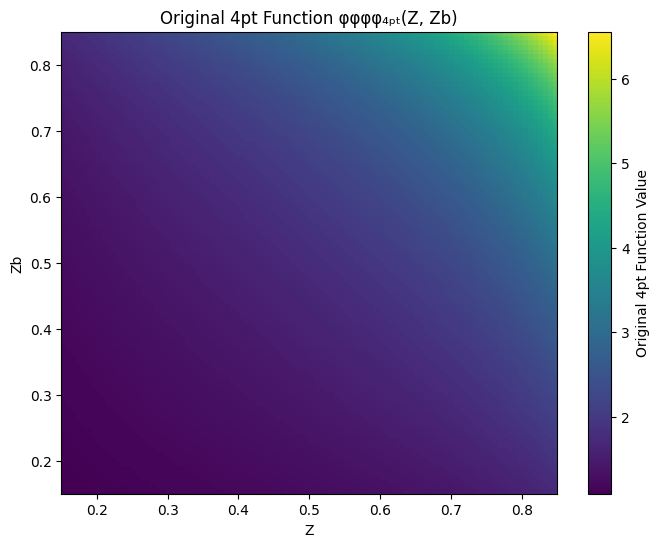

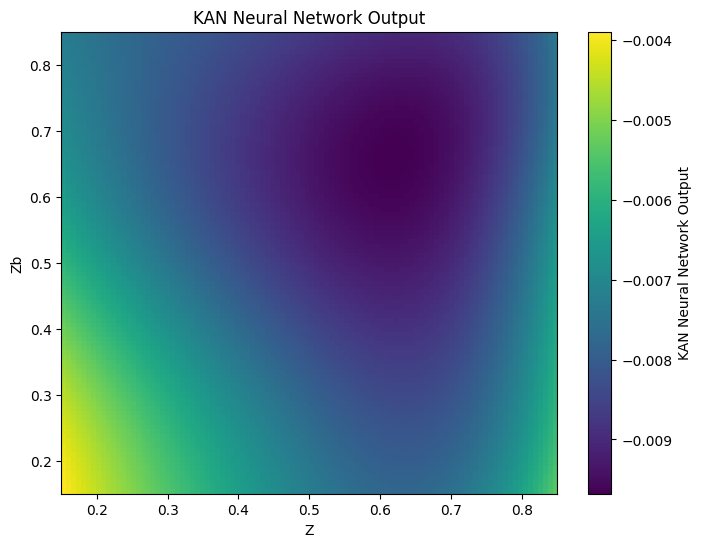

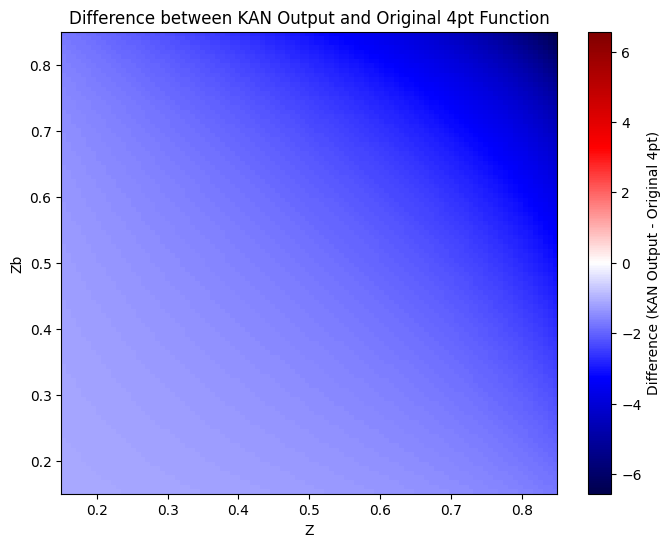

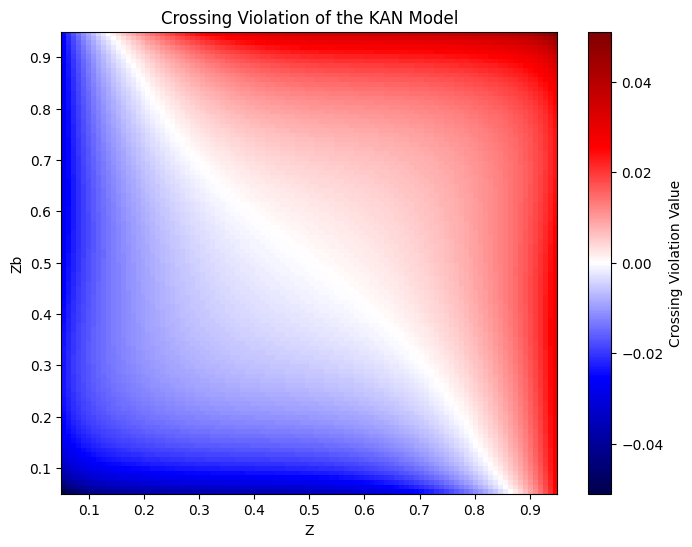

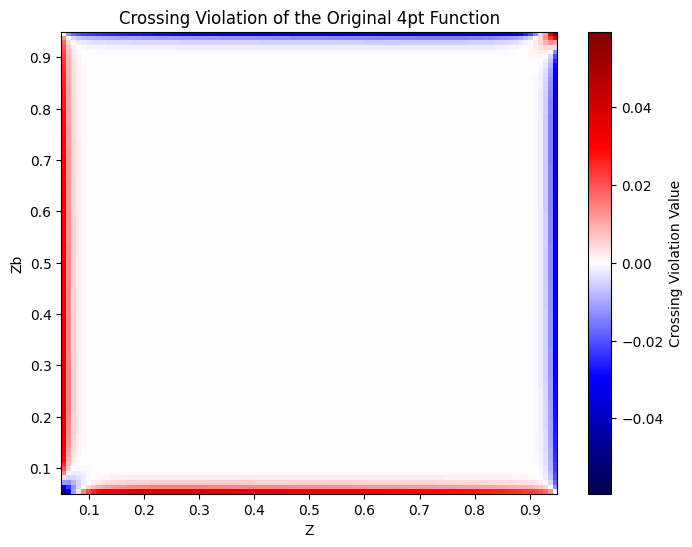

Mean Squared Error on unseen data: 4.049840e+00


4.049840450286865

In [86]:
plot_results(model, phi4pt_func, device)
plot_crossing_violation(model, phi4pt_func, Delta_phi, device)
evaluate_model(model, phi4pt_func, device, num_points=1000)

Step 999, Total Loss: 5.7269e+00, Cand Loss: 5.6456e+00, Cross Loss: 8.1371e-02: 100%|█| 1000/1000 [


saving model version 0.2


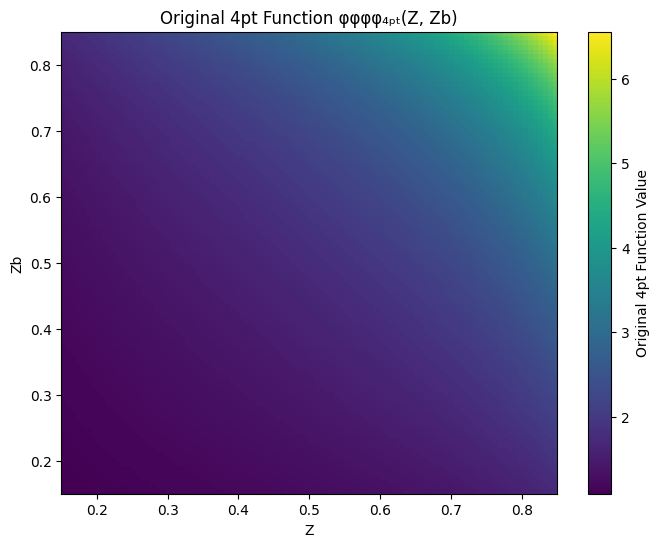

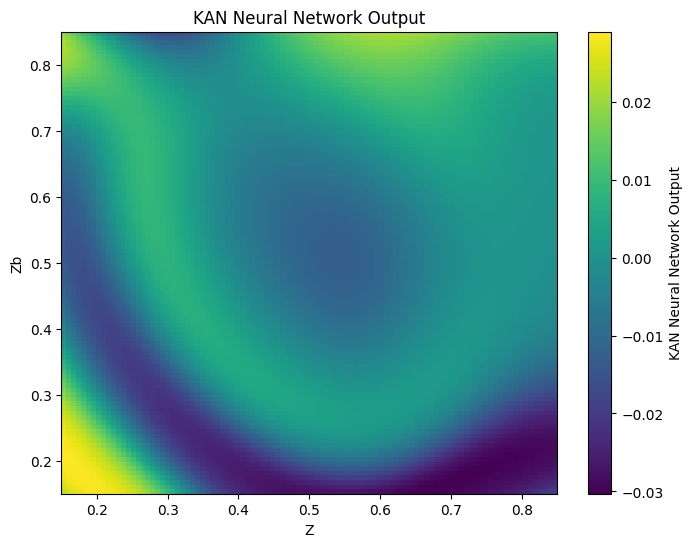

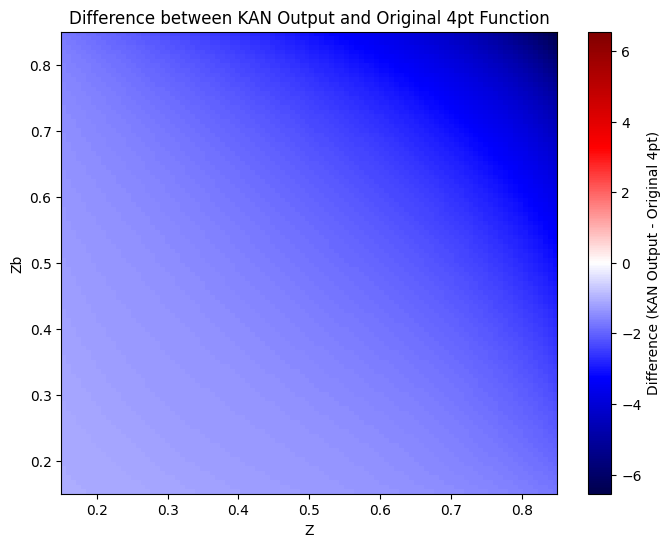

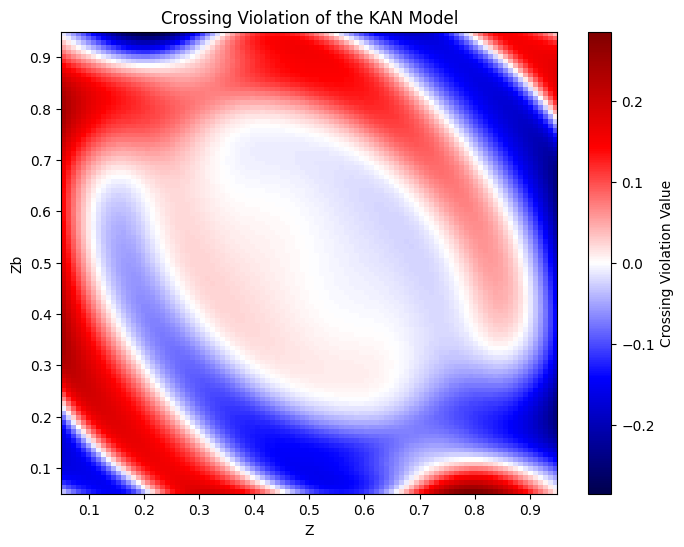

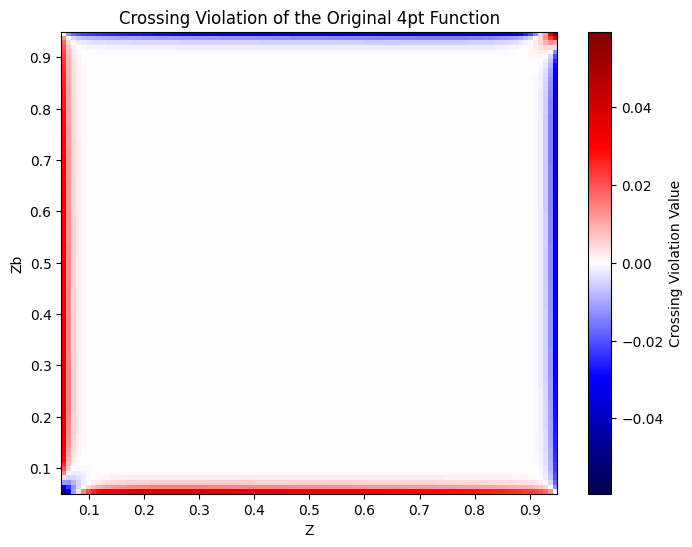

In [31]:
model.fit_with_crossing(
    dataset,
    Delta_phi=Delta_phi,
    steps=1000,
    lamb_cand=1.0,
    lamb_cross=1.0,
    lr=0.01,
    batch=64,
    opt='Adam'
)
plot_results(model, phi4pt_func, device)
plot_crossing_violation(model, phi4pt_func, Delta_phi, device)

In [33]:
def fit_with_crossing_prod(
    self,
    Delta_phi,
    opt="LBFGS",
    steps=100,
    log=1,
    lamb_cross=1.0,
    lamb_inner=1.0,
    lr=1.0,
    batch_size=1024,
    edge_bounds=((0.0, 0.1), (0.9, 1.0)),
    **kwargs
):
    """
    Custom fit method that trains the model using the specified loss function.

    Args:
        Delta_phi: float, the hyperparameter in the crossing equation.
        opt: str, optimizer to use ("LBFGS" or "Adam").
        steps: int, number of training steps.
        log: int, logging frequency.
        lamb_cross: float, weighting factor for the crossing equation loss.
        lamb_inner: float, weighting factor for the inner region loss.
        lr: float, learning rate.
        batch_size: int, batch size for sampling.
        edge_bounds: tuple, bounds defining the edge regions.
        **kwargs: additional arguments.

    Returns:
        results: dict, containing training losses and other metrics.
    """
    import torch
    from tqdm import tqdm

    device = self.device

    # Crossing equation function
    def crossing_equation(Z, Zb, phi_func, Delta_phi):
        term1 = (Z * Zb) ** (-Delta_phi) * phi_func(Z, Zb)
        term2 = ((1 - Z) * (1 - Zb)) ** (-Delta_phi) * phi_func(1 - Z, 1 - Zb)
        return term1 - term2

    # Function to sample from the domain
    def sample_domain(num_samples):
        x = torch.rand(num_samples, 2, device=device)
        return x

    # Optimizer setup
    if opt == "Adam":
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = torch.optim.LBFGS(self.parameters(), lr=lr, max_iter=20)
    else:
        raise ValueError("Optimizer not recognized.")

    # Training loop
    results = {'total_loss': [], 'cross_loss': [], 'inner_loss': []}
    pbar = tqdm(range(steps), desc='Training', ncols=100)

    for step in pbar:
        def closure():
            optimizer.zero_grad()

            # Sample data
            num_samples = batch_size

            # Sample from the domain
            x = sample_domain(num_samples)
            Z = x[:, 0]
            Zb = x[:, 1]

            # Identify edge and inner samples
            edge_mask = (
                (Z >= edge_bounds[0][0]) & (Z <= edge_bounds[0][1]) |
                (Z >= edge_bounds[1][0]) & (Z <= edge_bounds[1][1]) |
                (Zb >= edge_bounds[0][0]) & (Zb <= edge_bounds[0][1]) |
                (Zb >= edge_bounds[1][0]) & (Zb <= edge_bounds[1][1])
            )

            inner_mask = ~edge_mask

            # Define phi_func as the neural network approximation
            def phi_func(Z, Zb):
                inputs = torch.stack((Z, Zb), dim=1)
                return self.forward(inputs).squeeze()

            # Crossing loss (edge regions)
            if edge_mask.any():
                Z_edge = Z[edge_mask]
                Zb_edge = Zb[edge_mask]
                cross_residual = crossing_equation(Z_edge, Zb_edge, phi_func, Delta_phi)
                cross_loss = torch.mean(cross_residual ** 2)
            else:
                cross_loss = torch.tensor(0.0, device=device)

            # Inner loss (deviation from 1)
            if inner_mask.any():
                Z_inner = Z[inner_mask]
                Zb_inner = Zb[inner_mask]
                inputs_inner = torch.stack((Z_inner, Zb_inner), dim=1)
                pred_inner = self.forward(inputs_inner).squeeze()
                inner_loss = torch.mean((pred_inner - 1) ** 2)
            else:
                inner_loss = torch.tensor(0.0, device=device)

            # Total loss
            total_loss = lamb_cross * cross_loss + lamb_inner * inner_loss

            total_loss.backward()
            return total_loss

        optimizer.step(closure)

        # Compute losses after optimizer step
        with torch.no_grad():
            num_samples = batch_size

            # Sample from the domain
            x = sample_domain(num_samples)
            Z = x[:, 0]
            Zb = x[:, 1]

            # Identify edge and inner samples
            edge_mask = (
                (Z >= edge_bounds[0][0]) & (Z <= edge_bounds[0][1]) |
                (Z >= edge_bounds[1][0]) & (Z <= edge_bounds[1][1]) |
                (Zb >= edge_bounds[0][0]) & (Zb <= edge_bounds[0][1]) |
                (Zb >= edge_bounds[1][0]) & (Zb <= edge_bounds[1][1])
            )

            inner_mask = ~edge_mask

            # Define phi_func as the neural network approximation
            def phi_func(Z, Zb):
                inputs = torch.stack((Z, Zb), dim=1)
                return self.forward(inputs).squeeze()

            # Crossing loss (edge regions)
            if edge_mask.any():
                Z_edge = Z[edge_mask]
                Zb_edge = Zb[edge_mask]
                cross_residual = crossing_equation(Z_edge, Zb_edge, phi_func, Delta_phi)
                cross_loss_val = torch.mean(cross_residual ** 2).item()
            else:
                cross_loss_val = 0.0

            # Inner loss (deviation from 1)
            if inner_mask.any():
                Z_inner = Z[inner_mask]
                Zb_inner = Zb[inner_mask]
                inputs_inner = torch.stack((Z_inner, Zb_inner), dim=1)
                pred_inner = self.forward(inputs_inner).squeeze()
                inner_loss_val = torch.mean((pred_inner - 1) ** 2).item()
            else:
                inner_loss_val = 0.0

            # Total loss
            total_loss_val = lamb_cross * cross_loss_val + lamb_inner * inner_loss_val

            results['total_loss'].append(total_loss_val)
            results['cross_loss'].append(cross_loss_val)
            results['inner_loss'].append(inner_loss_val)

            # Update progress bar description
            pbar.set_description(
                f"Step {step}, Total Loss: {total_loss_val:.4e}, Cross Loss: {cross_loss_val:.4e}, Inner Loss: {inner_loss_val:.4e}"
            )

    self.log_history('fit_with_crossing')

    return results
KAN.fit_with_crossing_prod=fit_with_crossing_prod

In [34]:
# Instantiate your KAN model
model = KAN(width=[2, 10,10, 1], grid=5, k=3, seed=0)

# Define Delta_phi hyperparameter
Delta_phi = 0.5  # Set this to your desired value

# Train the model with the custom loss
results = model.fit_with_crossing_prod(
    Delta_phi=Delta_phi,
    steps=1000,
    lamb_cross=1.0,
    lamb_inner=1.0,
    lr=0.01,
    batch_size=1024,
    opt='Adam',
    log=1
)


checkpoint directory created: ./model
saving model version 0.0


Step 999, Total Loss: 4.3978e-01, Cross Loss: 4.0967e-02, Inner Loss: 3.9882e-01: 100%|█| 1000/1000 

saving model version 0.1


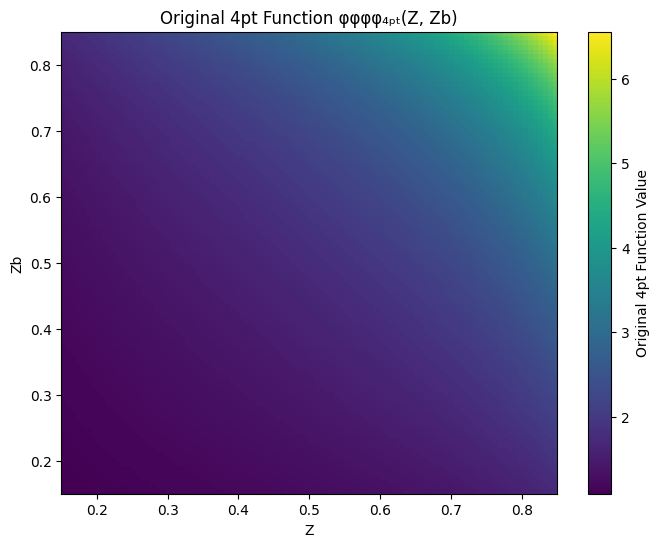

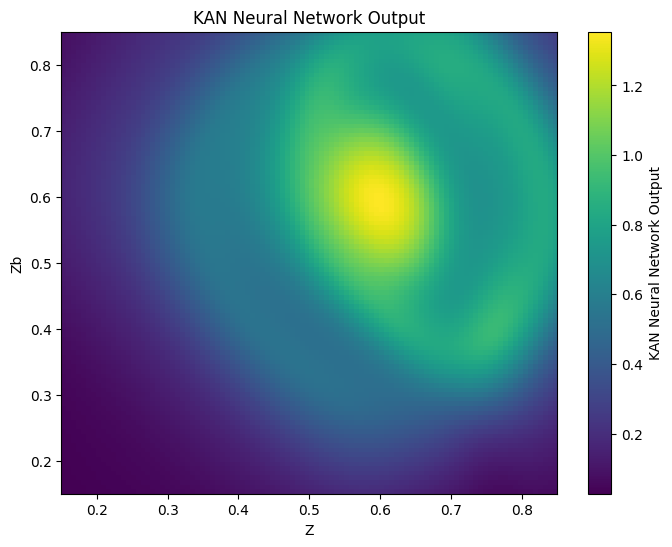

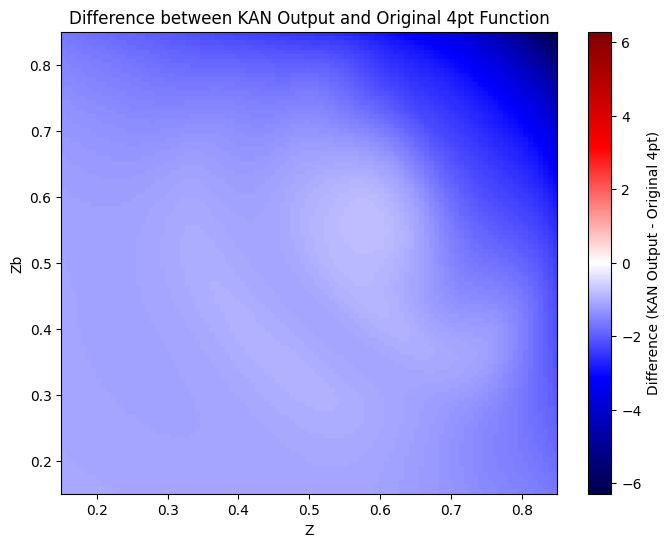

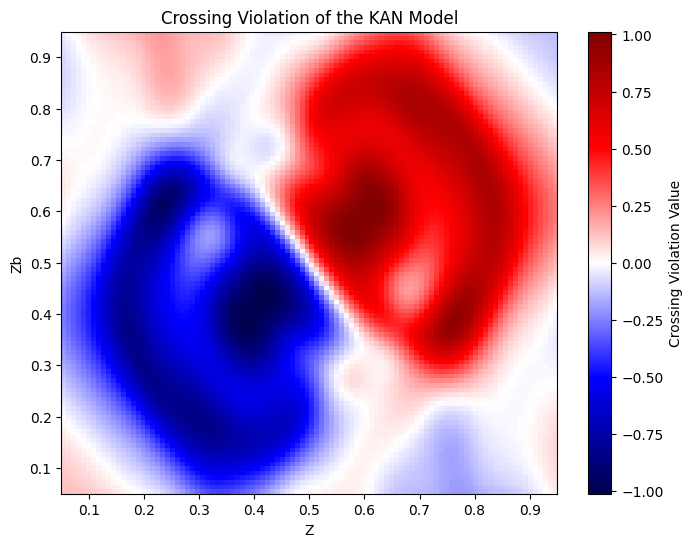

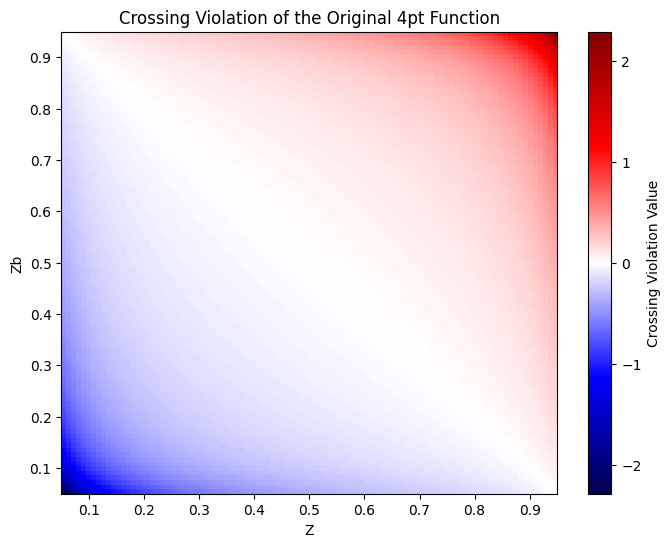

In [35]:
plot_results(model, phi4pt_func, device)
plot_crossing_violation(model, phi4pt_func, Delta_phi, device)

In [5]:
dataset

{'train_input': tensor([[0.4978, 0.6664],
         [0.6609, 0.5537],
         [0.2531, 0.5458],
         ...,
         [0.4035, 0.3630],
         [0.5011, 0.3810],
         [0.4423, 0.2487]]),
 'test_input': tensor([[0.4745, 0.4275],
         [0.2660, 0.4710],
         [0.4982, 0.3617],
         ...,
         [0.5118, 0.4117],
         [0.4089, 0.4724],
         [0.7260, 0.7654]]),
 'train_label': tensor([[2.1472],
         [2.2912],
         [1.4407],
         [1.6290],
         [1.9183],
         [1.6877],
         [1.7003],
         [2.9230],
         [1.5013],
         [2.9352],
         [1.3606],
         [1.9321],
         [1.1938],
         [1.5799],
         [1.9572],
         [1.8601],
         [1.9512],
         [2.9059],
         [1.2569],
         [1.3283],
         [1.4992],
         [1.9122],
         [1.6746],
         [1.9673],
         [1.8025],
         [1.8491],
         [3.9260],
         [1.2552],
         [1.3872],
         [2.0465],
         [1.4791],
         [4

In [6]:
def create_dataset_gauss(f, 
                   n_var=2, 
                   f_mode='col',
                   ranges=[0,1],   # now interpreted as mean and std if 1D or array of [mean, std] pairs if 2D
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=False,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset with Gaussian sampling
    
    Args:
    -----
        f : function
            The symbolic formula used to create the synthetic dataset.
        n_var : int
            The number of variables. Default: 2.
        f_mode : str
            Mode to apply the function: 'col' or 'row'.
            'col' means f expects inputs of shape [N, n_var].
            'row' means f expects inputs of shape [n_var, N].
        ranges : list or np.array; shape (2,) or (n_var, 2)
            The mean and std for each variable. If shape is (2,), it will
            be expanded to all variables. Example:
            ranges = [mean, std]
            or
            ranges = [[mean_1,std_1], [mean_2,std_2], ...].
        train_num : int
            The number of training samples. Default: 1000.
        test_num : int
            The number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            Device for the returned tensors. Default: 'cpu'.
        seed : int
            Random seed. Default: 0.
        
    Returns:
    --------
        dataset : dict
            Dictionary containing:
                - 'train_input': torch.Tensor of shape [train_num, n_var]
                - 'train_label': torch.Tensor of shape [train_num, output_dim]
                - 'test_input': torch.Tensor of shape [test_num, n_var]
                - 'test_label': torch.Tensor of shape [test_num, output_dim]
    
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, ranges=[0, 1], train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    # Ensure that ranges is an array
    ranges = np.array(ranges)
    if ranges.ndim == 1:
        # If only one pair of mean/std is given, use it for all variables
        ranges = np.tile(ranges, (n_var,1))
    
    # Check shape correctness
    assert ranges.shape == (n_var, 2), "ranges should have shape (n_var, 2) representing mean and std for each variable."

    # Create train and test input tensors
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)

    # Sample each variable from a Gaussian distribution with given mean/std
    for i in range(n_var):
        mean_i = ranges[i,0]
        std_i = ranges[i,1]
        train_input[:, i] = torch.randn(train_num)*std_i + mean_i
        test_input[:, i] = torch.randn(test_num)*std_i + mean_i

    # Evaluate function on training/testing sets
    if f_mode == 'col':
        train_label = f(train_input)
        test_label = f(test_input)
    elif f_mode == 'row':
        train_label = f(train_input.T)
        test_label = f(test_input.T)
    else:
        raise ValueError(f'f_mode {f_mode} not recognized. Use "col" or "row".')
        
    # If labels are 1D, unsqueeze
    if len(train_label.shape) == 1:
        train_label = train_label.unsqueeze(dim=1)
    if len(test_label.shape) == 1:
        test_label = test_label.unsqueeze(dim=1)

    def normalize(data, mean, std):
        return (data - mean) / (std + 1e-12)

    if normalize_input:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
        
    if normalize_label:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = {
        'train_input': train_input.to(device),
        'train_label': train_label.to(device),
        'test_input': test_input.to(device),
        'test_label': test_label.to(device)
    }

    return dataset


In [11]:
modelTest = KAN(width=[2,5,5,1], device=device).to(device)
f = lambda x:  phi4pt_func(x[:,0] , x[:,1])
dataset = create_dataset_gauss(f, n_var=2, device=device,ranges=[[.5,.1],[.5,.1]])
modelTest.fit(dataset, steps=100, lamb=0.001);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.01e-02 | test_loss: 2.11e-02 | reg: 6.02e+00 | : 100%|█| 100/100 [00:44<00:00,  2.25

saving model version 0.1


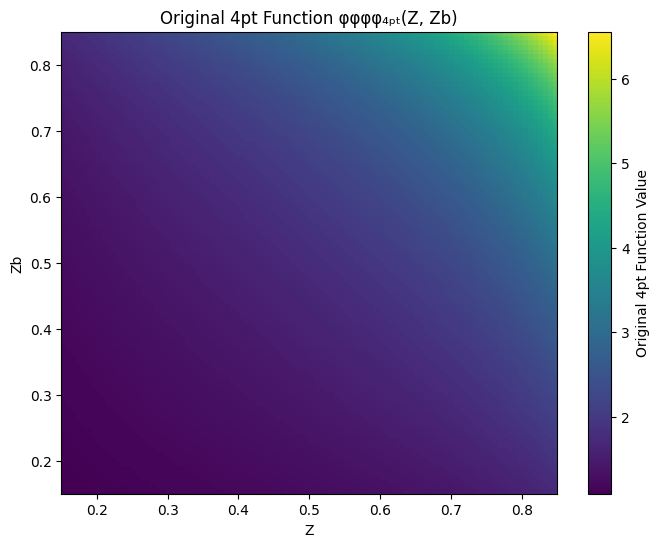

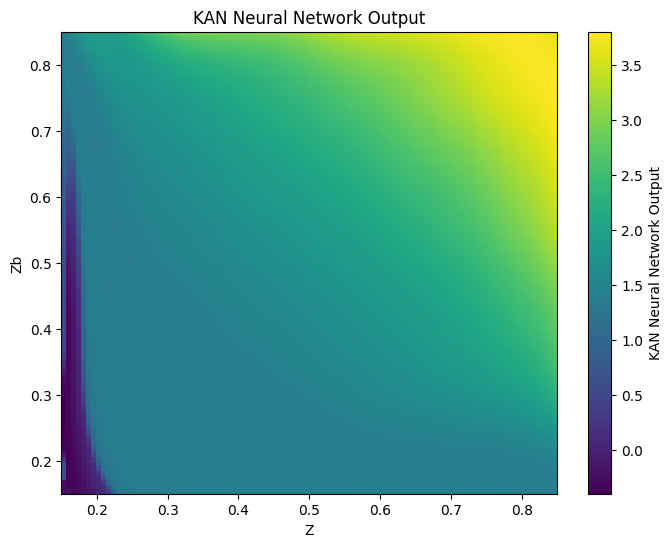

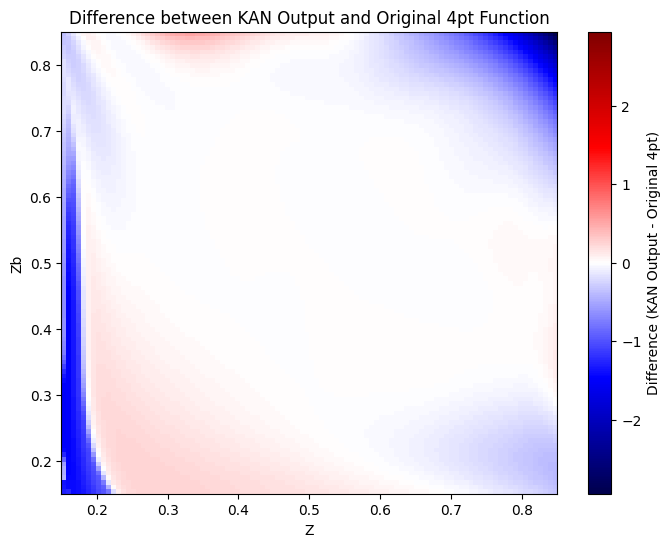

AttributeError: 'numpy.ndarray' object has no attribute 'clamp'

In [12]:
plot_results(modelTest, phi4pt_func, device)
plot_crossing_violation(modelTest, phi4pt_func, Delta_phi, device)


good config

In [256]:
modelTest = KAN(width=[2,[6,2],1], grid=10, k=3,  seed=1, device=device).to(device)
f = lambda x:  phi4pt_func(x[:,0] , x[:,1])
dataset = create_dataset(f, n_var=2, device=device,ranges=[.15,.85])
modelTest.fit(dataset, steps=100);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-04 | test_loss: 3.05e-04 | reg: 2.43e+01 | : 100%|█| 100/100 [00:34<00:00,  2.86

saving model version 0.1


In [270]:
modelTest.fit(dataset, steps=100);

| train_loss: 2.39e-04 | test_loss: 7.29e-04 | reg: 2.18e+01 | : 100%|█| 100/100 [00:39<00:00,  2.51

saving model version 0.2


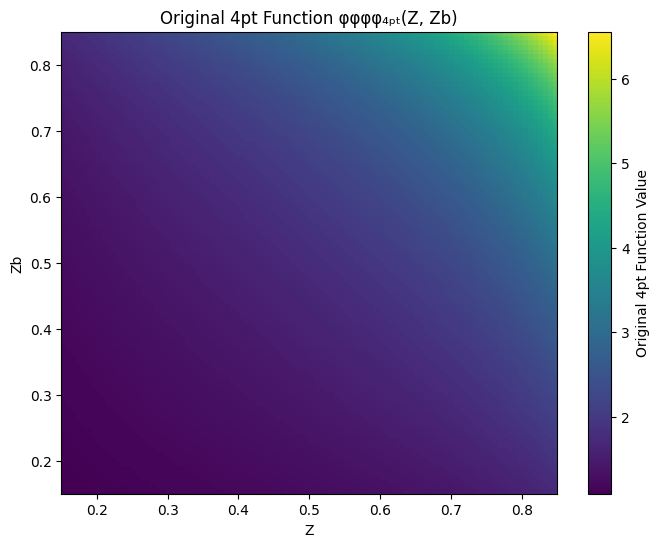

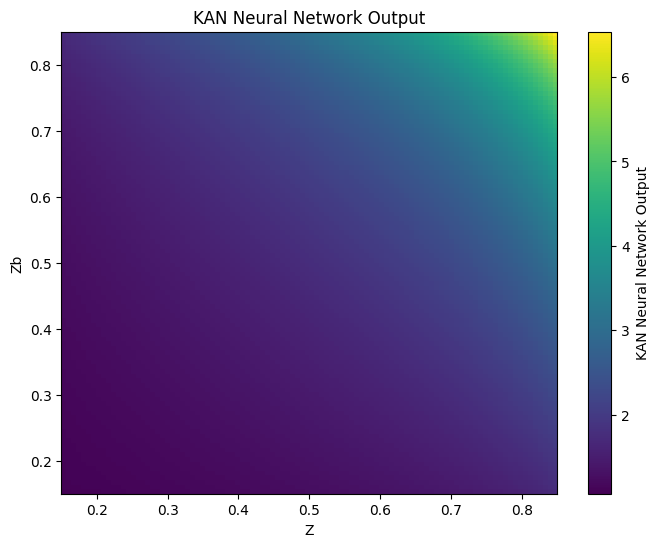

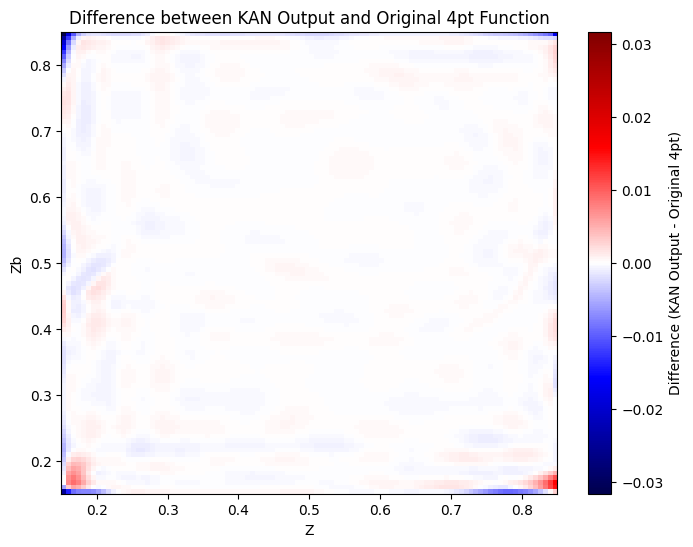

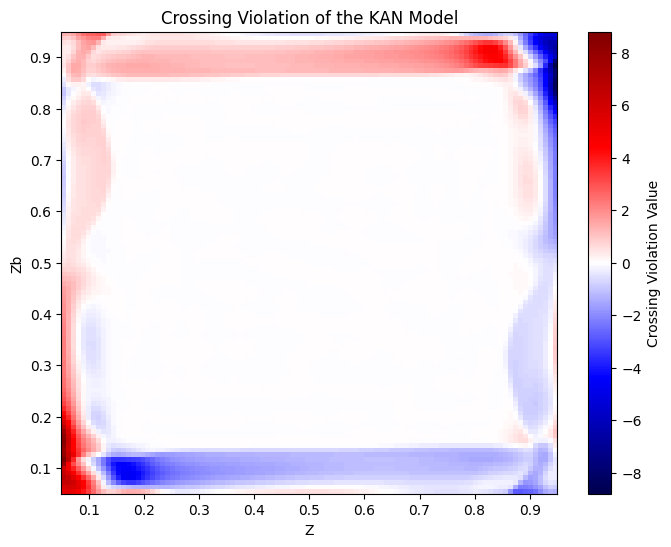

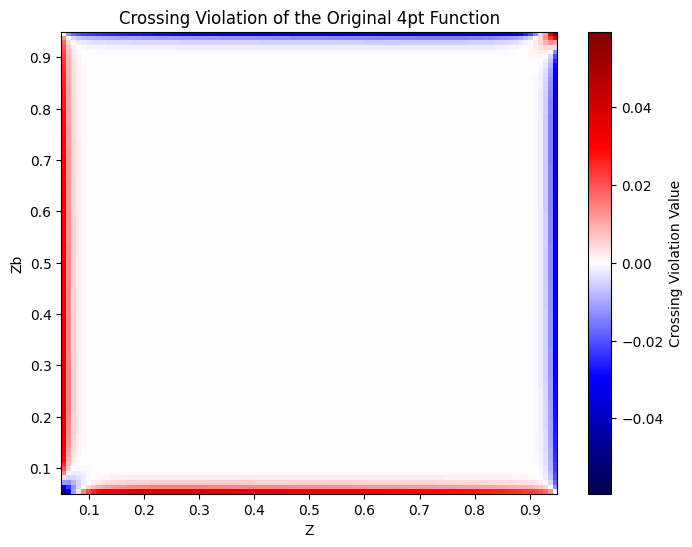

Mean Squared Error on unseen data: 6.656470e-08


6.656470219468247e-08

In [271]:
plot_results(modelTest, phi4pt_func, device)
plot_crossing_violation(modelTest, phi4pt_func, Delta_phi, device)
evaluate_model(modelTest, phi4pt_func, device, num_points=1000)

Training:   4%|▍         | 4/100 [00:00<00:06, 14.00it/s]

Epoch 0: Total Loss = 47.037086, Loss A = 0.000000, Loss B = 47.037086


Training:  12%|█▏        | 12/100 [00:00<00:06, 14.32it/s]

Epoch 10: Total Loss = 21.942488, Loss A = 0.051557, Loss B = 21.942488


Training:  22%|██▏       | 22/100 [00:01<00:06, 12.79it/s]

Epoch 20: Total Loss = 10.122272, Loss A = 0.152083, Loss B = 10.122272


Training:  32%|███▏      | 32/100 [00:02<00:05, 11.39it/s]

Epoch 30: Total Loss = 5.253950, Loss A = 0.245323, Loss B = 5.253950


Training:  42%|████▏     | 42/100 [00:03<00:04, 12.83it/s]

Epoch 40: Total Loss = 3.472399, Loss A = 0.336339, Loss B = 3.472399


Training:  52%|█████▏    | 52/100 [00:04<00:03, 13.78it/s]

Epoch 50: Total Loss = 2.611670, Loss A = 0.409144, Loss B = 2.611670


Training:  62%|██████▏   | 62/100 [00:04<00:02, 13.13it/s]

Epoch 60: Total Loss = 1.949213, Loss A = 0.431751, Loss B = 1.949213


Training:  72%|███████▏  | 72/100 [00:05<00:02, 13.58it/s]

Epoch 70: Total Loss = 1.473167, Loss A = 0.419431, Loss B = 1.473167


Training:  82%|████████▏ | 82/100 [00:06<00:01, 13.95it/s]

Epoch 80: Total Loss = 1.163778, Loss A = 0.418768, Loss B = 1.163778


Training:  92%|█████████▏| 92/100 [00:07<00:00, 13.81it/s]

Epoch 90: Total Loss = 0.942587, Loss A = 0.440141, Loss B = 0.942587


Training: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


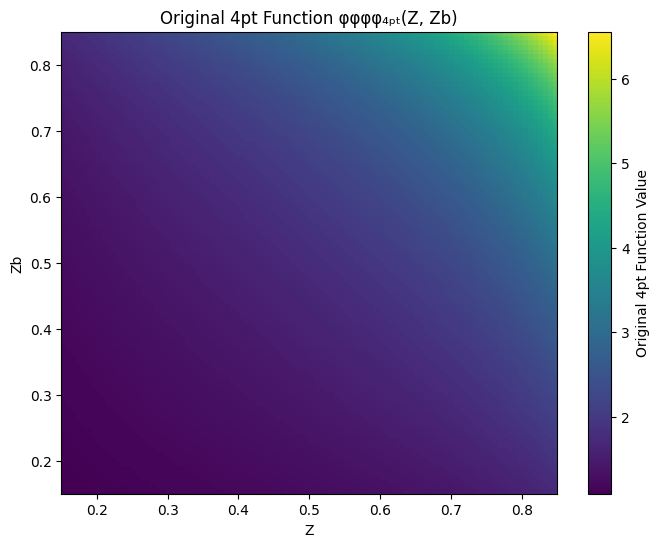

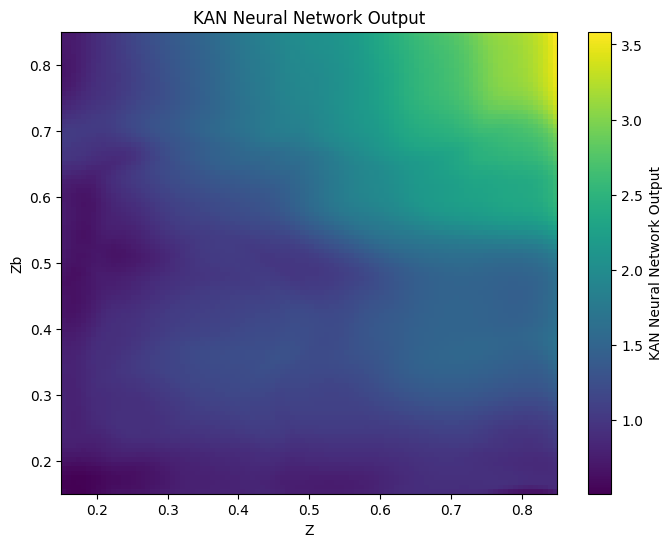

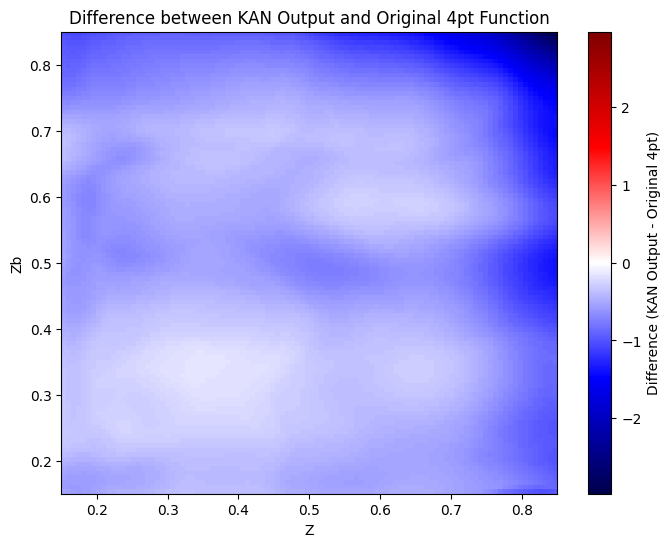

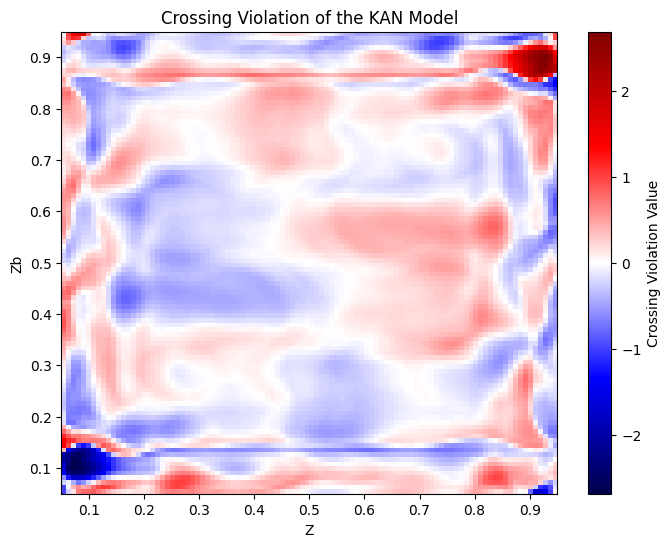

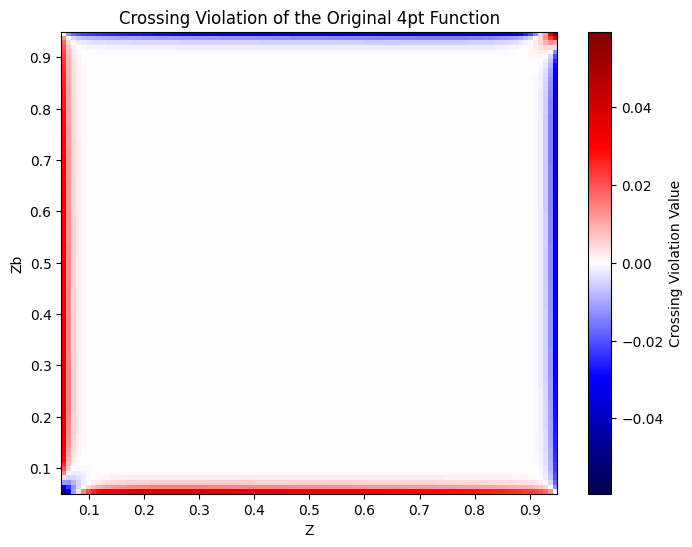

Mean Squared Error on unseen data: 2.666957e-01


0.2666957378387451

In [272]:
_, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=modelTest,
        num_epochs=100, weight_a=0.0, weight_b=1.0, device=device
    )



    # Plot results
plot_results(modelTest, phi4pt_func, device)
plot_crossing_violation(modelTest, phi4pt_func, Delta_phi, device)
evaluate_model(modelTest, phi4pt_func, device, num_points=1000)

In [255]:
modelTest = KAN(width=[2,[2,2],[2,2],1], grid=10, k=3,  seed=1, device=device).to(device)
f = lambda x:  phi4pt_func(x[:,0] , x[:,1])
dataset = create_dataset(f, n_var=2, device=device,ranges=[.15,.85])
modelTest.fit(dataset, steps=100);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.27e-01 | test_loss: 3.39e-01 | reg: 3.69e+01 | : 100%|█| 100/100 [00:43<00:00,  2.32

saving model version 0.1


In [249]:
modelTest.refine(20)

saving model version 0.2


MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [250]:
modelTest.fit(dataset, steps=100);

| train_loss: 1.26e-04 | test_loss: 2.72e-04 | reg: 2.43e+01 | : 100%|█| 100/100 [00:22<00:00,  4.44

saving model version 0.3


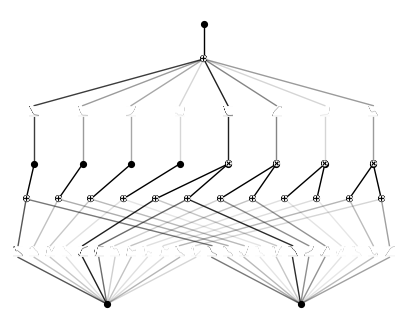

In [252]:
modelTest.plot()

saving model version 0.2


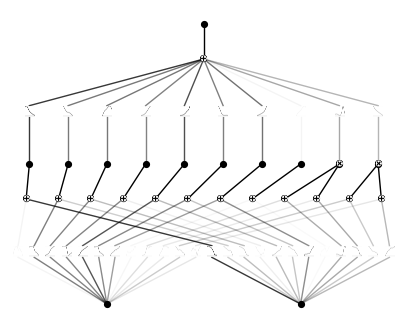

In [237]:
modelTest.prune()
modelTest.plot()

In [ ]:
modelTest.auto_symbolic()

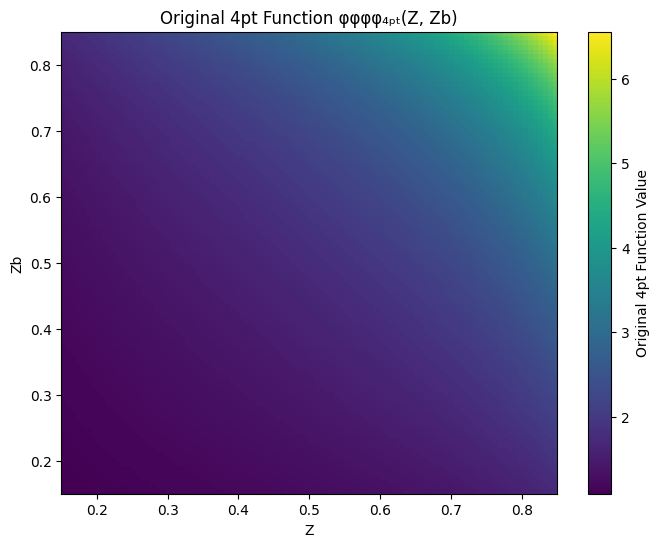

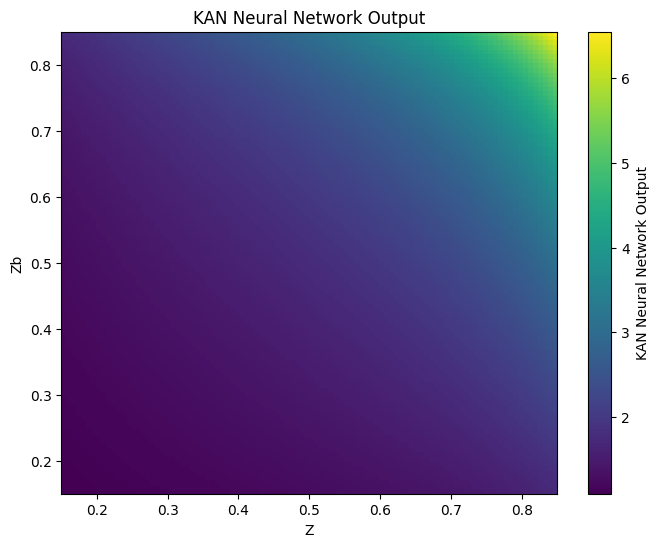

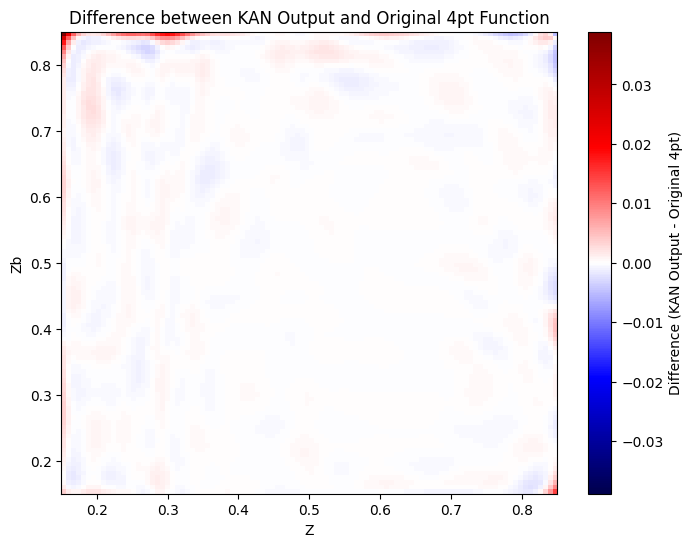

In [253]:
plot_results(modelTest, phi4pt_func, device)


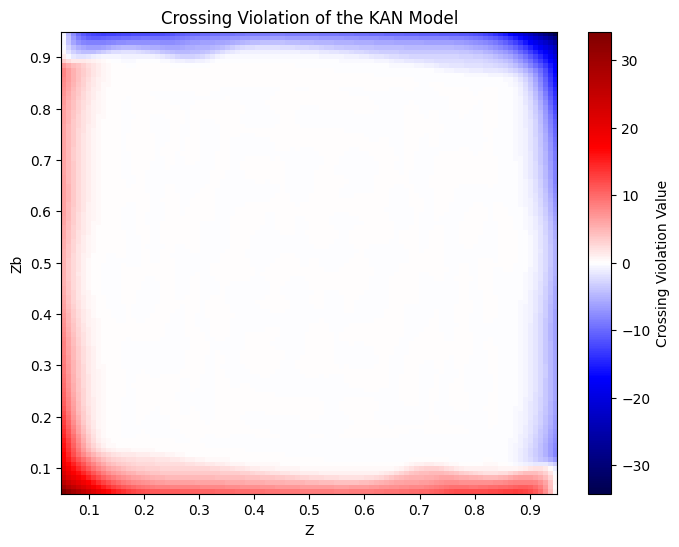

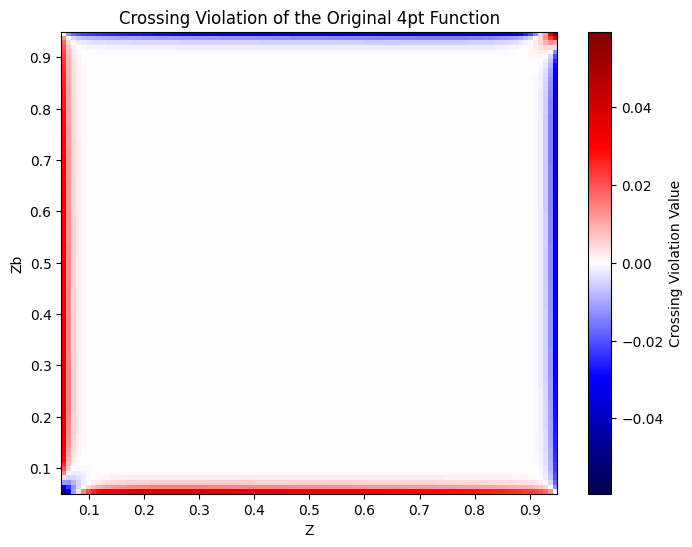

In [254]:
plot_crossing_violation(modelTest, phi4pt_func, Delta_phi, device)

測試

In [121]:
modelMult = KAN(width=[2,[5,2],1], base_fun='identity', device=device)
modelMult.fit(dataset, steps=100, lamb=0.001);


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.47e-03 | test_loss: 6.56e-03 | reg: 5.21e+00 | : 100%|█| 100/100 [00:39<00:00,  2.55

saving model version 0.1


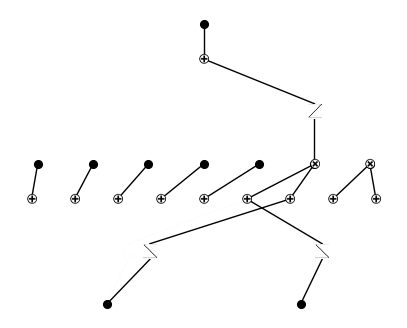

In [123]:
modelMult.plot()


saving model version 0.2


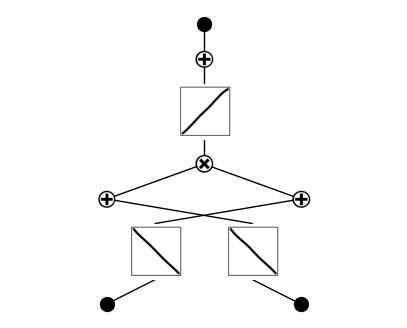

In [125]:
modelMult=modelMult.prune()
modelMult.plot()



In [127]:
modelMult.auto_symbolic()

fixing (0,0,0) with 0
fixing (0,0,1) with x, r2=0.9997261762619019, c=1
fixing (0,1,0) with x, r2=0.9995154142379761, c=1
fixing (0,1,1) with 0
fixing (1,0,0) with x, r2=0.99933922290802, c=1
saving model version 0.3


In [128]:
modelMult.symbolic_formula()

([5.17234964619763*(0.000178326230990677 - 0.456105907844705*x_1)*(0.000199863099624054 - 0.4202123912203*x_2) + 0.312738820602192],
 [x_1, x_2])

In [135]:
modelTest = KAN(width=[2,5,1], grid=10, k=3, seed=1, device=device).to(device)
f = lambda x: x[:,0] * x[:,1]
dataset = create_dataset(f, n_var=2, device=device)
modelTest.fit(dataset, steps=50, lamb=0.001);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.65e-03 | test_loss: 7.96e-03 | reg: 6.86e+00 | : 100%|█| 50/50 [00:21<00:00,  2.36it

saving model version 0.1


In [136]:
modelTest=modelTest.prune()
modelTest.auto_symbolic()

saving model version 0.2
fixing (0,0,0) with x, r2=0.9970846176147461, c=1
fixing (0,0,1) with x, r2=0.9990097284317017, c=1
fixing (0,1,0) with x, r2=0.9951648712158203, c=1
fixing (0,1,1) with x, r2=0.9979941844940186, c=1
fixing (1,0,0) with sin, r2=0.9964032769203186, c=2
fixing (1,1,0) with cos, r2=0.9990377426147461, c=2
saving model version 0.3


In [137]:
modelTest.symbolic_formula()

([-0.730313301086426*sin(0.895417697160367*x_1 + 0.87061244935961*x_2 + 1.56541415825363) - 0.908451855182648*cos(-0.808033423954377*x_1 + 0.795244128142917*x_2 + 9.41979643439164) + 0.129109680652618],
 [x_1, x_2])

In [118]:
modelTest.fix_symbolic(0,0,0,'x')
modelTest.fix_symbolic(0,0,1,'x')
modelTest.fix_symbolic(0,1,0,'x')
modelTest.fix_symbolic(0,1,1,'x')
modelTest.fix_symbolic(1,0,0,'x^2')
modelTest.fix_symbolic(1,1,0,'x^2')

r2 is 0.9975054264068604
saving model version 0.3
r2 is 0.9989830255508423
saving model version 0.4
r2 is 0.9960212111473083
saving model version 0.5
r2 is 0.9980931878089905
saving model version 0.6
r2 is 0.9915963411331177
saving model version 0.7
r2 is 0.9957290887832642
saving model version 0.8


tensor(0.9957)

In [119]:
modelTest.fit(dataset, steps=100, lamb=0.001);

| train_loss: 6.22e-08 | test_loss: 5.97e-08 | reg: 0.00e+00 | : 100%|█| 100/100 [00:05<00:00, 17.42


saving model version 0.9


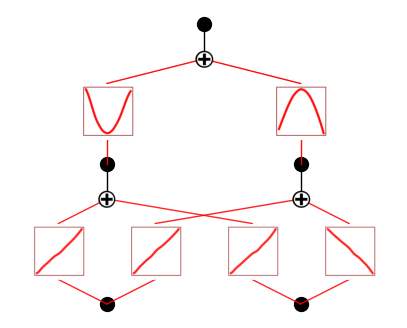

In [138]:
modelTest.plot()


In [120]:
modelTest.symbolic_formula()

([0.255500258193703*(-x_1 - 0.978472578223145*x_2 - 4.66552298858773e-8)**2 - 0.255500253865282*(-x_1 + 0.978472636711715*x_2 - 1.65061866437659e-8)**2],
 [x_1, x_2])

In [116]:
modelTest = modelTest.prune()


saving model version 0.2


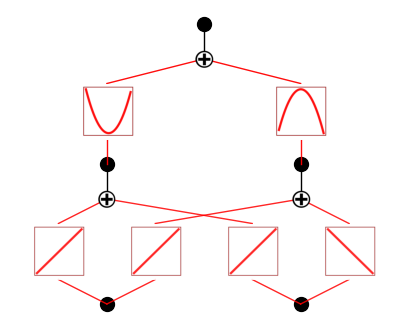

In [122]:
modelTest.plot()


Training:   0%|          | 2/1000 [00:00<02:05,  7.95it/s]

Epoch 0: Total Loss = 4.551290, Loss A = 0.000106, Loss B = 455.118408


Training:  10%|█         | 102/1000 [00:15<02:23,  6.25it/s]

Epoch 100: Total Loss = 0.123390, Loss A = 0.031838, Loss B = 9.155153


Training:  20%|██        | 201/1000 [00:37<03:19,  4.01it/s]

Epoch 200: Total Loss = 0.041396, Loss A = 0.008101, Loss B = 3.329502


Training:  30%|███       | 302/1000 [00:56<01:40,  6.95it/s]

Epoch 300: Total Loss = 0.018747, Loss A = 0.004026, Loss B = 1.472024


Training:  40%|████      | 402/1000 [01:15<01:44,  5.72it/s]

Epoch 400: Total Loss = 0.009212, Loss A = 0.002453, Loss B = 0.675875


Training:  50%|█████     | 502/1000 [01:35<01:19,  6.29it/s]

Epoch 500: Total Loss = 0.005178, Loss A = 0.001737, Loss B = 0.344055


Training:  60%|██████    | 602/1000 [01:51<01:04,  6.15it/s]

Epoch 600: Total Loss = 0.003155, Loss A = 0.001272, Loss B = 0.188223


Training:  70%|███████   | 702/1000 [02:06<00:58,  5.12it/s]

Epoch 700: Total Loss = 0.001982, Loss A = 0.000924, Loss B = 0.105790


Training:  80%|████████  | 802/1000 [02:22<00:30,  6.41it/s]

Epoch 800: Total Loss = 0.001337, Loss A = 0.000687, Loss B = 0.064995


Training:  90%|█████████ | 902/1000 [02:37<00:14,  6.85it/s]

Epoch 900: Total Loss = 0.000964, Loss A = 0.000538, Loss B = 0.042639


Training: 100%|██████████| 1000/1000 [02:54<00:00,  5.73it/s]


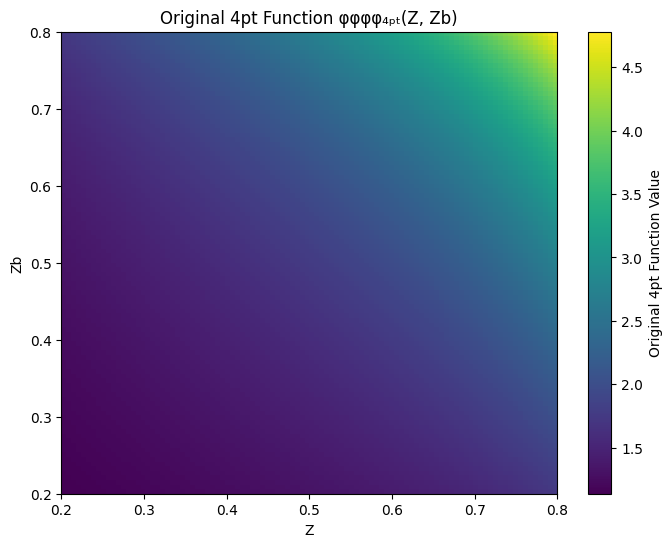

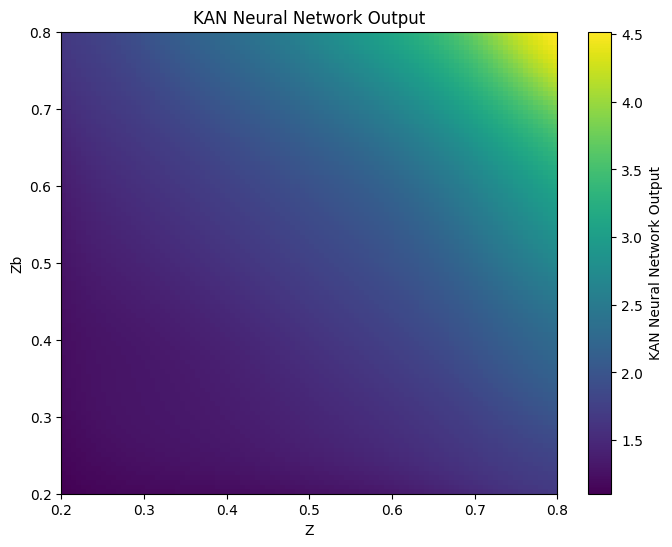

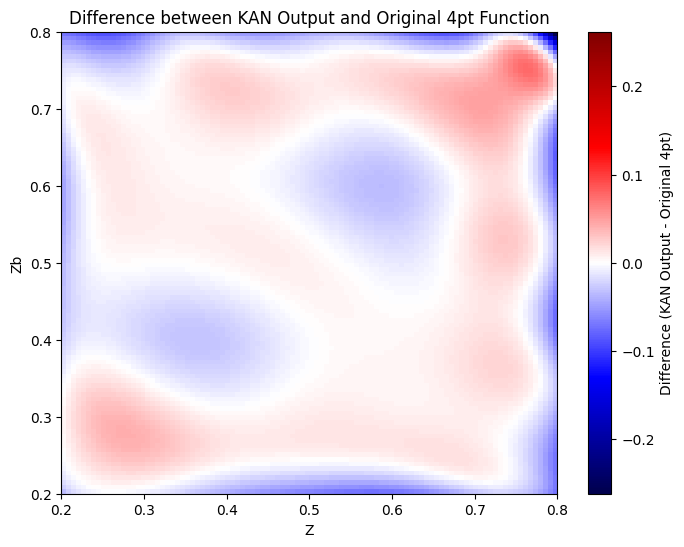

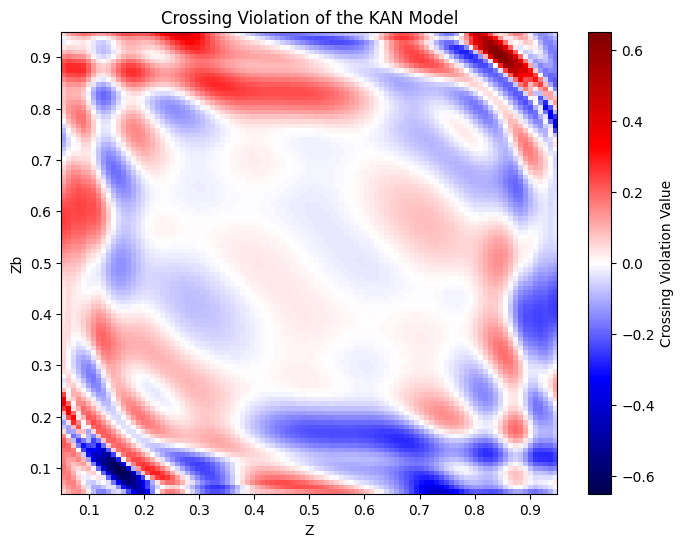

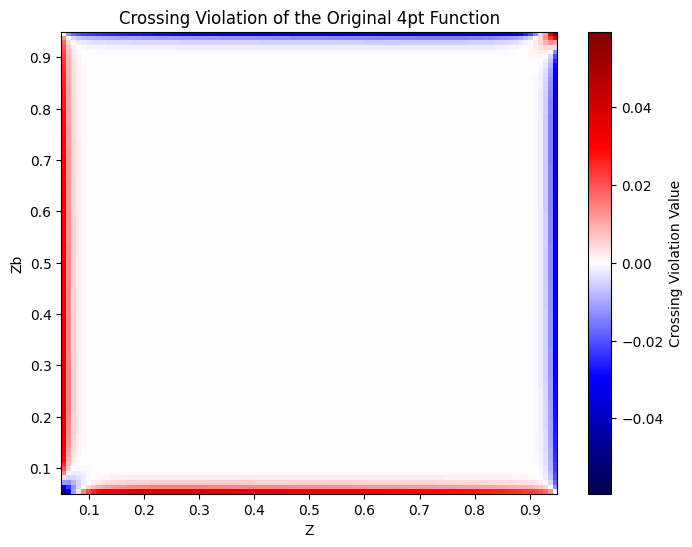

Mean Squared Error on unseen data: 3.748477e-04


0.0003748477029148489

In [53]:
model1, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model0,
        num_epochs=1000, weight_a=1.0, weight_b=0.01, device=device
    )



    # Plot results
plot_results(model1, phi4pt_func, device)
plot_crossing_violation(model1, phi4pt_func, Delta_phi, device)
evaluate_model(model1, phi4pt_func, device, num_points=1000)

Training:   0%|          | 1/1000 [00:00<02:46,  5.99it/s]

Epoch 0: Total Loss = 0.000360, Loss A = 0.000360, Loss B = 0.650377


Training:  10%|█         | 102/1000 [00:16<02:25,  6.18it/s]

Epoch 100: Total Loss = 0.000097, Loss A = 0.000097, Loss B = 14.761539


Training:  20%|██        | 202/1000 [00:32<02:04,  6.43it/s]

Epoch 200: Total Loss = 0.000037, Loss A = 0.000037, Loss B = 38.121487


Training:  30%|███       | 302/1000 [00:48<01:52,  6.21it/s]

Epoch 300: Total Loss = 0.000018, Loss A = 0.000018, Loss B = 62.368496


Training:  40%|████      | 402/1000 [01:04<01:32,  6.44it/s]

Epoch 400: Total Loss = 0.000011, Loss A = 0.000011, Loss B = 83.146416


Training:  50%|█████     | 502/1000 [01:20<01:17,  6.39it/s]

Epoch 500: Total Loss = 0.000007, Loss A = 0.000007, Loss B = 97.877472


Training:  60%|██████    | 602/1000 [01:36<01:01,  6.51it/s]

Epoch 600: Total Loss = 0.000005, Loss A = 0.000005, Loss B = 107.191902


Training:  70%|███████   | 702/1000 [01:52<00:47,  6.22it/s]

Epoch 700: Total Loss = 0.000004, Loss A = 0.000004, Loss B = 113.084389


Training:  80%|████████  | 802/1000 [02:09<00:32,  6.00it/s]

Epoch 800: Total Loss = 0.000003, Loss A = 0.000003, Loss B = 117.227257


Training:  90%|█████████ | 902/1000 [02:25<00:16,  6.02it/s]

Epoch 900: Total Loss = 0.000002, Loss A = 0.000002, Loss B = 120.443893


Training: 100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]


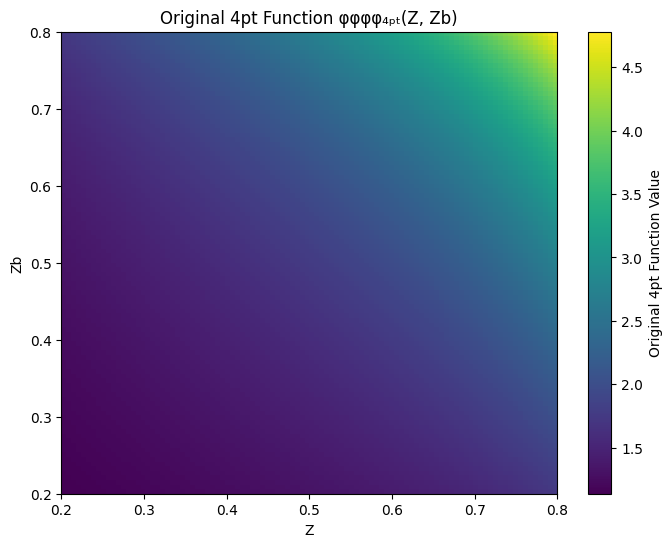

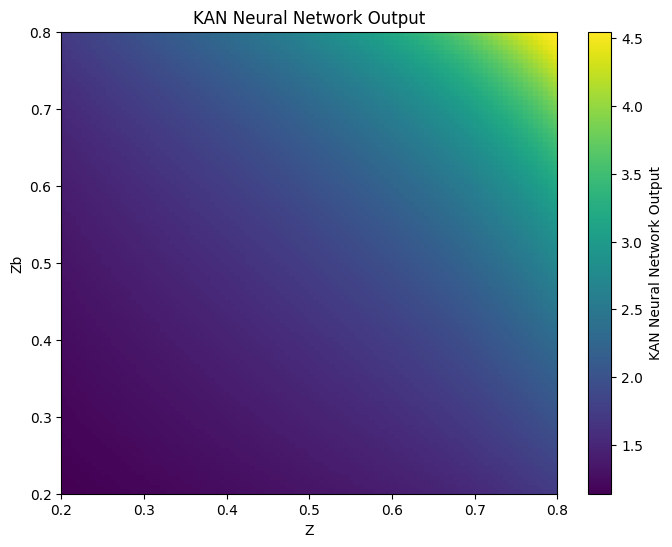

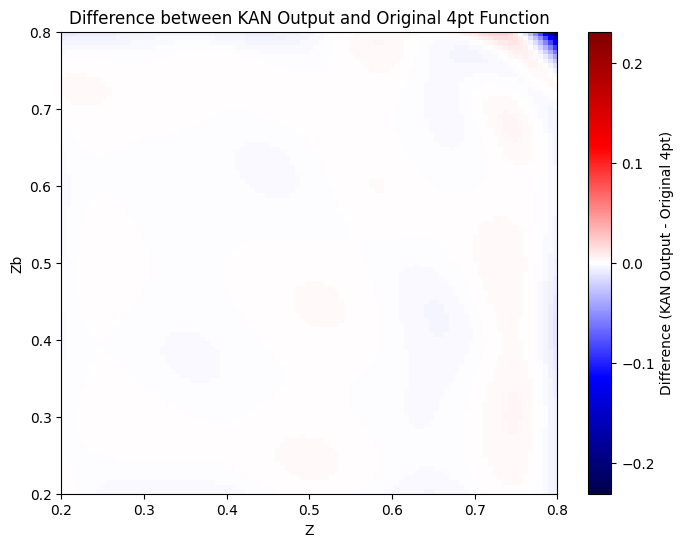

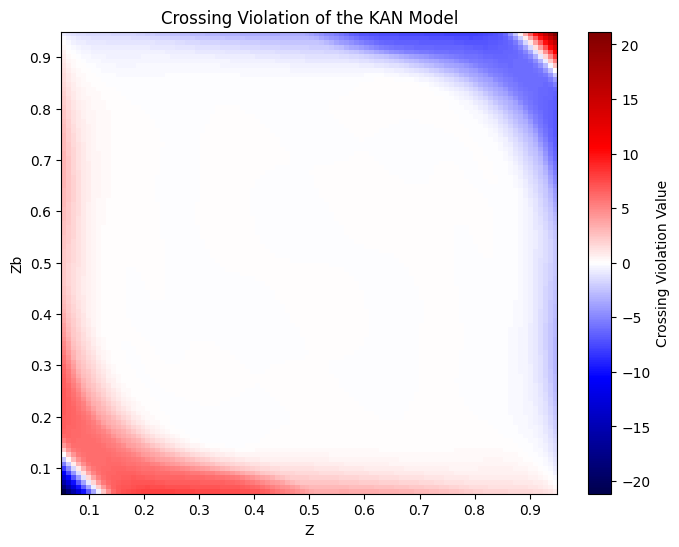

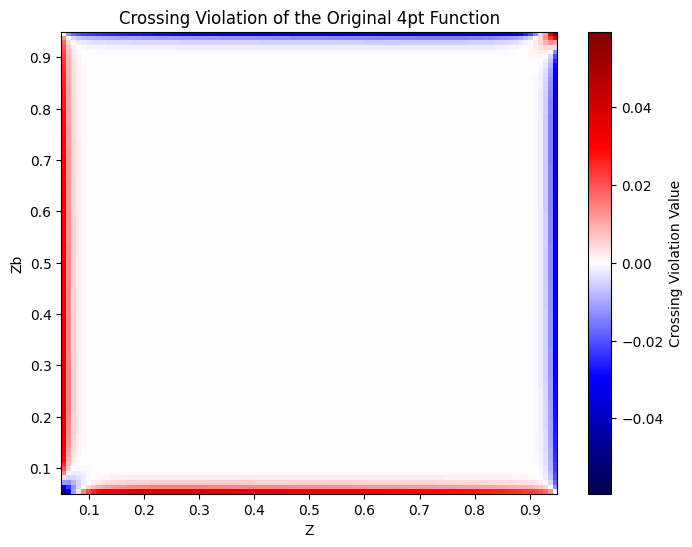

Mean Squared Error on unseen data: 7.153723e-06


7.153722890507197e-06

In [54]:
model2, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model1,
        num_epochs=1000, weight_a=1.0, weight_b=0.0, device=device
    )



    # Plot results
plot_results(model2, phi4pt_func, device)
plot_crossing_violation(model2, phi4pt_func, Delta_phi, device)
evaluate_model(model2, phi4pt_func, device, num_points=1000)

Training:   0%|          | 2/1000 [00:00<02:34,  6.47it/s]

Epoch 0: Total Loss = 0.071213, Loss A = 0.000026, Loss B = 71.186852


Training:  10%|█         | 102/1000 [00:16<02:15,  6.65it/s]

Epoch 100: Total Loss = 0.000493, Loss A = 0.000137, Loss B = 0.356416


Training:  20%|██        | 202/1000 [00:31<02:04,  6.41it/s]

Epoch 200: Total Loss = 0.000223, Loss A = 0.000054, Loss B = 0.169203


Training:  30%|███       | 302/1000 [00:46<01:44,  6.69it/s]

Epoch 300: Total Loss = 0.000126, Loss A = 0.000028, Loss B = 0.097536


Training:  40%|████      | 402/1000 [01:01<01:27,  6.84it/s]

Epoch 400: Total Loss = 0.000089, Loss A = 0.000019, Loss B = 0.070663


Training:  50%|█████     | 502/1000 [01:16<01:14,  6.69it/s]

Epoch 500: Total Loss = 0.000071, Loss A = 0.000015, Loss B = 0.056449


Training:  60%|██████    | 602/1000 [01:31<01:02,  6.39it/s]

Epoch 600: Total Loss = 0.000059, Loss A = 0.000012, Loss B = 0.046523


Training:  70%|███████   | 702/1000 [01:46<00:43,  6.81it/s]

Epoch 700: Total Loss = 0.000050, Loss A = 0.000012, Loss B = 0.038957


Training:  80%|████████  | 802/1000 [02:01<00:29,  6.64it/s]

Epoch 800: Total Loss = 0.000043, Loss A = 0.000010, Loss B = 0.033217


Training:  90%|█████████ | 902/1000 [02:16<00:14,  6.94it/s]

Epoch 900: Total Loss = 0.000068, Loss A = 0.000039, Loss B = 0.028912


Training: 100%|██████████| 1000/1000 [02:30<00:00,  6.63it/s]


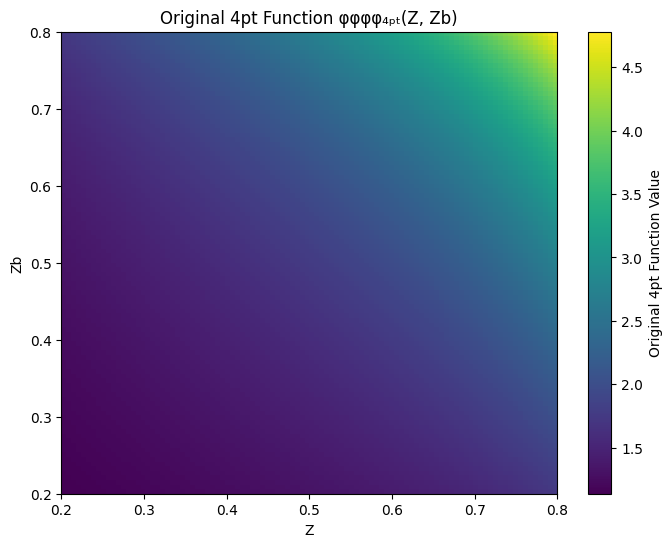

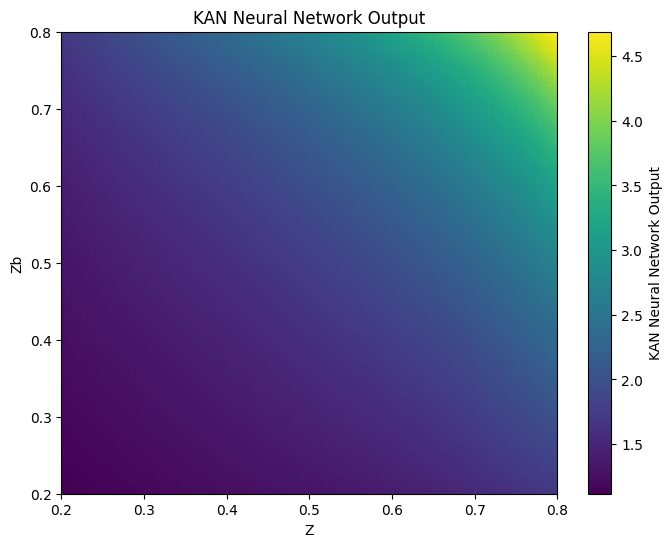

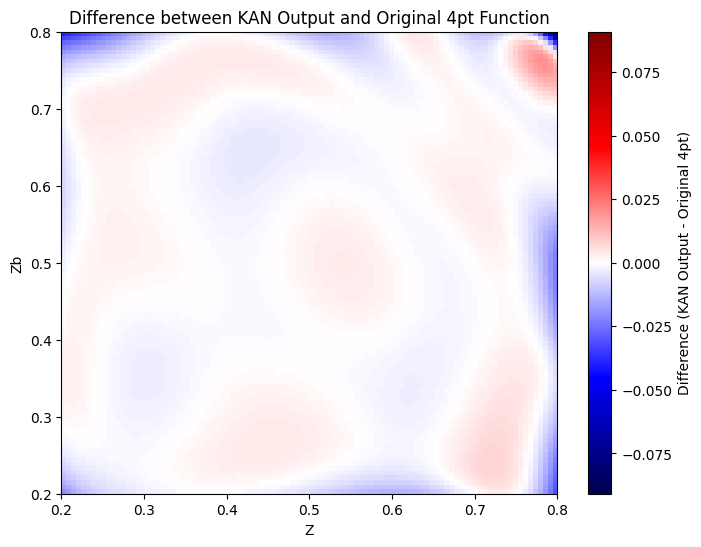

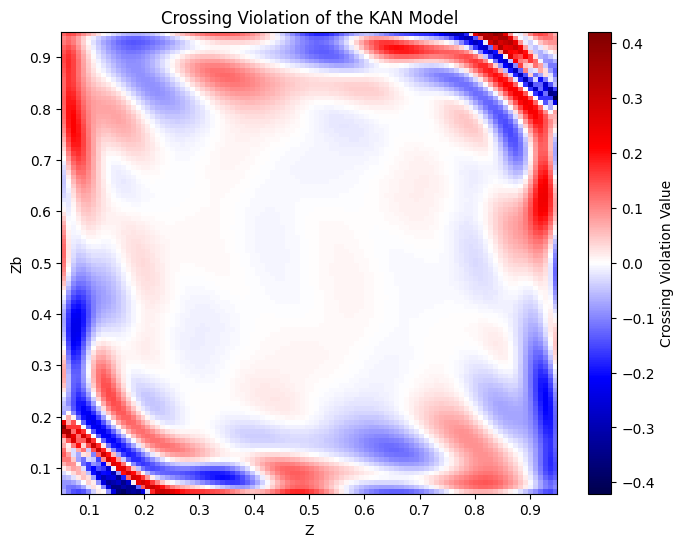

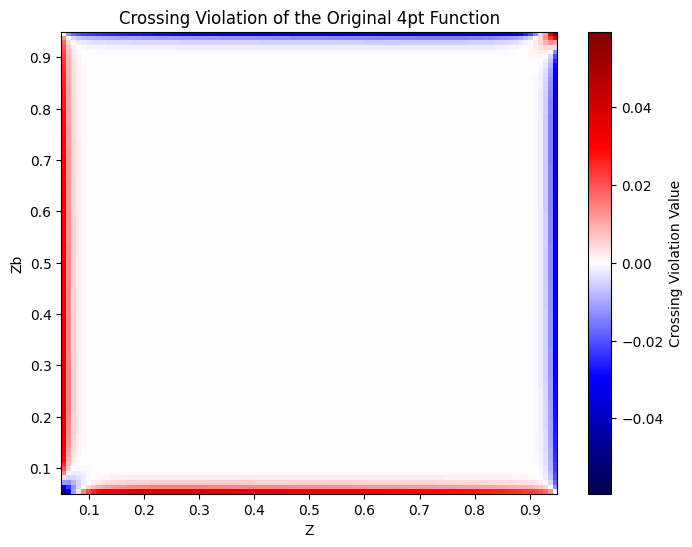

Mean Squared Error on unseen data: 1.373242e-05


1.3732424122281373e-05

In [55]:
model3, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model2,
        num_epochs=1000, weight_a=1.0, weight_b=0.001, device=device
    )



    # Plot results
plot_results(model3, phi4pt_func, device)
plot_crossing_violation(model3, phi4pt_func, Delta_phi, device)
evaluate_model(model3, phi4pt_func, device, num_points=1000)

Training:   0%|          | 2/2000 [00:00<04:02,  8.24it/s]

Epoch 0: Total Loss = 0.000077, Loss A = 0.000014, Loss B = 0.063174


Training:  10%|█         | 202/2000 [00:29<04:16,  7.02it/s]

Epoch 200: Total Loss = 0.000029, Loss A = 0.000008, Loss B = 0.020834


Training:  20%|██        | 402/2000 [00:58<04:07,  6.45it/s]

Epoch 400: Total Loss = 0.000018, Loss A = 0.000007, Loss B = 0.011014


Training:  30%|███       | 602/2000 [01:28<03:18,  7.05it/s]

Epoch 600: Total Loss = 0.000012, Loss A = 0.000005, Loss B = 0.006854


Training:  40%|████      | 802/2000 [01:57<02:47,  7.14it/s]

Epoch 800: Total Loss = 0.000009, Loss A = 0.000004, Loss B = 0.004843


Training:  50%|█████     | 1002/2000 [02:27<02:24,  6.91it/s]

Epoch 1000: Total Loss = 0.000007, Loss A = 0.000003, Loss B = 0.003727


Training:  60%|██████    | 1202/2000 [02:57<02:15,  5.88it/s]

Epoch 1200: Total Loss = 0.000006, Loss A = 0.000002, Loss B = 0.003031


Training:  70%|███████   | 1402/2000 [03:27<01:25,  6.97it/s]

Epoch 1400: Total Loss = 0.000005, Loss A = 0.000002, Loss B = 0.002651


Training:  80%|████████  | 1602/2000 [03:57<00:57,  6.95it/s]

Epoch 1600: Total Loss = 0.000006, Loss A = 0.000003, Loss B = 0.002570


Training:  90%|█████████ | 1802/2000 [04:26<00:28,  6.95it/s]

Epoch 1800: Total Loss = 0.000004, Loss A = 0.000002, Loss B = 0.002156


Training: 100%|██████████| 2000/2000 [04:55<00:00,  6.77it/s]


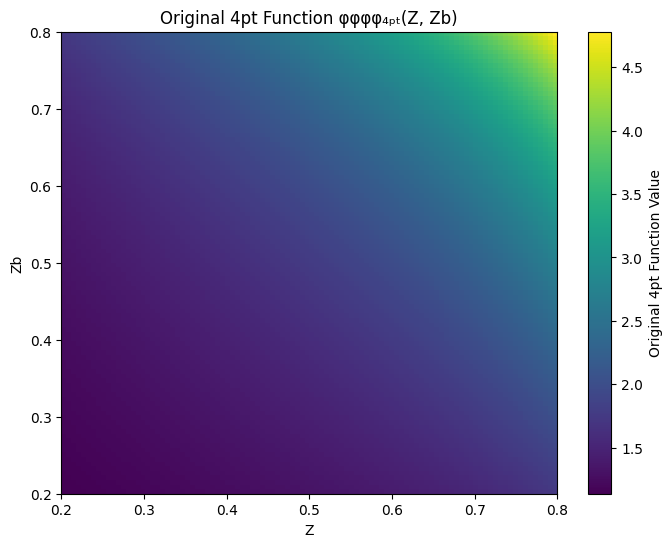

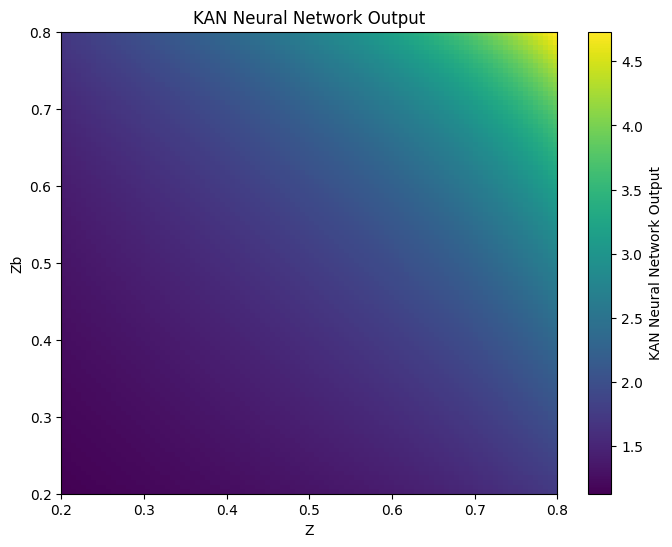

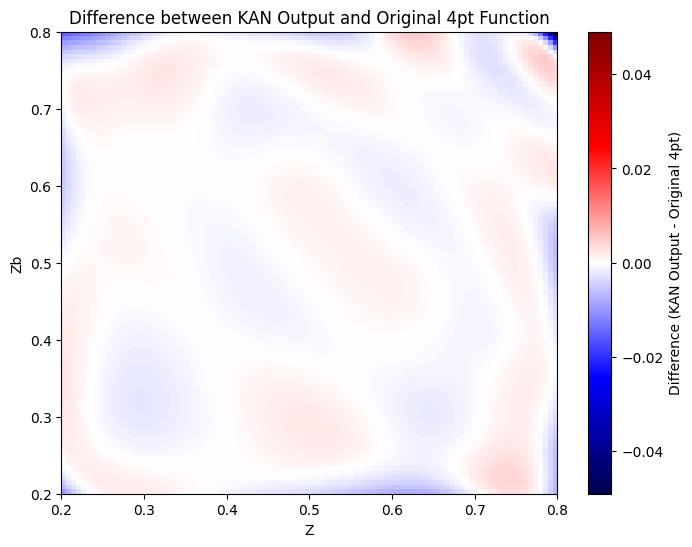

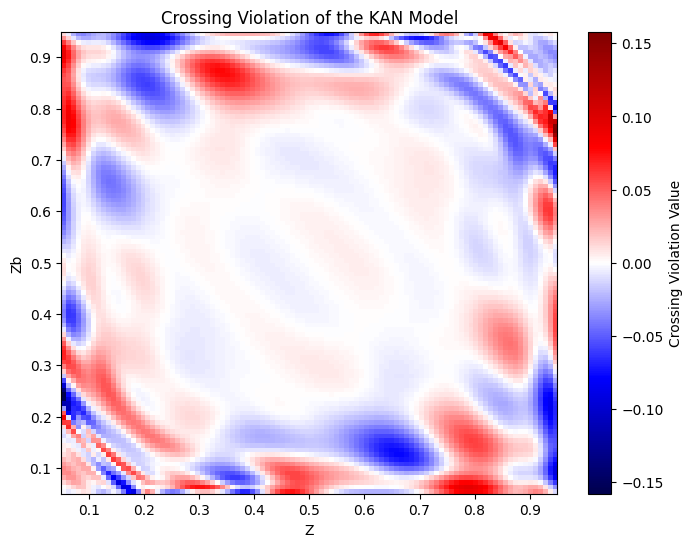

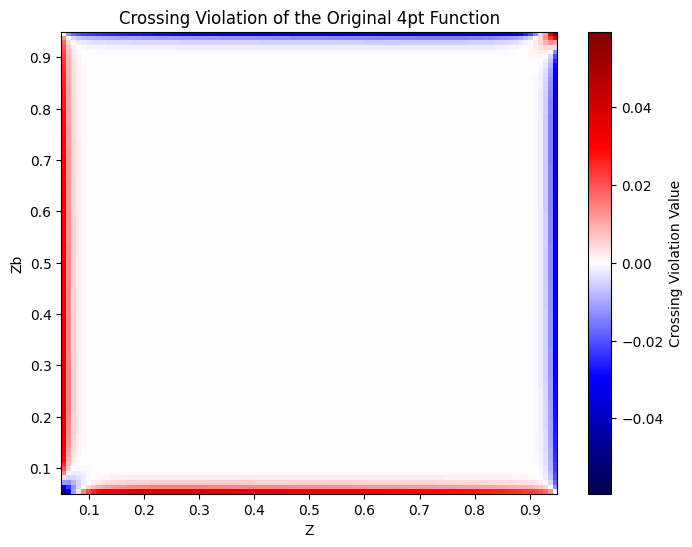

Mean Squared Error on unseen data: 1.730361e-06


1.7303605091001373e-06

In [56]:
model4, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model3,
        num_epochs=2000, weight_a=1.0, weight_b=0.001, device=device
    )



    # Plot results
plot_results(model4, phi4pt_func, device)
plot_crossing_violation(model4, phi4pt_func, Delta_phi, device)
evaluate_model(model4, phi4pt_func, device, num_points=1000)

Training:   0%|          | 2/1000 [00:00<02:46,  6.00it/s]

Epoch 0: Total Loss = 0.000106, Loss A = 0.000106, Loss B = 455.118408


Training:  10%|█         | 102/1000 [00:15<02:08,  6.97it/s]

Epoch 100: Total Loss = 0.000006, Loss A = 0.000006, Loss B = 475.134796


Training:  20%|██        | 202/1000 [00:32<01:57,  6.81it/s]

Epoch 200: Total Loss = 0.000003, Loss A = 0.000003, Loss B = 485.226868


Training:  30%|███       | 302/1000 [00:46<01:41,  6.88it/s]

Epoch 300: Total Loss = 0.000002, Loss A = 0.000002, Loss B = 484.195923


Training:  40%|████      | 402/1000 [01:01<01:25,  7.00it/s]

Epoch 400: Total Loss = 0.000002, Loss A = 0.000002, Loss B = 476.572296


Training:  50%|█████     | 502/1000 [01:16<01:10,  7.04it/s]

Epoch 500: Total Loss = 0.000001, Loss A = 0.000001, Loss B = 464.658813


Training:  60%|██████    | 602/1000 [01:30<00:56,  7.07it/s]

Epoch 600: Total Loss = 0.000001, Loss A = 0.000001, Loss B = 450.124359


Training:  70%|███████   | 702/1000 [01:45<00:45,  6.61it/s]

Epoch 700: Total Loss = 0.000001, Loss A = 0.000001, Loss B = 434.284210


Training:  80%|████████  | 802/1000 [02:00<00:28,  6.95it/s]

Epoch 800: Total Loss = 0.000001, Loss A = 0.000001, Loss B = 418.136780


Training:  90%|█████████ | 902/1000 [02:15<00:13,  7.07it/s]

Epoch 900: Total Loss = 0.000001, Loss A = 0.000001, Loss B = 403.062866


Training: 100%|██████████| 1000/1000 [02:29<00:00,  6.69it/s]


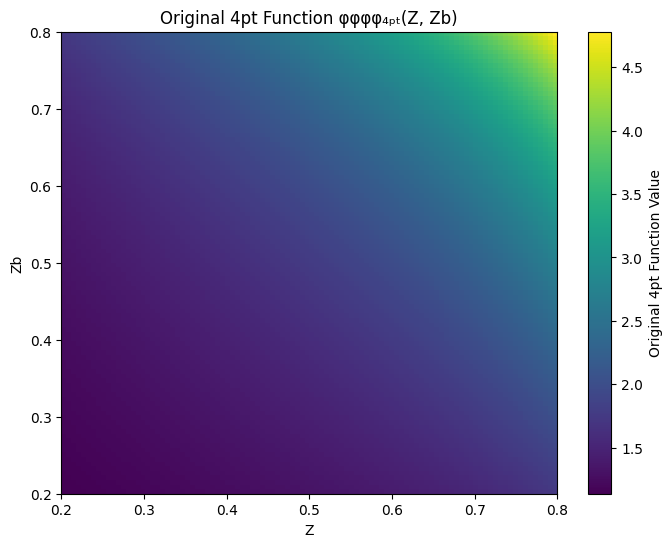

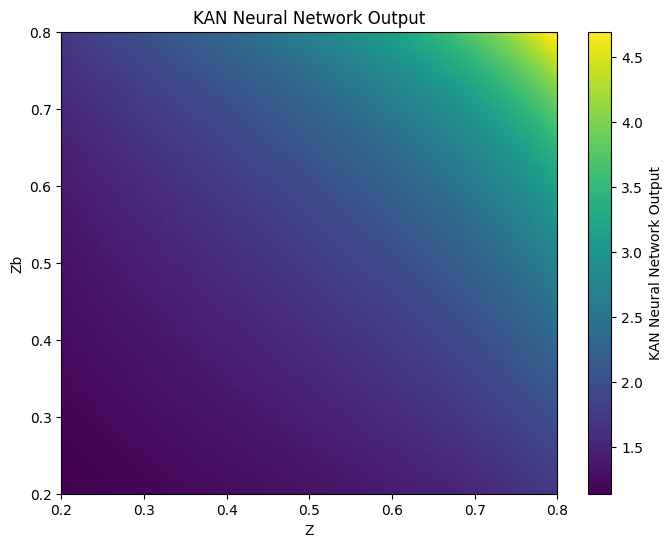

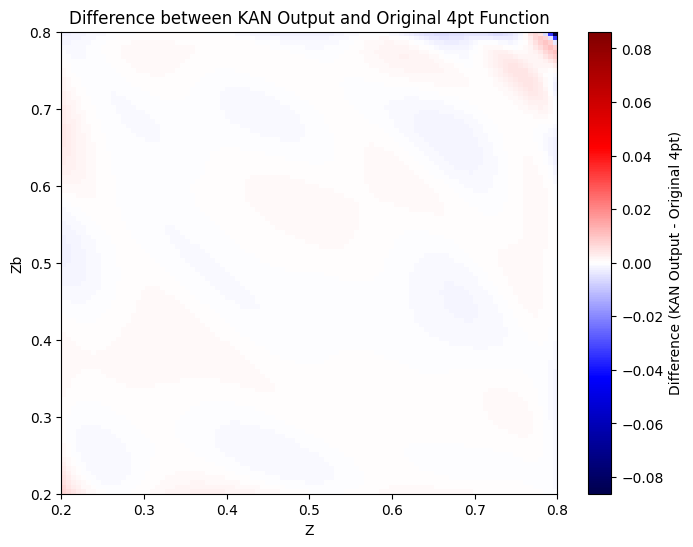

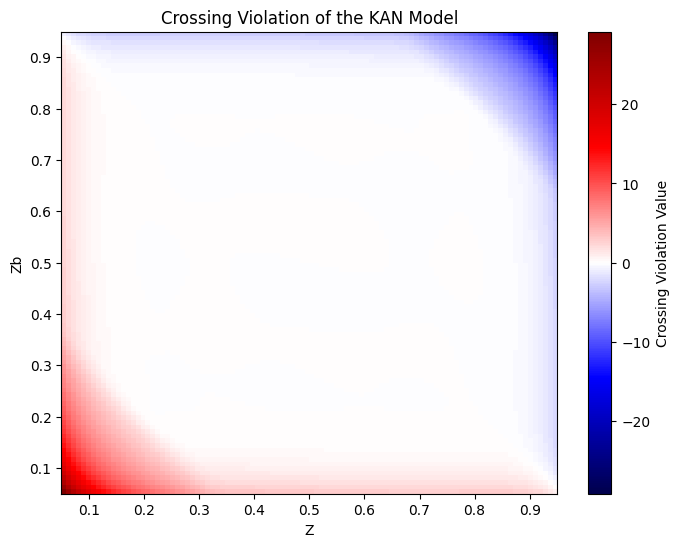

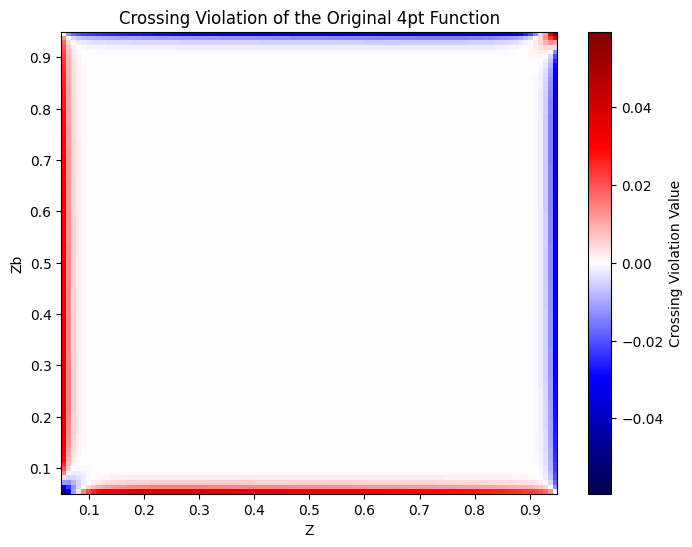

Mean Squared Error on unseen data: 6.097495e-07


Training:   0%|          | 2/1000 [00:00<02:13,  7.48it/s]

Epoch 0: Total Loss = 24.061132, Loss A = 0.000001, Loss B = 240.611328


Training:  10%|█         | 102/1000 [00:14<02:10,  6.88it/s]

Epoch 100: Total Loss = 0.669510, Loss A = 0.247847, Loss B = 4.216631


Training:  20%|██        | 202/1000 [00:29<01:53,  7.03it/s]

Epoch 200: Total Loss = 0.277281, Loss A = 0.115760, Loss B = 1.615203


Training:  30%|███       | 302/1000 [00:43<01:38,  7.11it/s]

Epoch 300: Total Loss = 0.169096, Loss A = 0.066211, Loss B = 1.028848


Training:  40%|████      | 402/1000 [00:58<01:25,  6.98it/s]

Epoch 400: Total Loss = 0.102002, Loss A = 0.038202, Loss B = 0.638004


Training:  50%|█████     | 502/1000 [01:13<01:11,  6.99it/s]

Epoch 500: Total Loss = 0.059778, Loss A = 0.019792, Loss B = 0.399862


Training:  60%|██████    | 602/1000 [01:27<00:57,  6.94it/s]

Epoch 600: Total Loss = 0.032025, Loss A = 0.010339, Loss B = 0.216856


Training:  70%|███████   | 702/1000 [01:42<00:42,  6.97it/s]

Epoch 700: Total Loss = 0.018796, Loss A = 0.006269, Loss B = 0.125278


Training:  80%|████████  | 802/1000 [01:57<00:29,  6.82it/s]

Epoch 800: Total Loss = 0.013038, Loss A = 0.004017, Loss B = 0.090206


Training:  90%|█████████ | 902/1000 [02:12<00:14,  6.90it/s]

Epoch 900: Total Loss = 0.009802, Loss A = 0.002749, Loss B = 0.070528


Training: 100%|██████████| 1000/1000 [02:26<00:00,  6.84it/s]


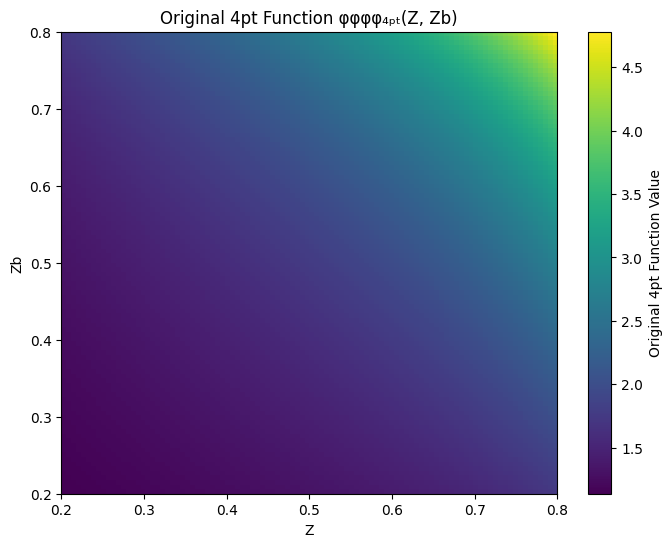

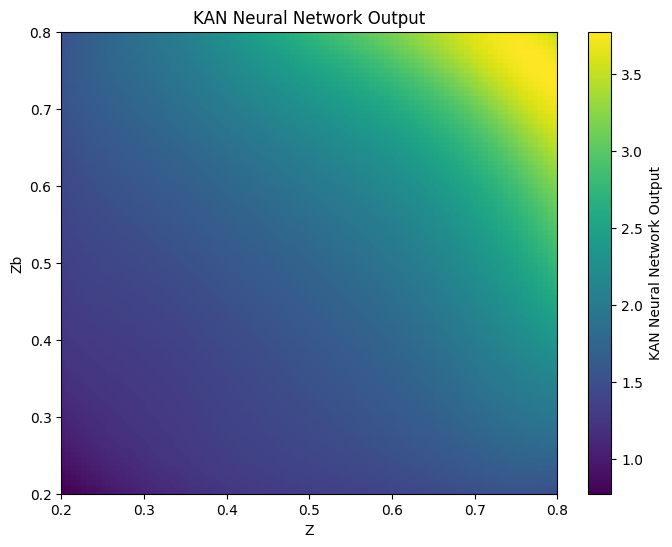

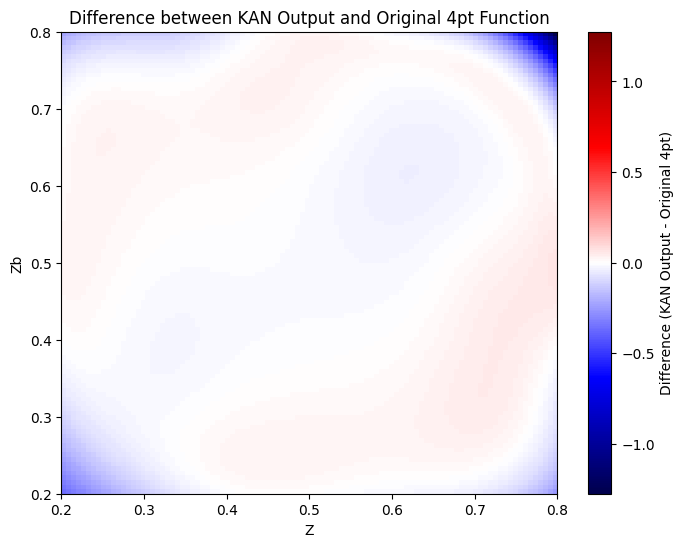

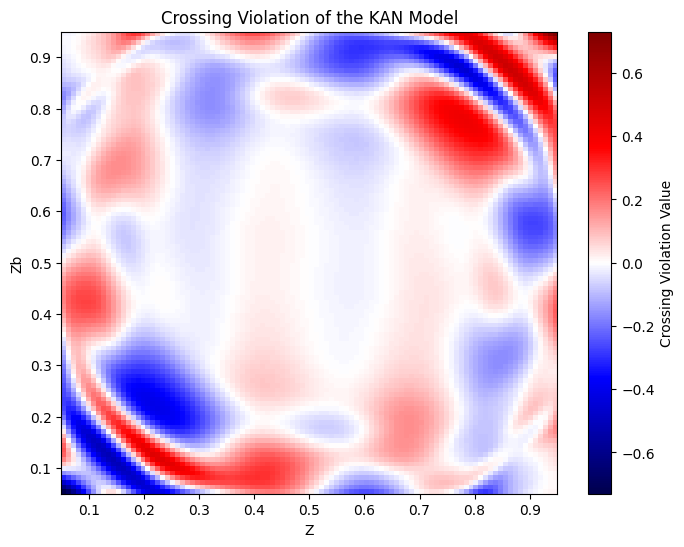

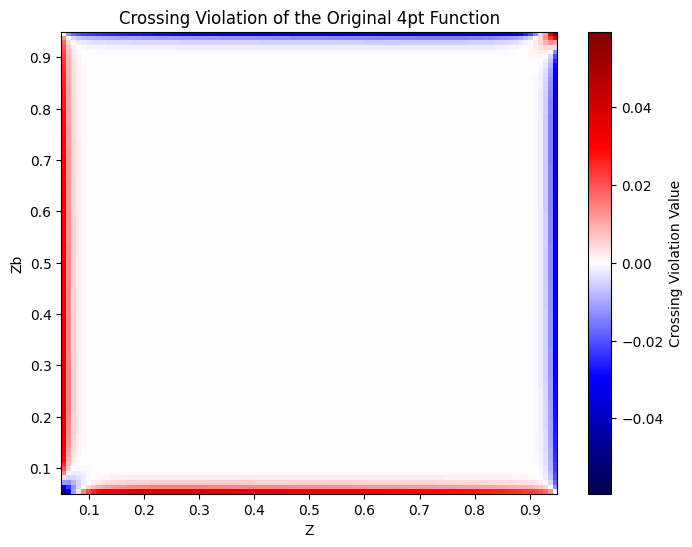

Mean Squared Error on unseen data: 2.381178e-03


Training:   0%|          | 2/1000 [00:00<02:14,  7.43it/s]

Epoch 0: Total Loss = 0.034316, Loss A = 0.006549, Loss B = 0.138831


Training:  10%|█         | 101/1000 [00:14<02:10,  6.90it/s]

Epoch 100: Total Loss = 0.005860, Loss A = 0.000830, Loss B = 0.025154


Training:  20%|██        | 202/1000 [00:30<01:53,  7.02it/s]

Epoch 200: Total Loss = 0.002783, Loss A = 0.000585, Loss B = 0.010994


Training:  30%|███       | 302/1000 [00:45<01:40,  6.95it/s]

Epoch 300: Total Loss = 0.001740, Loss A = 0.000434, Loss B = 0.006528


Training:  40%|████      | 402/1000 [00:59<01:26,  6.93it/s]

Epoch 400: Total Loss = 0.001245, Loss A = 0.000317, Loss B = 0.004638


Training:  50%|█████     | 502/1000 [01:14<01:09,  7.14it/s]

Epoch 500: Total Loss = 0.000960, Loss A = 0.000240, Loss B = 0.003603


Training:  60%|██████    | 602/1000 [01:28<00:55,  7.14it/s]

Epoch 600: Total Loss = 0.000769, Loss A = 0.000187, Loss B = 0.002912


Training:  70%|███████   | 702/1000 [01:43<00:41,  7.19it/s]

Epoch 700: Total Loss = 0.000638, Loss A = 0.000151, Loss B = 0.002436


Training:  80%|████████  | 802/1000 [01:57<00:28,  7.07it/s]

Epoch 800: Total Loss = 0.000536, Loss A = 0.000122, Loss B = 0.002074


Training:  90%|█████████ | 902/1000 [02:13<00:14,  6.93it/s]

Epoch 900: Total Loss = 0.000462, Loss A = 0.000102, Loss B = 0.001798


Training: 100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]


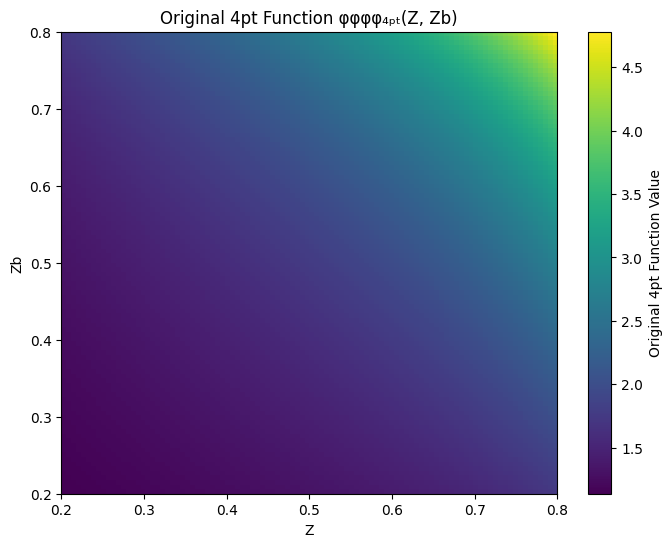

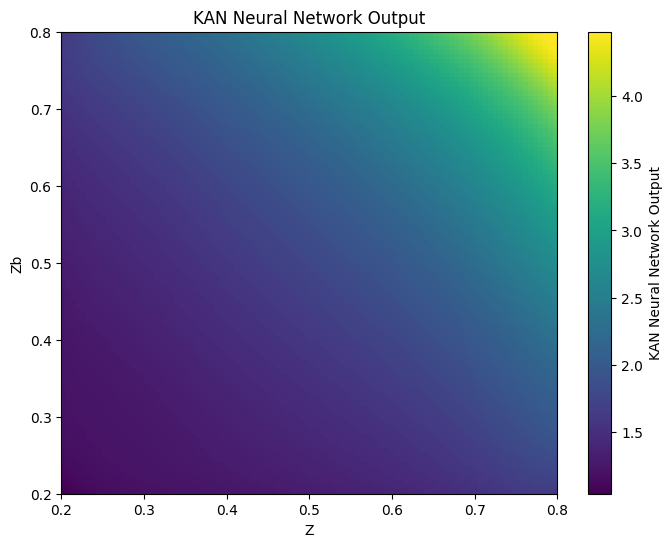

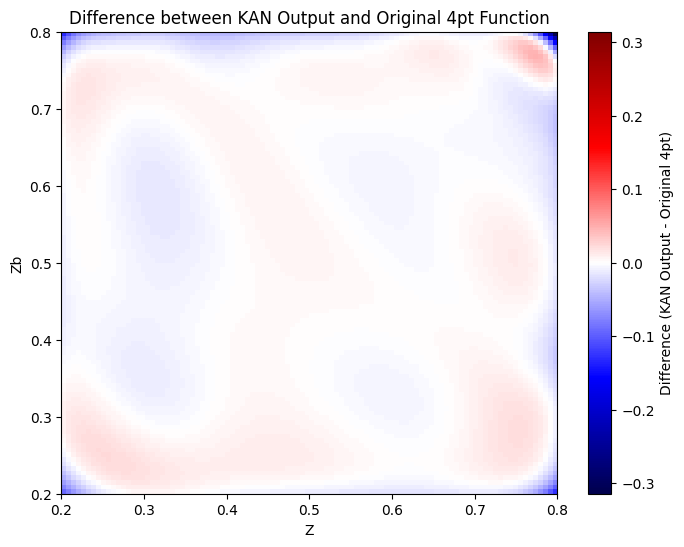

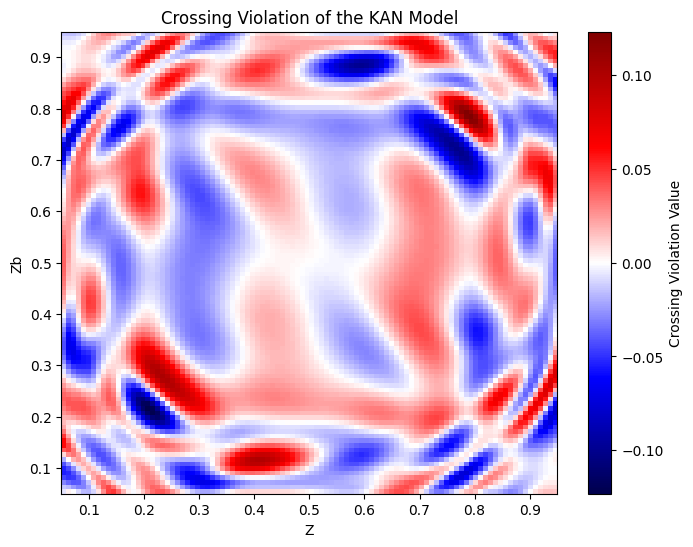

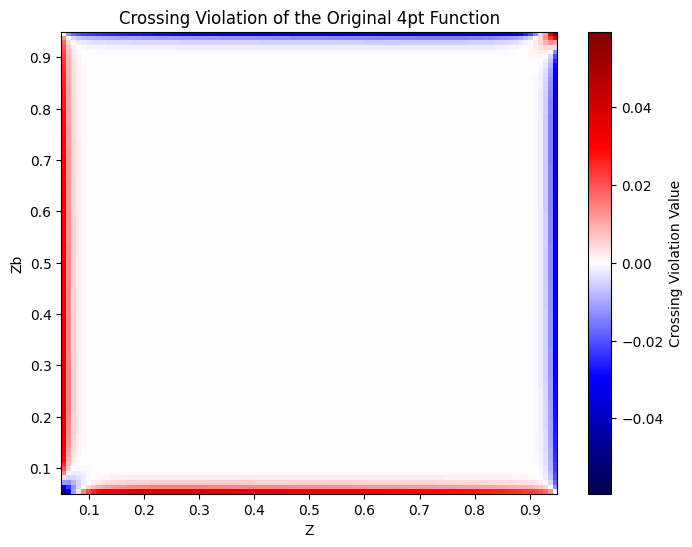

Mean Squared Error on unseen data: 7.193798e-05


Training:   0%|          | 2/1000 [00:00<02:17,  7.27it/s]

Epoch 0: Total Loss = 0.014864, Loss A = 0.000100, Loss B = 0.049216


Training:  10%|█         | 102/1000 [00:14<02:07,  7.03it/s]

Epoch 100: Total Loss = 0.001100, Loss A = 0.000138, Loss B = 0.003209


Training:  20%|██        | 202/1000 [00:29<01:52,  7.08it/s]

Epoch 200: Total Loss = 0.000863, Loss A = 0.000121, Loss B = 0.002473


Training:  30%|███       | 302/1000 [00:44<01:40,  6.98it/s]

Epoch 300: Total Loss = 0.000744, Loss A = 0.000113, Loss B = 0.002104


Training:  40%|████      | 402/1000 [00:58<01:24,  7.06it/s]

Epoch 400: Total Loss = 0.000664, Loss A = 0.000106, Loss B = 0.001863


Training:  50%|█████     | 502/1000 [01:13<01:12,  6.91it/s]

Epoch 500: Total Loss = 0.000602, Loss A = 0.000098, Loss B = 0.001682


Training:  60%|██████    | 602/1000 [01:27<00:56,  7.09it/s]

Epoch 600: Total Loss = 0.000550, Loss A = 0.000089, Loss B = 0.001535


Training:  70%|███████   | 702/1000 [01:42<00:41,  7.14it/s]

Epoch 700: Total Loss = 0.000504, Loss A = 0.000081, Loss B = 0.001410


Training:  80%|████████  | 802/1000 [01:56<00:28,  7.01it/s]

Epoch 800: Total Loss = 0.000463, Loss A = 0.000073, Loss B = 0.001300


Training:  90%|█████████ | 902/1000 [02:10<00:13,  7.07it/s]

Epoch 900: Total Loss = 0.000427, Loss A = 0.000066, Loss B = 0.001202


Training: 100%|██████████| 1000/1000 [02:25<00:00,  6.89it/s]


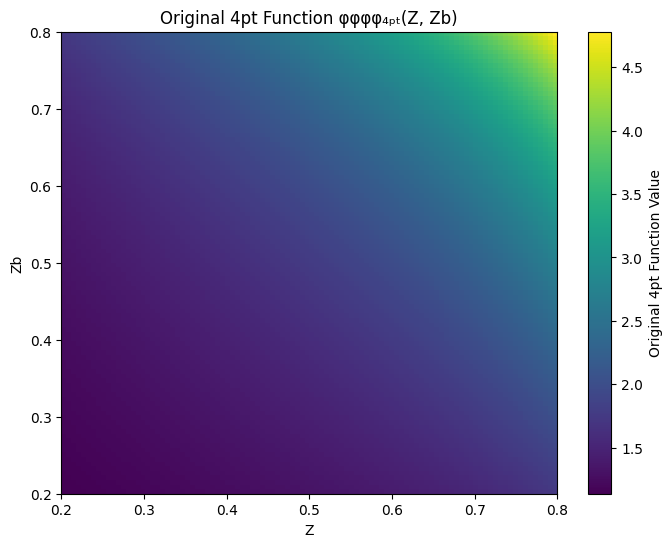

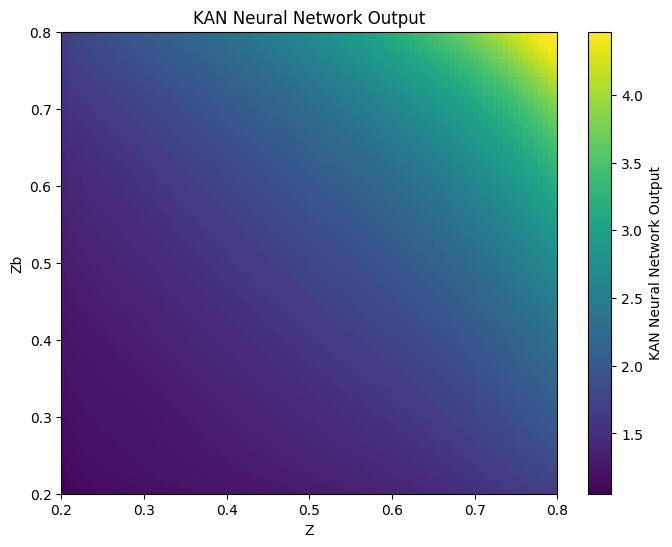

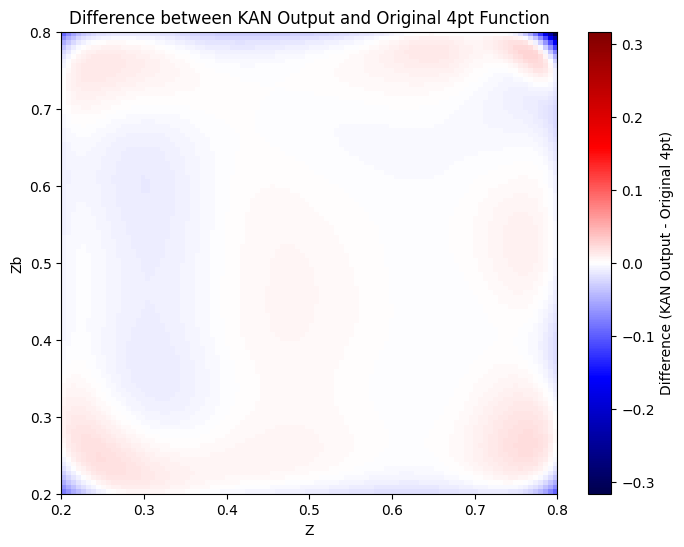

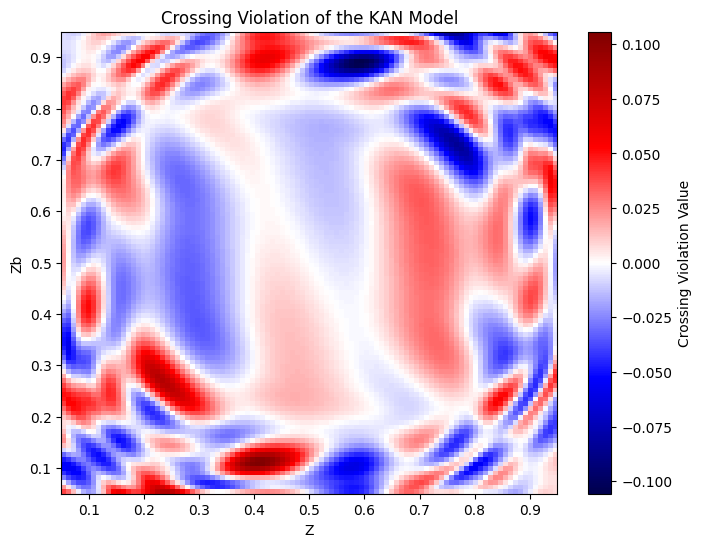

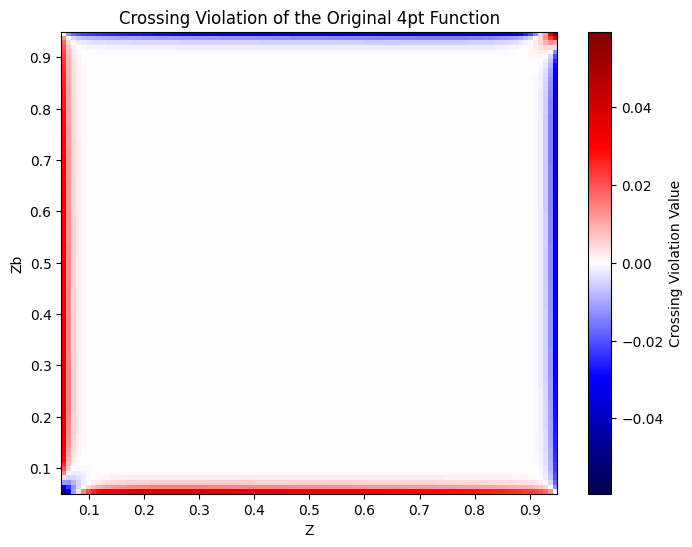

Mean Squared Error on unseen data: 4.446811e-05


Training:   0%|          | 1/1000 [00:00<03:50,  4.33it/s]

Epoch 0: Total Loss = 0.002408, Loss A = 0.000040, Loss B = 0.005920


Training:  10%|█         | 102/1000 [00:14<02:12,  6.77it/s]

Epoch 100: Total Loss = 0.000746, Loss A = 0.000057, Loss B = 0.001722


Training:  20%|██        | 202/1000 [00:30<01:56,  6.87it/s]

Epoch 200: Total Loss = 0.000631, Loss A = 0.000044, Loss B = 0.001467


Training:  30%|███       | 302/1000 [00:44<01:29,  7.80it/s]

Epoch 300: Total Loss = 0.000563, Loss A = 0.000040, Loss B = 0.001308


Training:  40%|████      | 402/1000 [00:57<01:19,  7.53it/s]

Epoch 400: Total Loss = 0.000507, Loss A = 0.000039, Loss B = 0.001171


Training:  50%|█████     | 502/1000 [01:11<01:09,  7.14it/s]

Epoch 500: Total Loss = 0.000457, Loss A = 0.000038, Loss B = 0.001049


Training:  60%|██████    | 602/1000 [01:24<00:48,  8.20it/s]

Epoch 600: Total Loss = 0.000412, Loss A = 0.000036, Loss B = 0.000939


Training:  70%|███████   | 702/1000 [01:35<00:32,  9.30it/s]

Epoch 700: Total Loss = 0.000371, Loss A = 0.000035, Loss B = 0.000840


Training:  80%|████████  | 802/1000 [01:45<00:21,  9.41it/s]

Epoch 800: Total Loss = 0.000334, Loss A = 0.000034, Loss B = 0.000750


Training:  90%|█████████ | 902/1000 [01:56<00:10,  9.49it/s]

Epoch 900: Total Loss = 0.000300, Loss A = 0.000033, Loss B = 0.000668


Training: 100%|██████████| 1000/1000 [02:07<00:00,  7.86it/s]


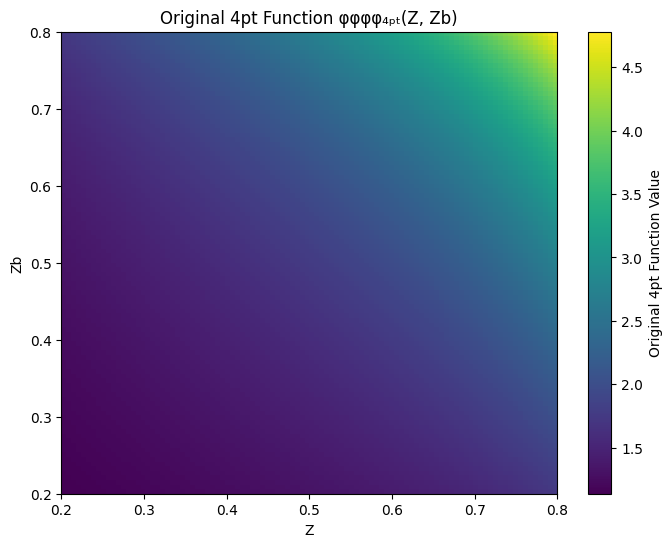

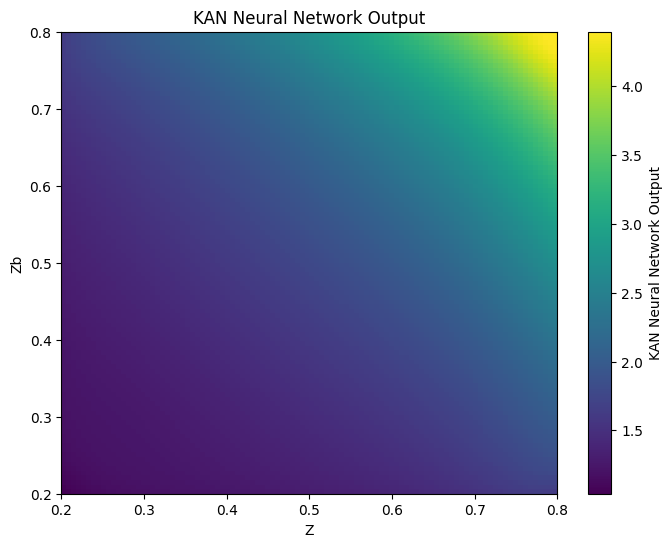

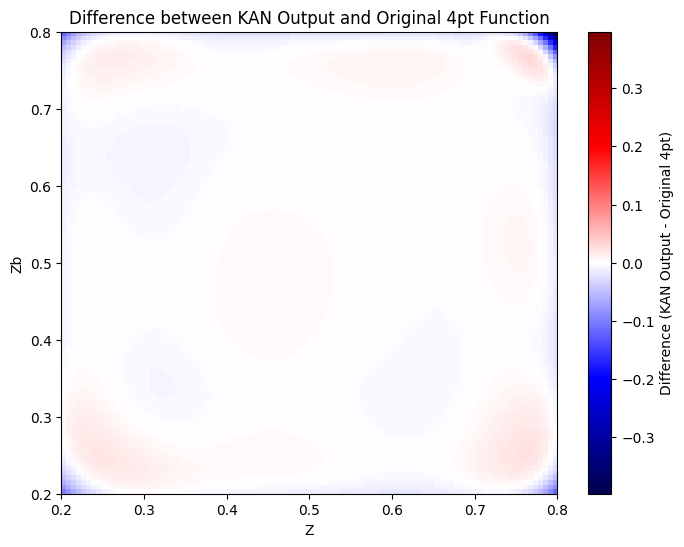

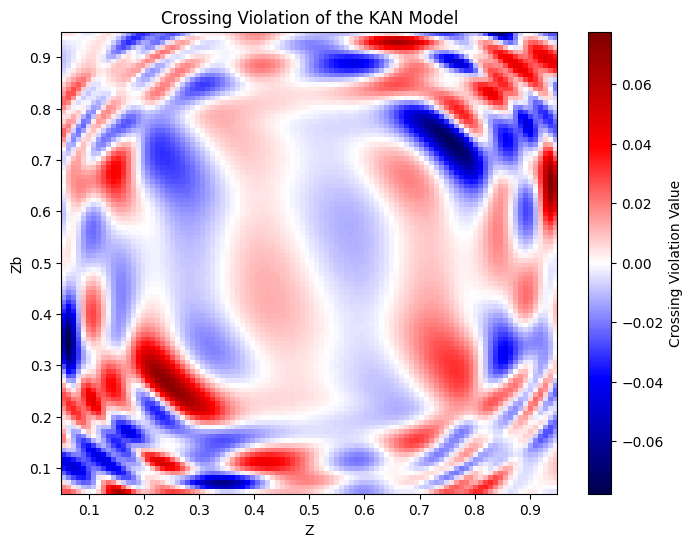

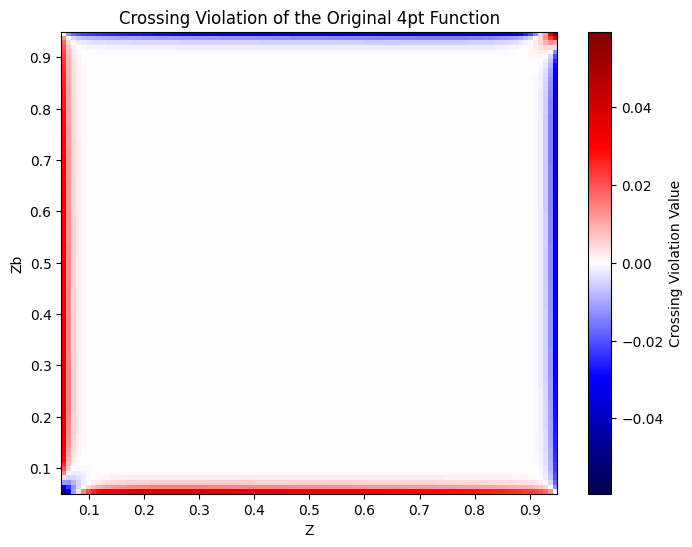

Mean Squared Error on unseen data: 8.423920e-05


Training:   0%|          | 2/1000 [00:00<02:22,  7.00it/s]

Epoch 0: Total Loss = 0.003541, Loss A = 0.000051, Loss B = 0.006980


Training:  10%|█         | 102/1000 [00:11<01:37,  9.24it/s]

Epoch 100: Total Loss = 0.000511, Loss A = 0.000054, Loss B = 0.000915


Training:  20%|██        | 202/1000 [00:21<01:22,  9.64it/s]

Epoch 200: Total Loss = 0.000398, Loss A = 0.000046, Loss B = 0.000704


Training:  30%|███       | 302/1000 [00:32<01:16,  9.07it/s]

Epoch 300: Total Loss = 0.000342, Loss A = 0.000044, Loss B = 0.000594


Training:  40%|████      | 402/1000 [00:43<01:02,  9.62it/s]

Epoch 400: Total Loss = 0.000300, Loss A = 0.000044, Loss B = 0.000513


Training:  50%|█████     | 502/1000 [00:53<00:52,  9.47it/s]

Epoch 500: Total Loss = 0.000269, Loss A = 0.000043, Loss B = 0.000451


Training:  60%|██████    | 602/1000 [01:04<00:42,  9.32it/s]

Epoch 600: Total Loss = 0.000246, Loss A = 0.000043, Loss B = 0.000405


Training:  70%|███████   | 702/1000 [01:15<00:33,  8.88it/s]

Epoch 700: Total Loss = 0.000228, Loss A = 0.000043, Loss B = 0.000371


Training:  80%|████████  | 802/1000 [01:26<00:20,  9.44it/s]

Epoch 800: Total Loss = 0.000214, Loss A = 0.000042, Loss B = 0.000344


Training:  90%|█████████ | 902/1000 [01:36<00:10,  9.51it/s]

Epoch 900: Total Loss = 0.000202, Loss A = 0.000041, Loss B = 0.000322


Training: 100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]


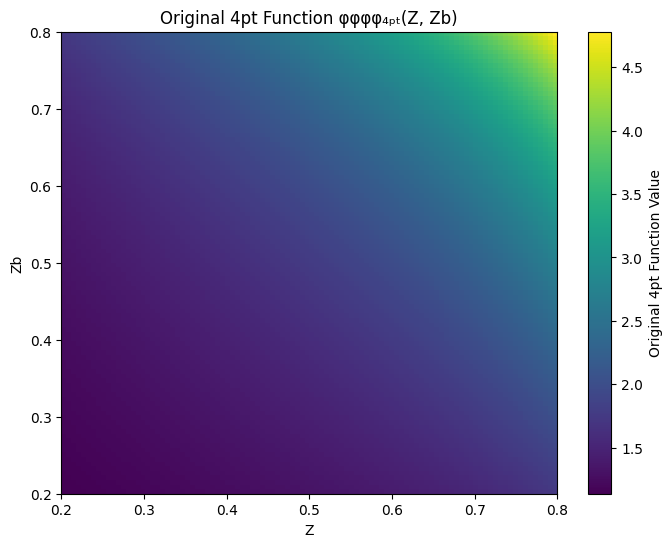

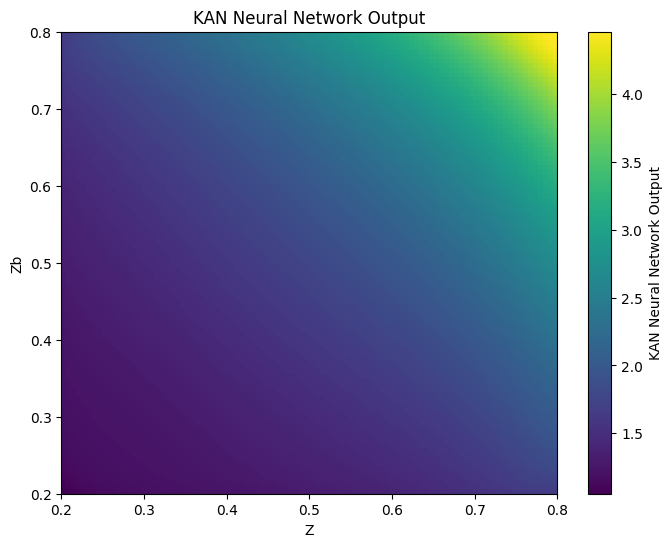

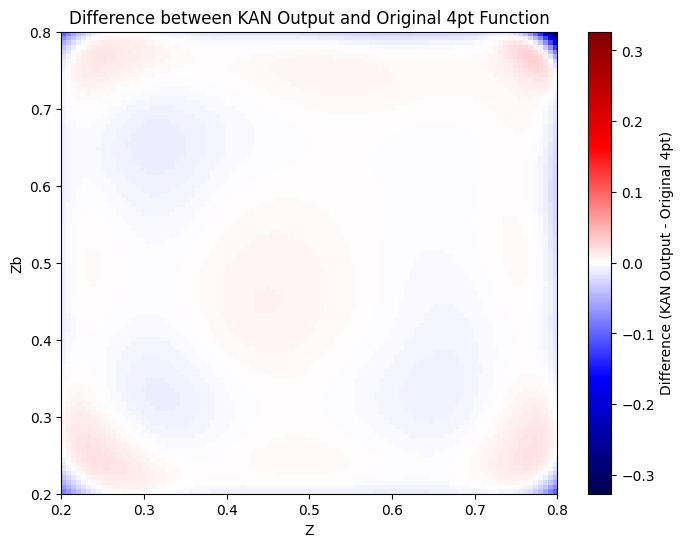

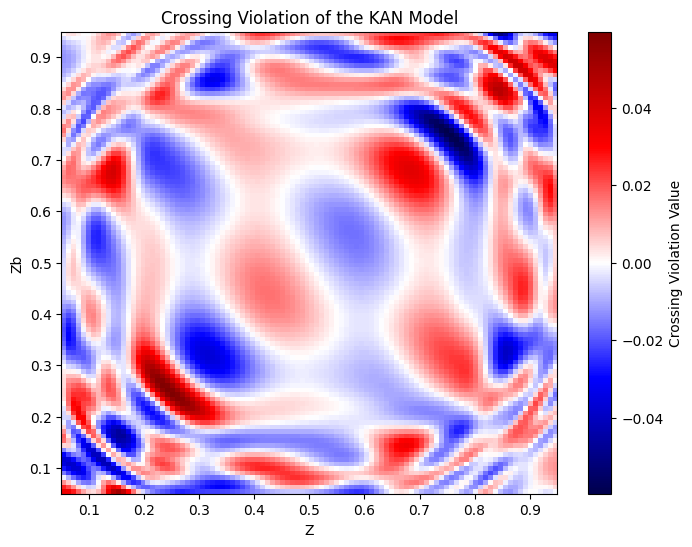

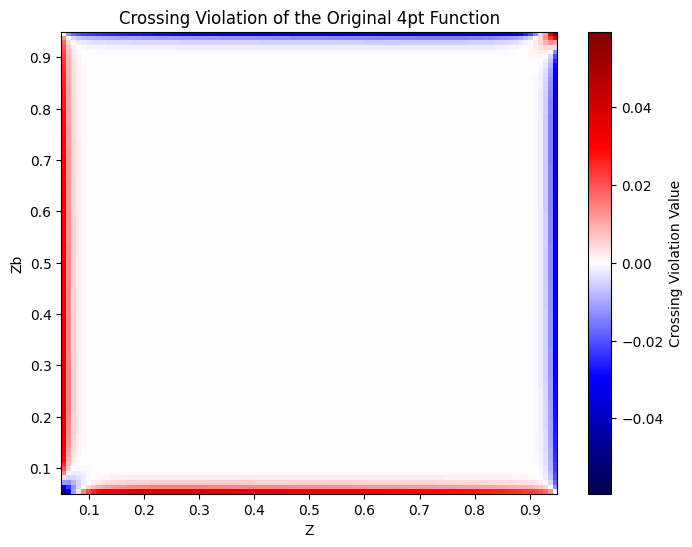

Mean Squared Error on unseen data: 5.047676e-05


Training:   0%|          | 2/1000 [00:00<02:16,  7.30it/s]

Epoch 0: Total Loss = 0.000512, Loss A = 0.000052, Loss B = 0.000767


Training:  10%|█         | 102/1000 [00:11<01:36,  9.33it/s]

Epoch 100: Total Loss = 0.000282, Loss A = 0.000062, Loss B = 0.000366


Training:  20%|██        | 202/1000 [00:21<01:25,  9.30it/s]

Epoch 200: Total Loss = 0.000238, Loss A = 0.000056, Loss B = 0.000303


Training:  30%|███       | 302/1000 [00:32<01:13,  9.47it/s]

Epoch 300: Total Loss = 0.000216, Loss A = 0.000053, Loss B = 0.000273


Training:  40%|████      | 402/1000 [00:43<01:04,  9.29it/s]

Epoch 400: Total Loss = 0.000201, Loss A = 0.000050, Loss B = 0.000251


Training:  50%|█████     | 502/1000 [00:54<00:53,  9.31it/s]

Epoch 500: Total Loss = 0.000188, Loss A = 0.000048, Loss B = 0.000234


Training:  60%|██████    | 602/1000 [01:04<00:41,  9.63it/s]

Epoch 600: Total Loss = 0.000178, Loss A = 0.000046, Loss B = 0.000220


Training:  70%|███████   | 702/1000 [01:15<00:31,  9.41it/s]

Epoch 700: Total Loss = 0.000169, Loss A = 0.000044, Loss B = 0.000208


Training:  80%|████████  | 802/1000 [01:26<00:22,  8.96it/s]

Epoch 800: Total Loss = 0.000161, Loss A = 0.000043, Loss B = 0.000197


Training:  90%|█████████ | 902/1000 [01:37<00:10,  9.19it/s]

Epoch 900: Total Loss = 0.000153, Loss A = 0.000041, Loss B = 0.000187


Training: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]


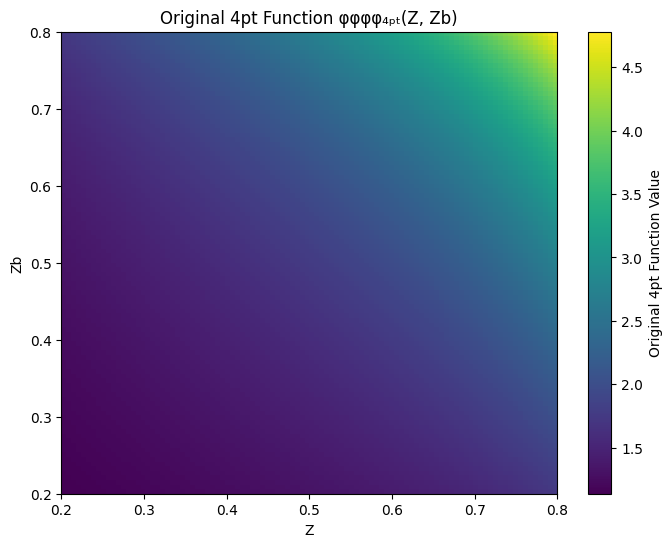

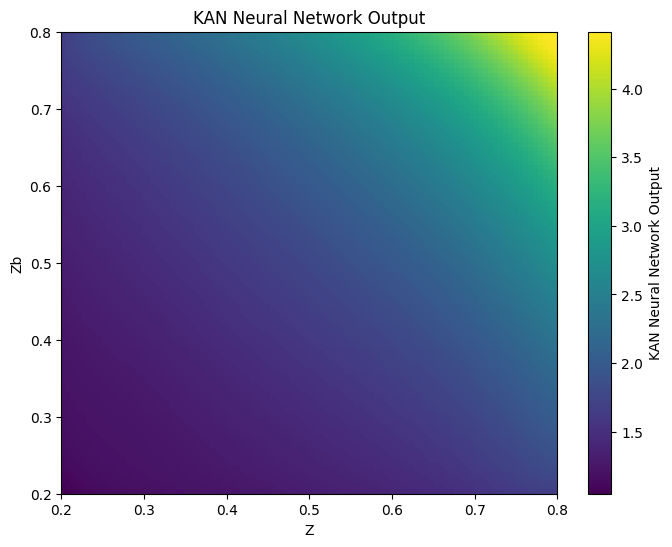

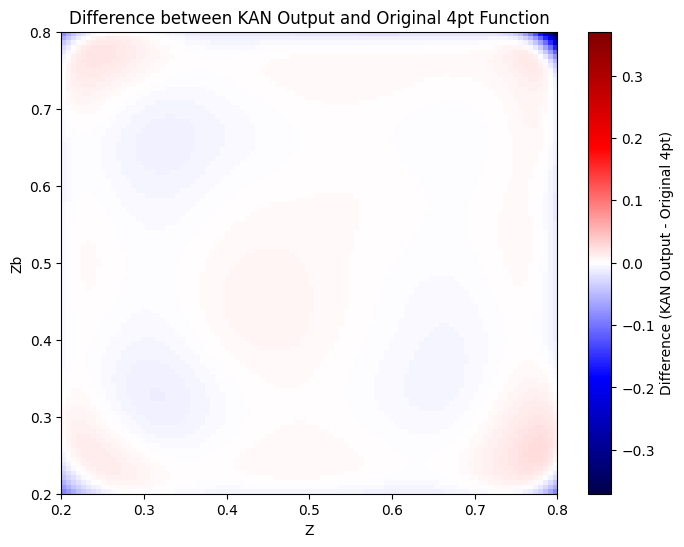

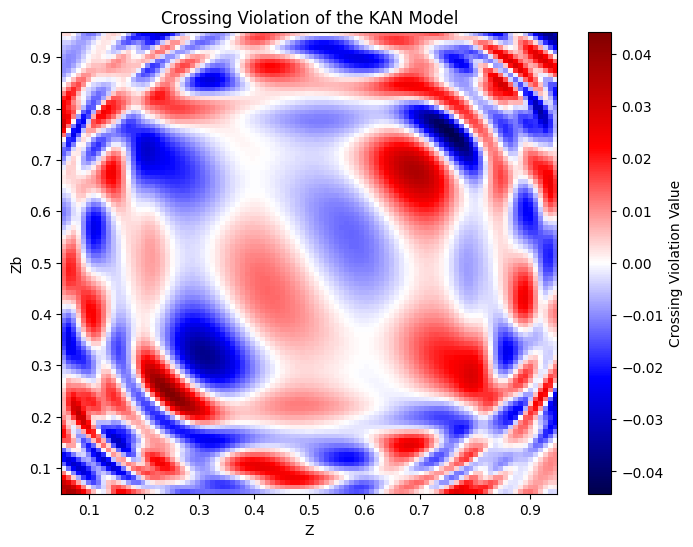

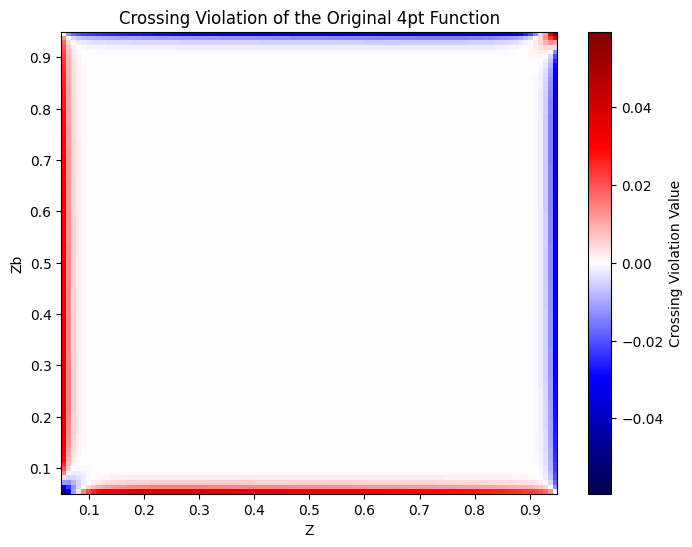

Mean Squared Error on unseen data: 7.379332e-05


Training:   0%|          | 2/1000 [00:00<01:50,  9.05it/s]

Epoch 0: Total Loss = 0.000952, Loss A = 0.000108, Loss B = 0.001206


Training:  10%|█         | 102/1000 [00:10<01:34,  9.52it/s]

Epoch 100: Total Loss = 0.000420, Loss A = 0.000127, Loss B = 0.000417


Training:  20%|██        | 202/1000 [00:21<01:34,  8.41it/s]

Epoch 200: Total Loss = 0.000325, Loss A = 0.000077, Loss B = 0.000355


Training:  30%|███       | 302/1000 [00:32<01:12,  9.64it/s]

Epoch 300: Total Loss = 0.000291, Loss A = 0.000062, Loss B = 0.000328


Training:  40%|████      | 402/1000 [00:43<01:03,  9.38it/s]

Epoch 400: Total Loss = 0.000271, Loss A = 0.000055, Loss B = 0.000309


Training:  50%|█████     | 502/1000 [00:53<00:52,  9.53it/s]

Epoch 500: Total Loss = 0.000255, Loss A = 0.000051, Loss B = 0.000292


Training:  60%|██████    | 602/1000 [01:04<00:41,  9.55it/s]

Epoch 600: Total Loss = 0.000241, Loss A = 0.000047, Loss B = 0.000277


Training:  70%|███████   | 702/1000 [01:14<00:32,  9.30it/s]

Epoch 700: Total Loss = 0.000229, Loss A = 0.000045, Loss B = 0.000264


Training:  80%|████████  | 802/1000 [01:25<00:20,  9.58it/s]

Epoch 800: Total Loss = 0.000219, Loss A = 0.000043, Loss B = 0.000252


Training:  90%|█████████ | 902/1000 [01:36<00:10,  9.60it/s]

Epoch 900: Total Loss = 0.000209, Loss A = 0.000040, Loss B = 0.000241


Training: 100%|██████████| 1000/1000 [01:46<00:00,  9.35it/s]


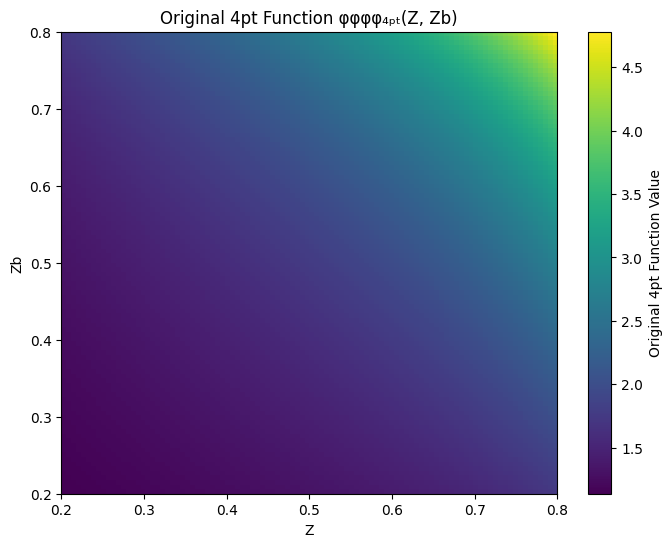

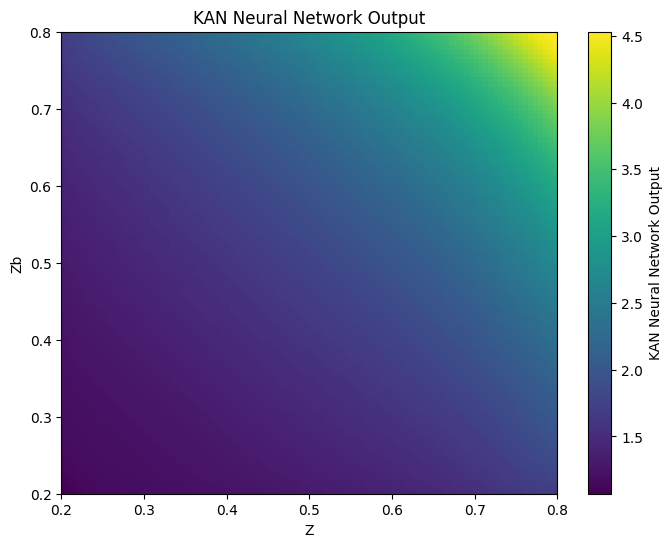

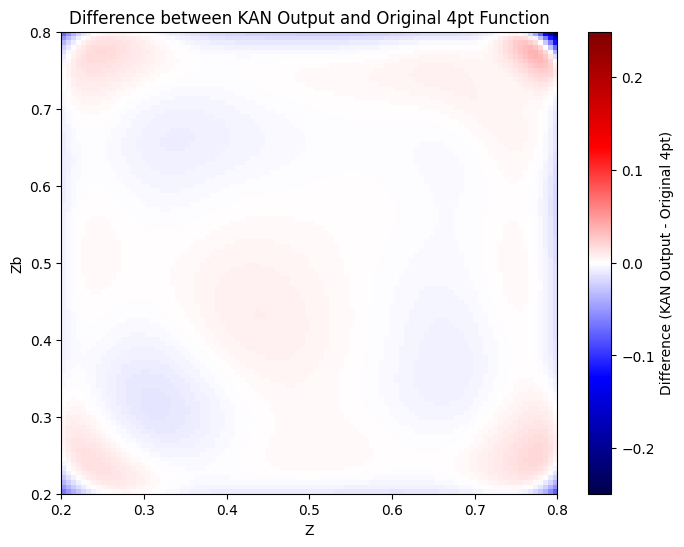

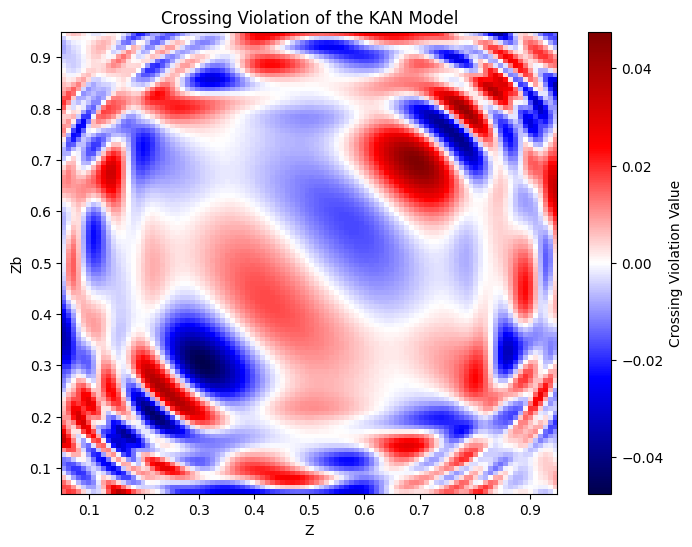

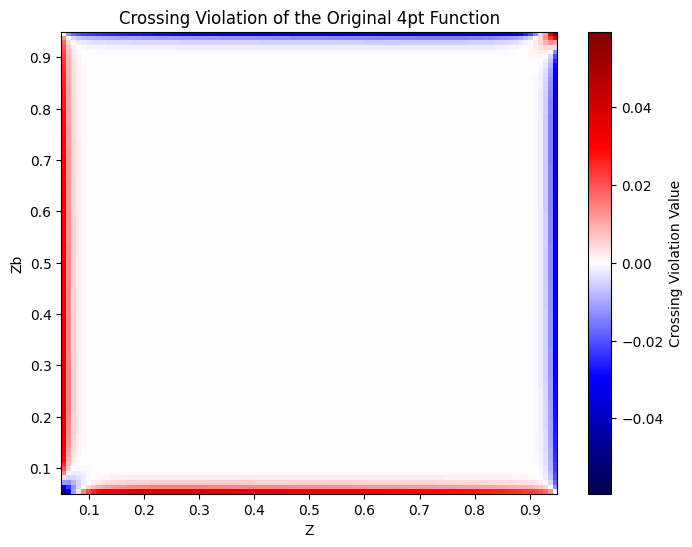

Mean Squared Error on unseen data: 2.924644e-05


Training:   0%|          | 2/1000 [00:00<01:50,  9.06it/s]

Epoch 0: Total Loss = 0.001542, Loss A = 0.000027, Loss B = 0.001894


Training:  10%|█         | 102/1000 [00:11<01:33,  9.57it/s]

Epoch 100: Total Loss = 0.000614, Loss A = 0.000028, Loss B = 0.000732


Training:  20%|██        | 202/1000 [00:21<01:24,  9.45it/s]

Epoch 200: Total Loss = 0.000454, Loss A = 0.000023, Loss B = 0.000540


Training:  30%|███       | 302/1000 [00:32<01:12,  9.64it/s]

Epoch 300: Total Loss = 0.000394, Loss A = 0.000020, Loss B = 0.000467


Training:  40%|████      | 402/1000 [00:43<01:04,  9.33it/s]

Epoch 400: Total Loss = 0.000358, Loss A = 0.000019, Loss B = 0.000424


Training:  50%|█████     | 502/1000 [00:54<00:52,  9.50it/s]

Epoch 500: Total Loss = 0.000333, Loss A = 0.000019, Loss B = 0.000392


Training:  60%|██████    | 602/1000 [01:04<00:41,  9.48it/s]

Epoch 600: Total Loss = 0.000311, Loss A = 0.000018, Loss B = 0.000366


Training:  70%|███████   | 702/1000 [01:15<00:31,  9.59it/s]

Epoch 700: Total Loss = 0.000293, Loss A = 0.000018, Loss B = 0.000344


Training:  80%|████████  | 802/1000 [01:26<00:20,  9.47it/s]

Epoch 800: Total Loss = 0.000277, Loss A = 0.000018, Loss B = 0.000324


Training:  90%|█████████ | 902/1000 [01:36<00:10,  9.51it/s]

Epoch 900: Total Loss = 0.000262, Loss A = 0.000017, Loss B = 0.000306


Training: 100%|██████████| 1000/1000 [01:47<00:00,  9.34it/s]


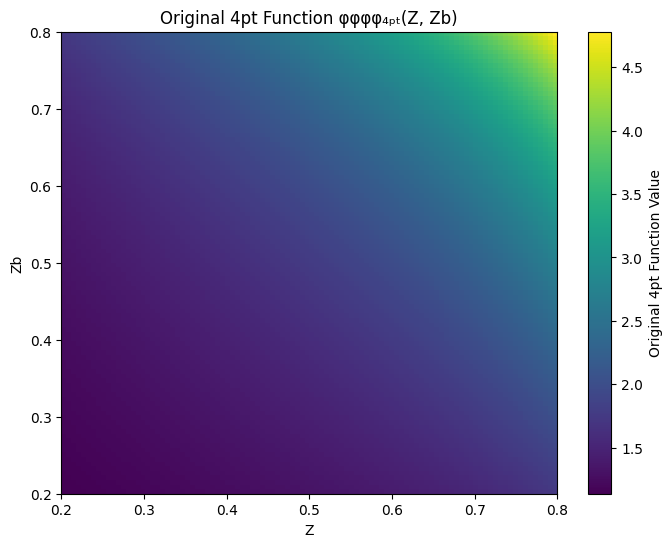

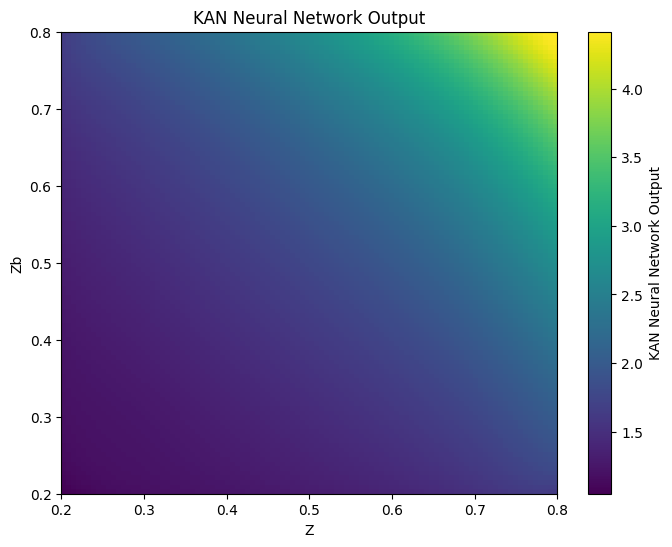

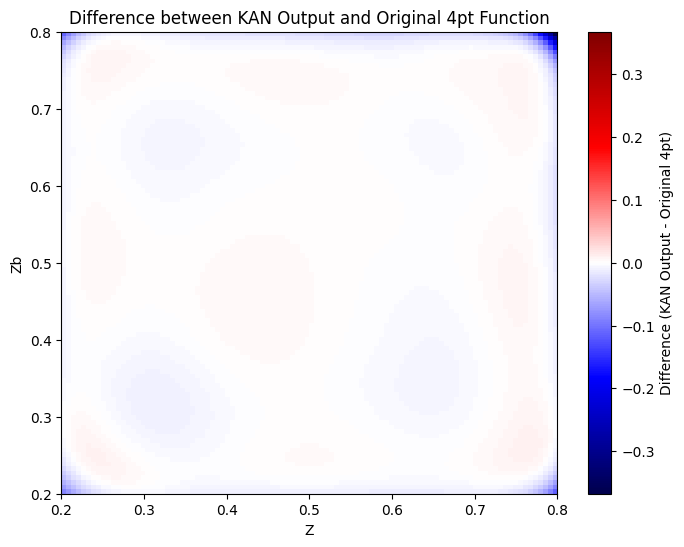

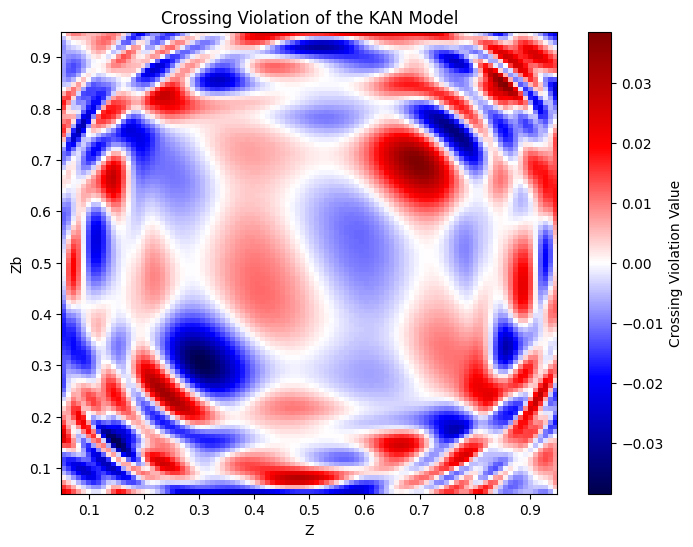

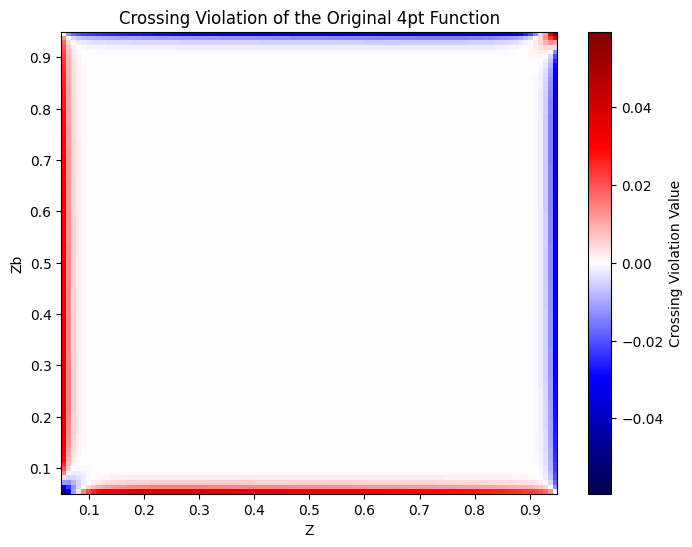

Mean Squared Error on unseen data: 4.568038e-05


Training:   0%|          | 2/1000 [00:00<01:55,  8.66it/s]

Epoch 0: Total Loss = 0.005556, Loss A = 0.000038, Loss B = 0.006132


Training:  10%|█         | 102/1000 [00:11<01:34,  9.50it/s]

Epoch 100: Total Loss = 0.000435, Loss A = 0.000067, Loss B = 0.000409


Training:  20%|██        | 202/1000 [00:21<01:27,  9.14it/s]

Epoch 200: Total Loss = 0.000346, Loss A = 0.000051, Loss B = 0.000327


Training:  30%|███       | 302/1000 [00:32<01:13,  9.45it/s]

Epoch 300: Total Loss = 0.000311, Loss A = 0.000043, Loss B = 0.000298


Training:  40%|████      | 402/1000 [00:43<01:02,  9.55it/s]

Epoch 400: Total Loss = 0.000291, Loss A = 0.000038, Loss B = 0.000282


Training:  50%|█████     | 502/1000 [00:54<00:53,  9.28it/s]

Epoch 500: Total Loss = 0.000277, Loss A = 0.000035, Loss B = 0.000269


Training:  60%|██████    | 602/1000 [01:04<00:42,  9.39it/s]

Epoch 600: Total Loss = 0.000265, Loss A = 0.000033, Loss B = 0.000258


Training:  70%|███████   | 702/1000 [01:15<00:31,  9.57it/s]

Epoch 700: Total Loss = 0.000254, Loss A = 0.000031, Loss B = 0.000248


Training:  80%|████████  | 801/1000 [01:26<00:21,  9.47it/s]

Epoch 800: Total Loss = 0.000243, Loss A = 0.000030, Loss B = 0.000237


Training:  90%|█████████ | 902/1000 [01:37<00:10,  9.39it/s]

Epoch 900: Total Loss = 0.000233, Loss A = 0.000029, Loss B = 0.000227


Training: 100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]


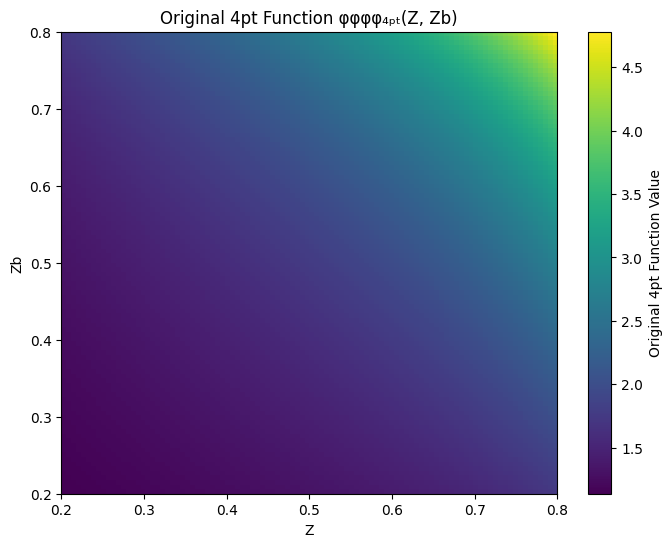

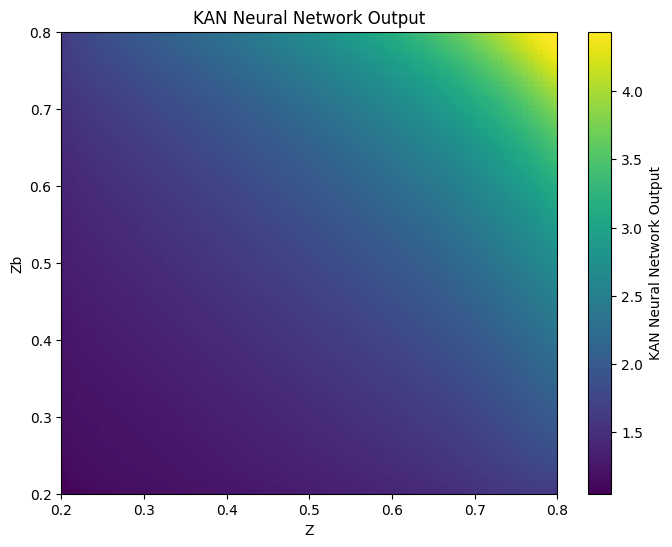

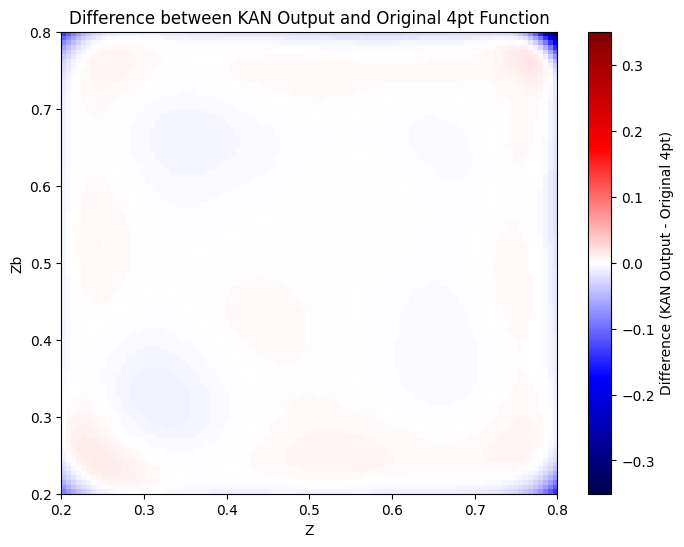

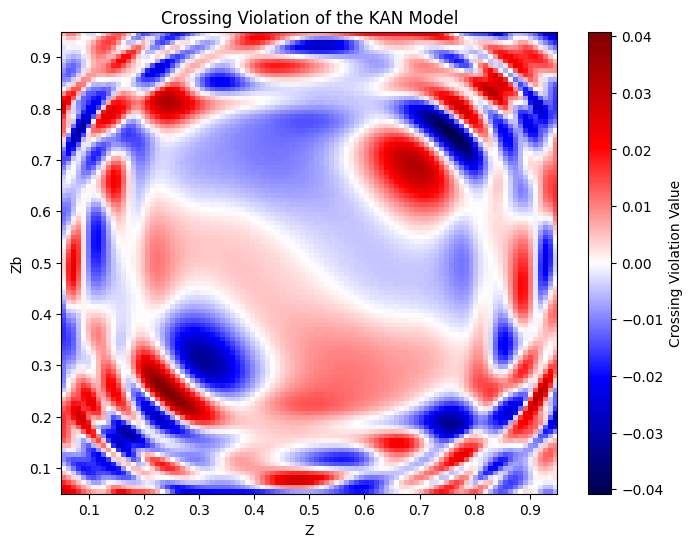

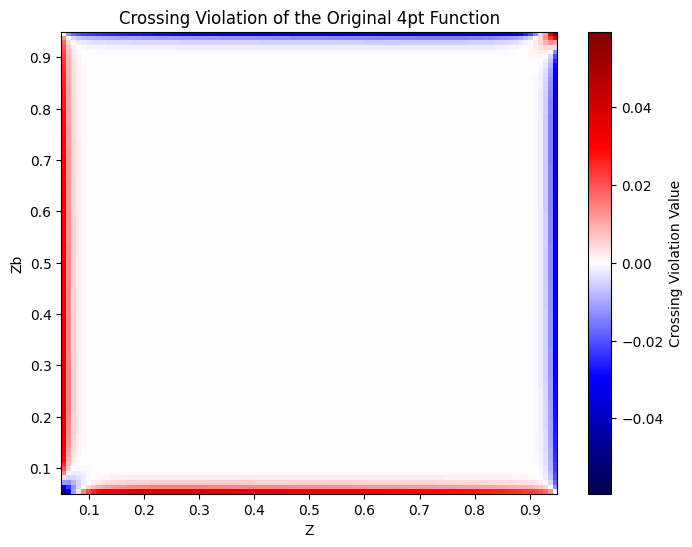

Mean Squared Error on unseen data: 9.487418e-05


In [49]:
for i in range(10):
    model, phi4pt_func = train_kan(
            file_path, Delta_phi, num_points, model=model,
            num_epochs=1000, weight_a=1.0, weight_b=i/10.0, device=device
        )



        # Plot results
    plot_results(model, phi4pt_func, device)
    plot_crossing_violation(model, phi4pt_func, Delta_phi, device)
    evaluate_model(model, phi4pt_func, device, num_points=1000)

In [43]:
model.fix_symbolic(0,0,0,'x')
model.fix_symbolic(0,0,1,'x')
model.fix_symbolic(0,1,0,'x')
model.fix_symbolic(0,1,1,'x')
model.fix_symbolic(1,0,0,'x^2')
model.fix_symbolic(1,1,0,'x^2')

r2 is 0.8885192275047302
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.1
r2 is 0.997785210609436
saving model version 0.2
Best value at boundary.
r2 is 0.8599446415901184
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3
r2 is 0.9996429085731506
saving model version 0.4
r2 is 0.9938779473304749
saving model version 0.5
r2 is 0.9980378150939941
saving model version 0.6


tensor(0.9980)

In [ ]:
model, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model,
        num_epochs=num_epochs, weight_a=1.0, weight_b=0.0, device=device
    )



    # Plot results
plot_results(model, phi4pt_func, device)
plot_crossing_violation(model, phi4pt_func, Delta_phi, device)
evaluate_model(model, phi4pt_func, device, num_points=1000)

In [44]:
model.symbolic_formula()

([-0.530900701131188*(0.192162429205445*x_1 + 0.180050844405849*x_2 - 1)**2 + 0.535289539773322*(0.984502741688094*x_1 + x_2 - 0.669415047175631)**2 + 0.516516976058483],
 [x_1, x_2])

In [20]:
# Create powers of x list
lib = ['x'] + ['x^' + str(i) for i in range(2, 6)]  # Starts from x^2 to x^35

# Add the other functions
additional_funcs = ['exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']

# Combine powers of x with the additional functions
#lib.extend(additional_funcs)
model.auto_symbolic(lib=lib)
model.symbolic_formula()

fixing (0,0,0) with x, r2=0.969209611415863, c=1
fixing (0,0,1) with x, r2=0.9992182850837708, c=1
fixing (0,0,2) with x^2, r2=0.9992964863777161, c=2
fixing (0,0,3) with x, r2=0.9926890730857849, c=1
fixing (0,0,4) with x, r2=0.9750815033912659, c=1
fixing (0,1,0) with x, r2=0.9969992637634277, c=1
fixing (0,1,1) with x, r2=0.9984392523765564, c=1
fixing (0,1,2) with x, r2=0.9586020708084106, c=1
fixing (0,1,3) with x^2, r2=0.9999397993087769, c=2
fixing (0,1,4) with x, r2=0.9882370233535767, c=1
fixing (1,0,0) with x^2, r2=0.9998860955238342, c=2
fixing (1,1,0) with x, r2=0.9347816705703735, c=1
fixing (1,2,0) with x^2, r2=0.9895359873771667, c=2
fixing (1,3,0) with x^2, r2=0.9973145127296448, c=2
fixing (1,4,0) with x^2, r2=0.9808272123336792, c=2
saving model version 0.1


([0.139156147088787*x_1 + 0.145363304892804*x_2 - 0.123827558573034*(-0.833466540417389*x_1 + x_2 + 0.0167355154288967)**2 + 0.0670184851124568*(-0.652804243671038*x_1 - x_2 - 0.647706340316904)**2 + 0.197776123497586*(0.784524126445098*x_1 - (1 - 0.493440962922362*x_2)**2 + 0.596078164302948)**2 + 0.138345880353094*(-0.808840748196149*x_2 + (1 - 0.963097503821948*x_1)**2 - 0.217512910077579)**2 - 0.0954497816129235],
 [x_1, x_2])

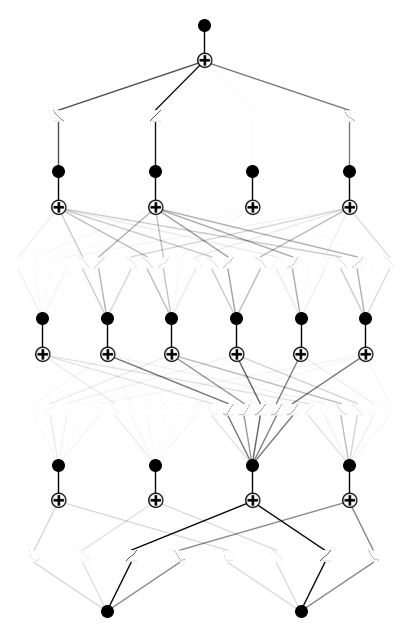

In [57]:
model.plot()

In [46]:
print_symbolic(model)

-0.530900701131188*(0.192162429205445*x1 + 0.180050844405849*x2 - 1)^2 + 0.535289539773322*(0.984502741688094*x1 + x2 - 0.669415047175631)^2 + 0.516516976058483


4 hidden layers KAN

In [61]:


# Initialize the KAN model (once)
model4l = KAN(width=[2,4,6,6,4,1], grid=10, k=3, seed=1, device=device).to(device)

checkpoint directory created: ./model
saving model version 0.0


Training:   0%|          | 1/1000 [00:00<03:59,  4.17it/s]

Epoch 0: Total Loss = 1.714714, Loss A = 1.714714, Loss B = 140.305328


Training:  10%|█         | 102/1000 [00:26<03:00,  4.98it/s]

Epoch 100: Total Loss = 0.694409, Loss A = 0.694409, Loss B = 437.004730


Training:  20%|██        | 201/1000 [00:48<03:36,  3.68it/s]

Epoch 200: Total Loss = 0.306814, Loss A = 0.306814, Loss B = 246.161331


Training:  30%|███       | 301/1000 [01:11<02:52,  4.04it/s]

Epoch 300: Total Loss = 0.090157, Loss A = 0.090157, Loss B = 239.069275


Training:  40%|████      | 401/1000 [01:37<02:09,  4.63it/s]

Epoch 400: Total Loss = 0.019341, Loss A = 0.019341, Loss B = 251.897278


Training:  50%|█████     | 501/1000 [02:00<01:51,  4.46it/s]

Epoch 500: Total Loss = 0.004937, Loss A = 0.004937, Loss B = 258.832642


Training:  60%|██████    | 601/1000 [02:22<01:27,  4.58it/s]

Epoch 600: Total Loss = 0.002141, Loss A = 0.002141, Loss B = 249.267944


Training:  70%|███████   | 701/1000 [02:44<01:05,  4.55it/s]

Epoch 700: Total Loss = 0.001132, Loss A = 0.001132, Loss B = 245.834702


Training:  80%|████████  | 801/1000 [03:07<00:43,  4.62it/s]

Epoch 800: Total Loss = 0.000715, Loss A = 0.000715, Loss B = 245.232452


Training:  90%|█████████ | 901/1000 [03:29<00:22,  4.47it/s]

Epoch 900: Total Loss = 0.000431, Loss A = 0.000431, Loss B = 244.151031


Training: 100%|██████████| 1000/1000 [03:52<00:00,  4.31it/s]


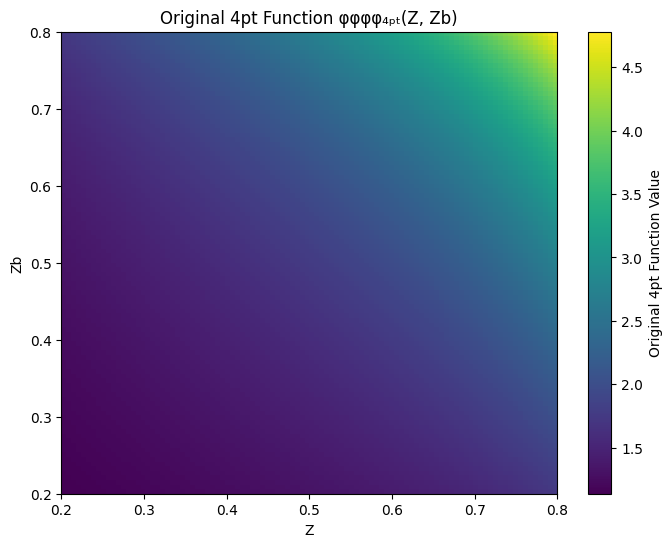

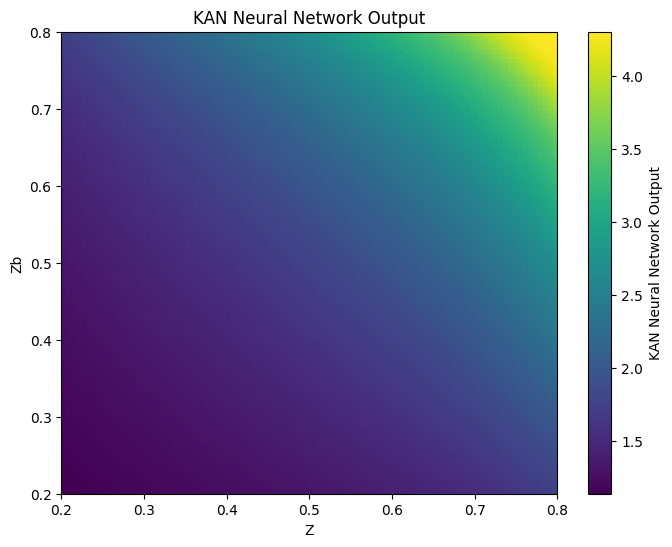

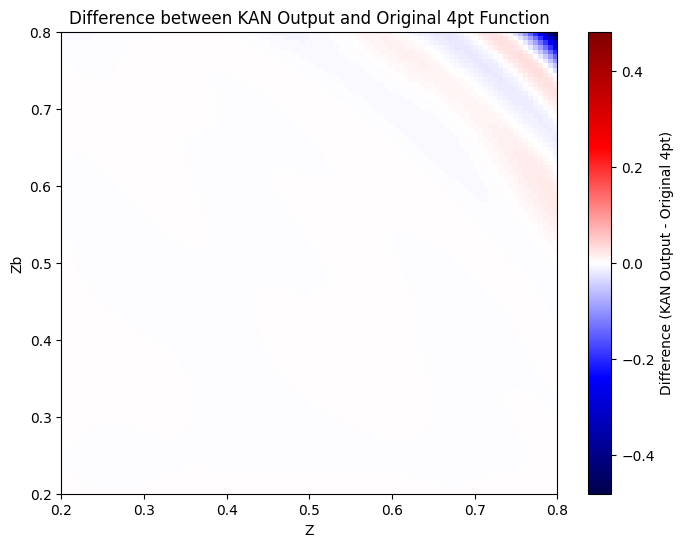

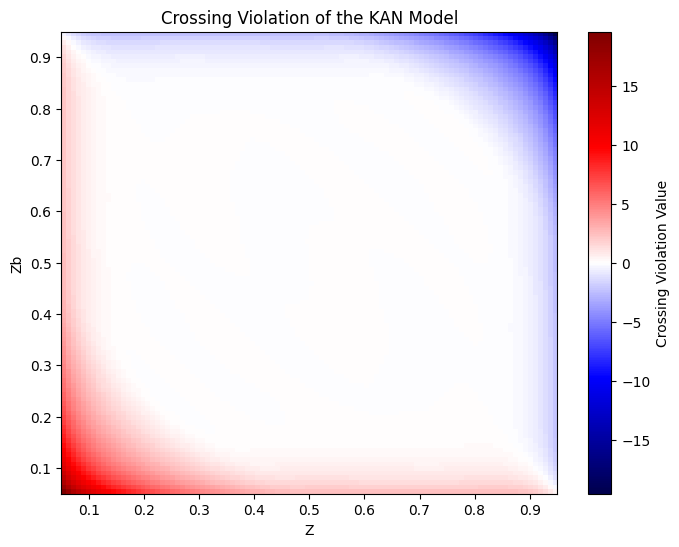

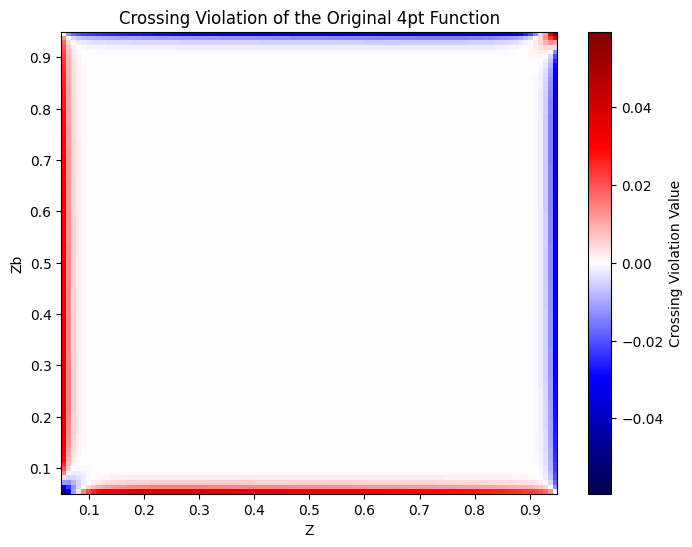

Mean Squared Error on unseen data: 9.083527e-05


9.083527402253821e-05

In [63]:
model4l0, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model4l,
        num_epochs=1000, weight_a=1.0, weight_b=0.0, device=device
    )



    # Plot results
plot_results(model4l, phi4pt_func, device)
plot_crossing_violation(model4l, phi4pt_func, Delta_phi, device)
evaluate_model(model4l, phi4pt_func, device, num_points=1000)

Training:   0%|          | 1/1000 [00:00<03:21,  4.97it/s]

Epoch 0: Total Loss = 0.158449, Loss A = 0.000015, Loss B = 158.433380


Training:  10%|█         | 101/1000 [00:22<03:07,  4.80it/s]

Epoch 100: Total Loss = 0.005954, Loss A = 0.001787, Loss B = 4.166979


Training:  20%|██        | 201/1000 [00:43<02:48,  4.74it/s]

Epoch 200: Total Loss = 0.001769, Loss A = 0.000633, Loss B = 1.135433


Training:  30%|███       | 301/1000 [01:07<03:29,  3.34it/s]

Epoch 300: Total Loss = 0.001149, Loss A = 0.000432, Loss B = 0.717399


Training:  40%|████      | 401/1000 [01:28<02:06,  4.74it/s]

Epoch 400: Total Loss = 0.000789, Loss A = 0.000293, Loss B = 0.495837


Training:  50%|█████     | 501/1000 [01:50<01:50,  4.52it/s]

Epoch 500: Total Loss = 0.000572, Loss A = 0.000229, Loss B = 0.343356


Training:  60%|██████    | 601/1000 [02:12<01:38,  4.04it/s]

Epoch 600: Total Loss = 0.000399, Loss A = 0.000143, Loss B = 0.256096


Training:  70%|███████   | 702/1000 [02:38<00:57,  5.15it/s]

Epoch 700: Total Loss = 0.000331, Loss A = 0.000127, Loss B = 0.204078


Training:  80%|████████  | 802/1000 [02:58<00:37,  5.26it/s]

Epoch 800: Total Loss = 0.000243, Loss A = 0.000073, Loss B = 0.169644


Training:  90%|█████████ | 902/1000 [06:29<00:31,  3.07it/s]  

Epoch 900: Total Loss = 0.000195, Loss A = 0.000063, Loss B = 0.132067


Training: 100%|██████████| 1000/1000 [15:12<00:00,  1.10it/s]  


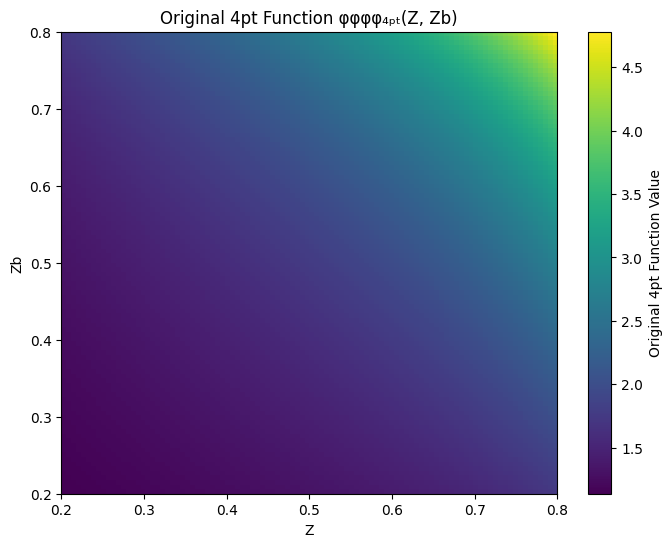

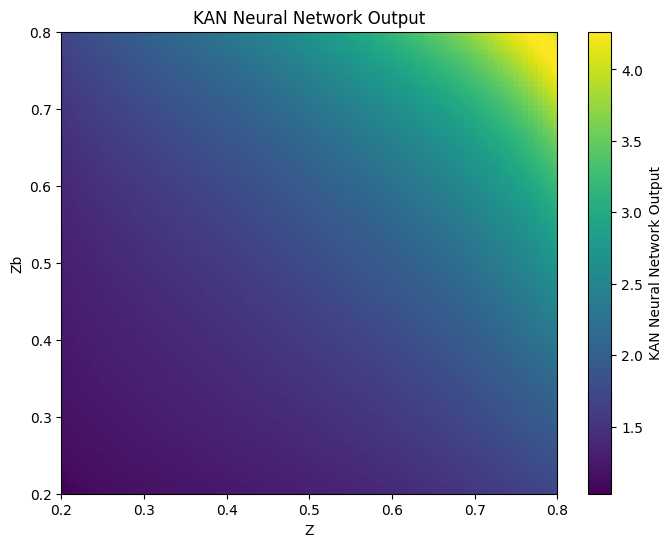

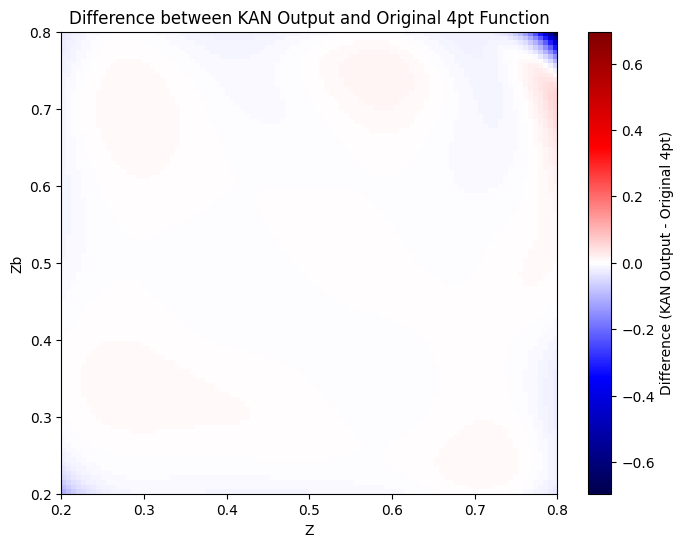

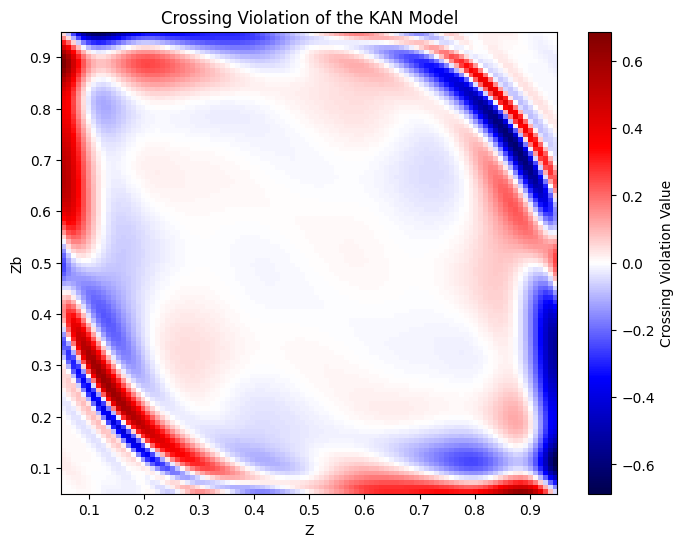

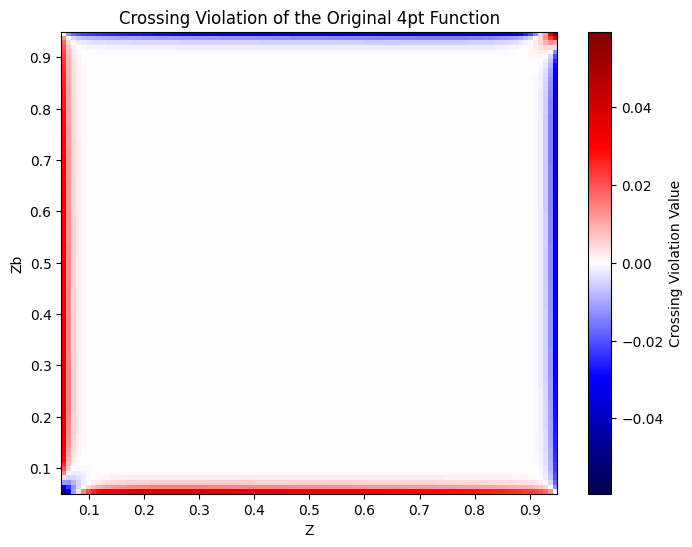

Mean Squared Error on unseen data: 1.137716e-04


0.00011377155897207558

In [64]:
model4l1, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model4l0,
        num_epochs=1000, weight_a=1.0, weight_b=0.001, device=device
    )



    # Plot results
plot_results(model4l1, phi4pt_func, device)
plot_crossing_violation(model4l1, phi4pt_func, Delta_phi, device)
evaluate_model(model4l1, phi4pt_func, device, num_points=1000)

Training:   0%|          | 1/1000 [00:00<03:54,  4.25it/s]

Epoch 0: Total Loss = 0.000504, Loss A = 0.000372, Loss B = 0.131799


Training:  10%|█         | 101/1000 [00:24<03:54,  3.84it/s]

Epoch 100: Total Loss = 0.000154, Loss A = 0.000063, Loss B = 0.091282


Training:  20%|██        | 201/1000 [00:48<03:18,  4.02it/s]

Epoch 200: Total Loss = 0.000113, Loss A = 0.000041, Loss B = 0.072060


Training:  30%|███       | 301/1000 [01:13<02:53,  4.02it/s]

Epoch 300: Total Loss = 0.000090, Loss A = 0.000030, Loss B = 0.059416


Training:  40%|████      | 401/1000 [01:38<02:18,  4.34it/s]

Epoch 400: Total Loss = 0.000072, Loss A = 0.000024, Loss B = 0.048486


Training:  50%|█████     | 501/1000 [02:02<01:56,  4.28it/s]

Epoch 500: Total Loss = 0.000058, Loss A = 0.000019, Loss B = 0.039088


Training:  60%|██████    | 601/1000 [02:26<01:36,  4.14it/s]

Epoch 600: Total Loss = 0.000047, Loss A = 0.000016, Loss B = 0.031692


Training:  70%|███████   | 701/1000 [02:54<01:09,  4.30it/s]

Epoch 700: Total Loss = 0.000039, Loss A = 0.000013, Loss B = 0.026112


Training:  80%|████████  | 801/1000 [03:22<00:40,  4.95it/s]

Epoch 800: Total Loss = 0.000033, Loss A = 0.000011, Loss B = 0.021926


Training:  90%|█████████ | 901/1000 [03:50<00:25,  3.84it/s]

Epoch 900: Total Loss = 0.000029, Loss A = 0.000010, Loss B = 0.018722


Training: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]


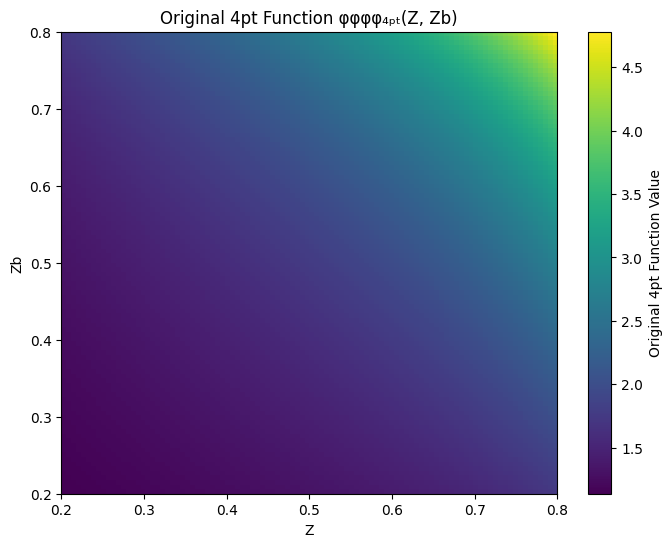

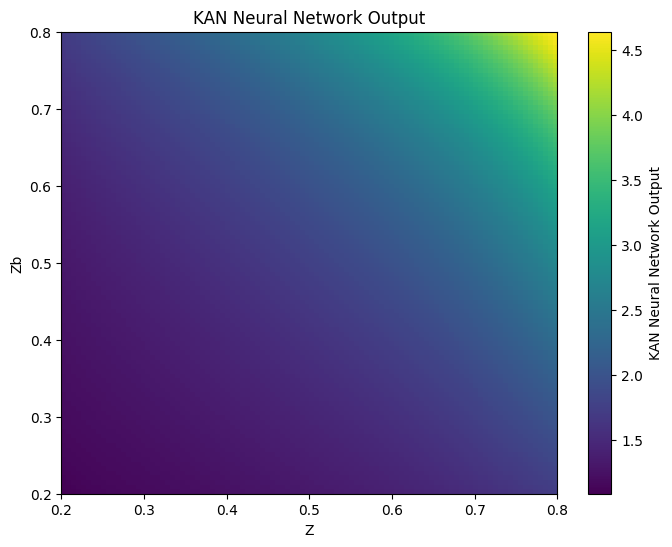

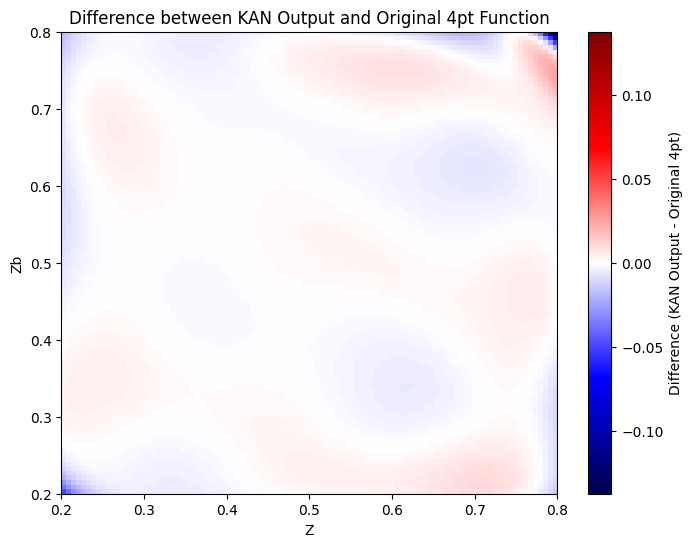

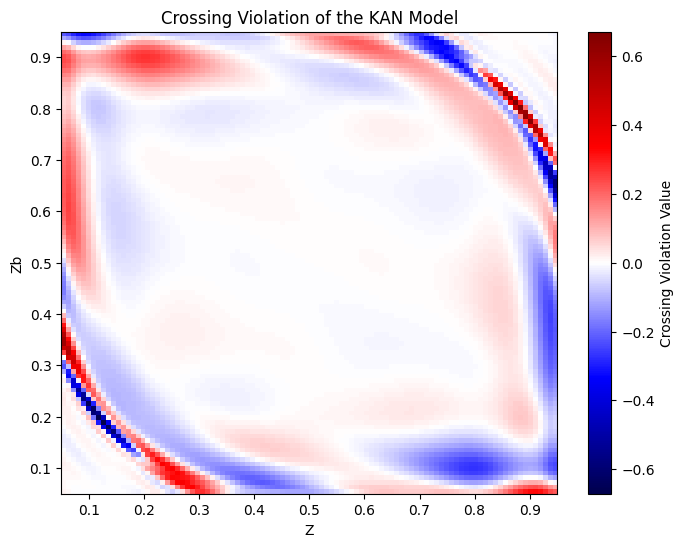

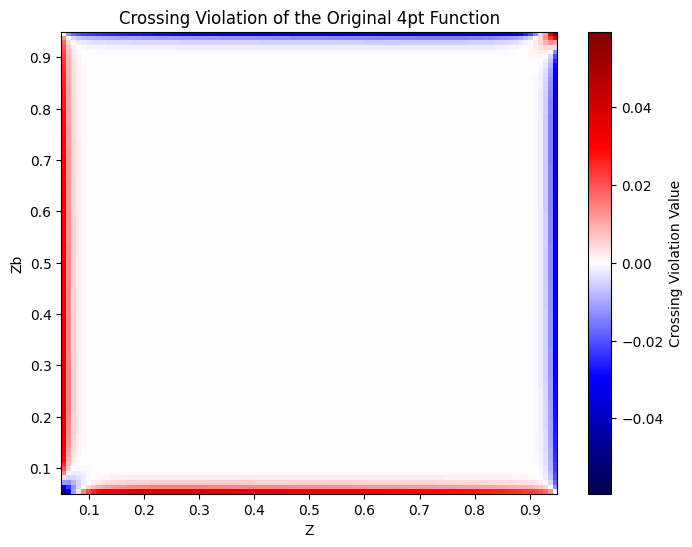

Mean Squared Error on unseen data: 1.088080e-05


1.0880804438784253e-05

In [65]:
model4l2, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model4l1,
        num_epochs=1000, weight_a=1.0, weight_b=0.001, device=device
    )



    # Plot results
plot_results(model4l2, phi4pt_func, device)
plot_crossing_violation(model4l2, phi4pt_func, Delta_phi, device)
evaluate_model(model4l2, phi4pt_func, device, num_points=1000)

Training:   0%|          | 1/1000 [00:00<05:55,  2.81it/s]

Epoch 0: Total Loss = 0.000094, Loss A = 0.000014, Loss B = 0.015896


Training:  10%|█         | 101/1000 [00:23<03:17,  4.55it/s]

Epoch 100: Total Loss = 0.000070, Loss A = 0.000015, Loss B = 0.010947


Training:  20%|██        | 201/1000 [00:45<04:14,  3.14it/s]

Epoch 200: Total Loss = 0.000061, Loss A = 0.000014, Loss B = 0.009420


Training:  30%|███       | 301/1000 [01:07<02:35,  4.51it/s]

Epoch 300: Total Loss = 0.000055, Loss A = 0.000013, Loss B = 0.008437


Training:  40%|████      | 401/1000 [01:32<02:11,  4.57it/s]

Epoch 400: Total Loss = 0.000051, Loss A = 0.000012, Loss B = 0.007711


Training:  50%|█████     | 501/1000 [01:56<01:44,  4.79it/s]

Epoch 500: Total Loss = 0.000047, Loss A = 0.000012, Loss B = 0.007100


Training:  60%|██████    | 601/1000 [02:18<01:20,  4.98it/s]

Epoch 600: Total Loss = 0.000044, Loss A = 0.000011, Loss B = 0.006556


Training:  70%|███████   | 701/1000 [02:40<01:13,  4.06it/s]

Epoch 700: Total Loss = 0.000041, Loss A = 0.000010, Loss B = 0.006062


Training:  80%|████████  | 801/1000 [03:06<00:46,  4.24it/s]

Epoch 800: Total Loss = 0.000038, Loss A = 0.000010, Loss B = 0.005611


Training:  90%|█████████ | 901/1000 [03:30<00:21,  4.70it/s]

Epoch 900: Total Loss = 0.000035, Loss A = 0.000009, Loss B = 0.005196


Training: 100%|██████████| 1000/1000 [04:00<00:00,  4.16it/s]


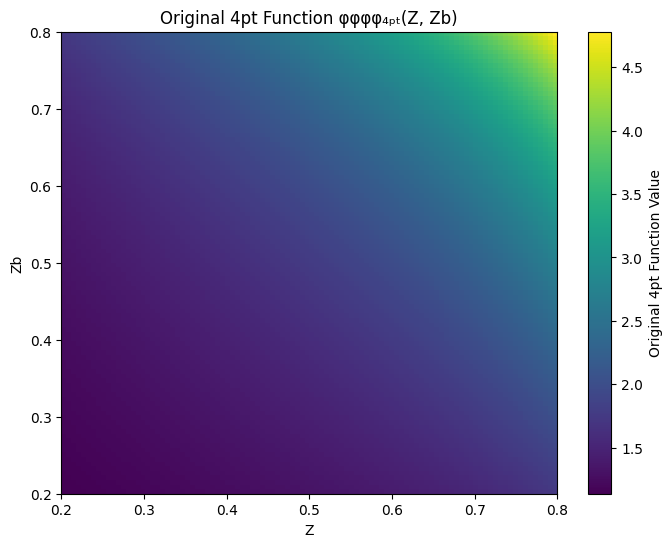

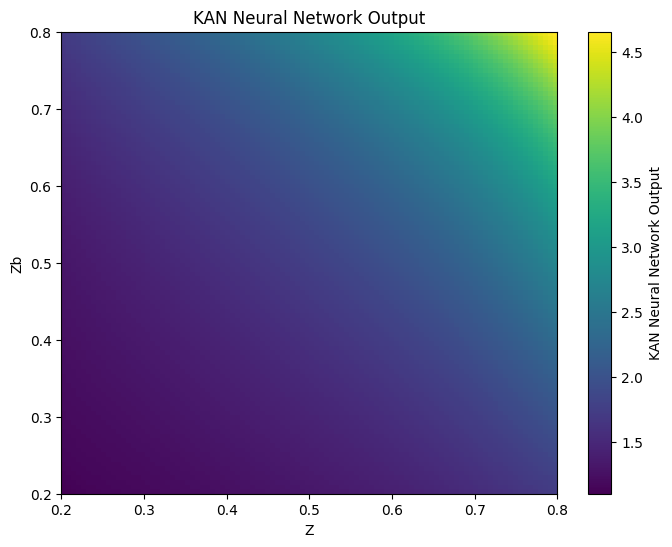

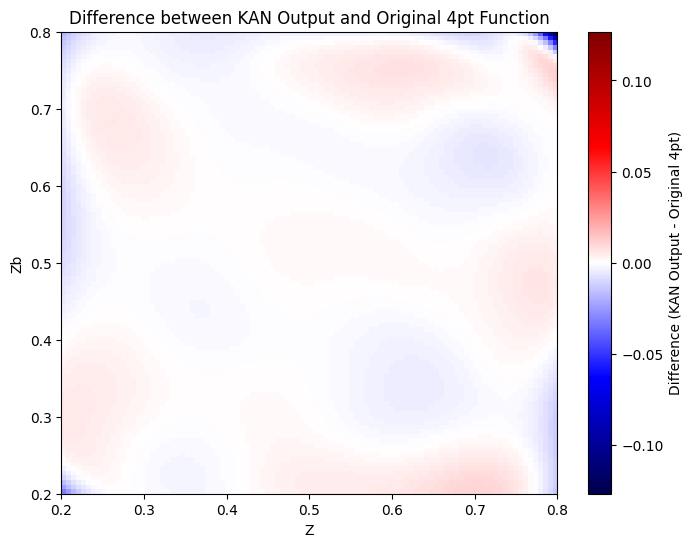

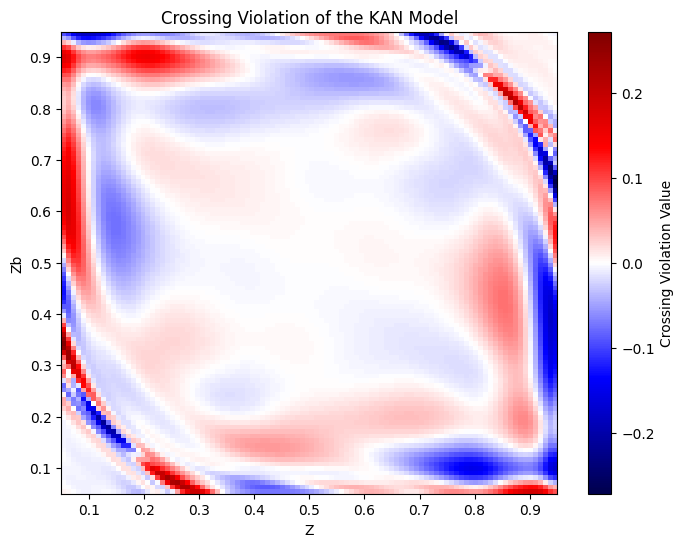

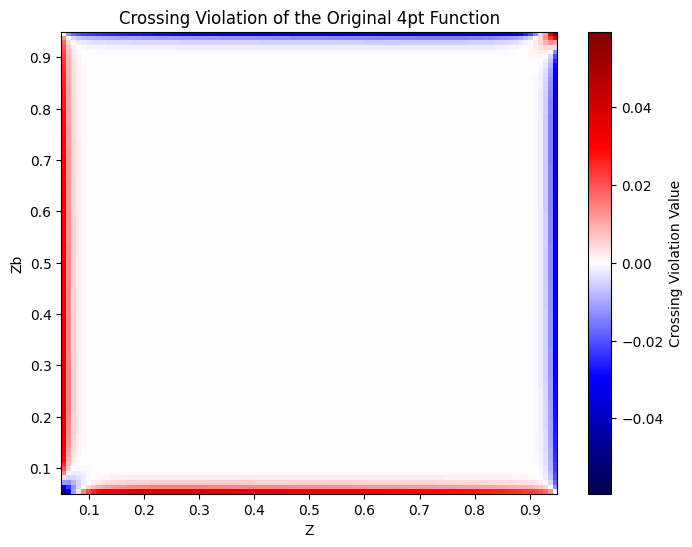

Mean Squared Error on unseen data: 8.491544e-06


8.491543667332735e-06

In [66]:
model4l3, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model4l2,
        num_epochs=1000, weight_a=1.0, weight_b=0.005, device=device
    )



    # Plot results
plot_results(model4l3, phi4pt_func, device)
plot_crossing_violation(model4l3, phi4pt_func, Delta_phi, device)
evaluate_model(model4l3, phi4pt_func, device, num_points=1000)

Training:   0%|          | 2/1000 [00:00<03:32,  4.70it/s]

Epoch 0: Total Loss = 0.000105, Loss A = 0.000008, Loss B = 0.096614


Training:  10%|█         | 101/1000 [00:24<03:31,  4.25it/s]

Epoch 100: Total Loss = 0.000044, Loss A = 0.000006, Loss B = 0.038001


Training:  20%|██        | 201/1000 [00:49<03:45,  3.55it/s]

Epoch 200: Total Loss = 0.000035, Loss A = 0.000005, Loss B = 0.030103


Training:  30%|███       | 301/1000 [01:13<02:28,  4.72it/s]

Epoch 300: Total Loss = 0.000030, Loss A = 0.000005, Loss B = 0.025419


Training:  40%|████      | 401/1000 [01:36<02:19,  4.29it/s]

Epoch 400: Total Loss = 0.000027, Loss A = 0.000005, Loss B = 0.022166


Training:  50%|█████     | 502/1000 [01:58<01:39,  5.02it/s]

Epoch 500: Total Loss = 0.000025, Loss A = 0.000005, Loss B = 0.020014


Training:  60%|██████    | 602/1000 [02:18<01:17,  5.14it/s]

Epoch 600: Total Loss = 0.000023, Loss A = 0.000004, Loss B = 0.018630


Training:  70%|███████   | 702/1000 [02:39<00:57,  5.18it/s]

Epoch 700: Total Loss = 0.000022, Loss A = 0.000004, Loss B = 0.017597


Training:  80%|████████  | 802/1000 [02:58<00:37,  5.24it/s]

Epoch 800: Total Loss = 0.000021, Loss A = 0.000004, Loss B = 0.016709


Training:  90%|█████████ | 902/1000 [03:18<00:18,  5.20it/s]

Epoch 900: Total Loss = 0.000019, Loss A = 0.000004, Loss B = 0.015882


Training: 100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]


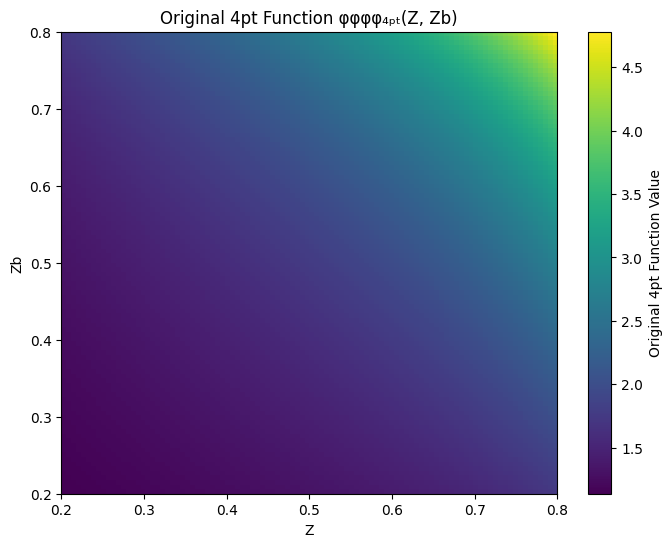

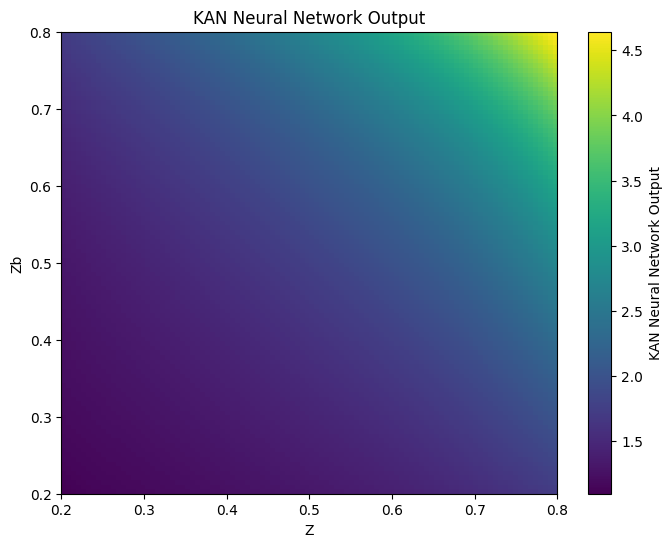

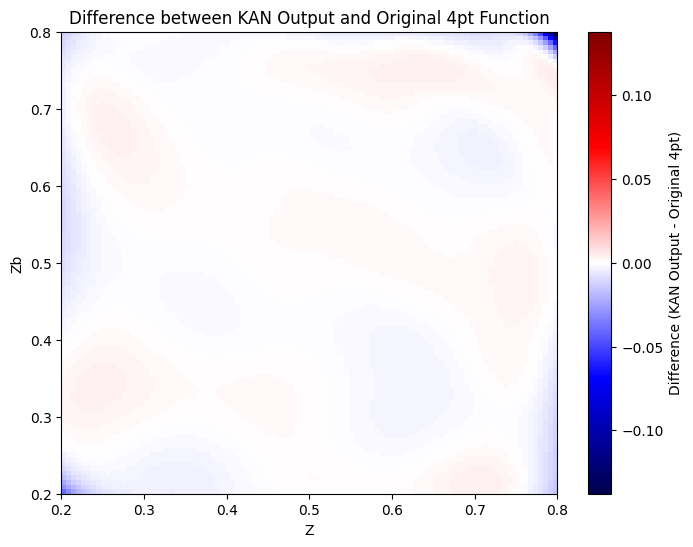

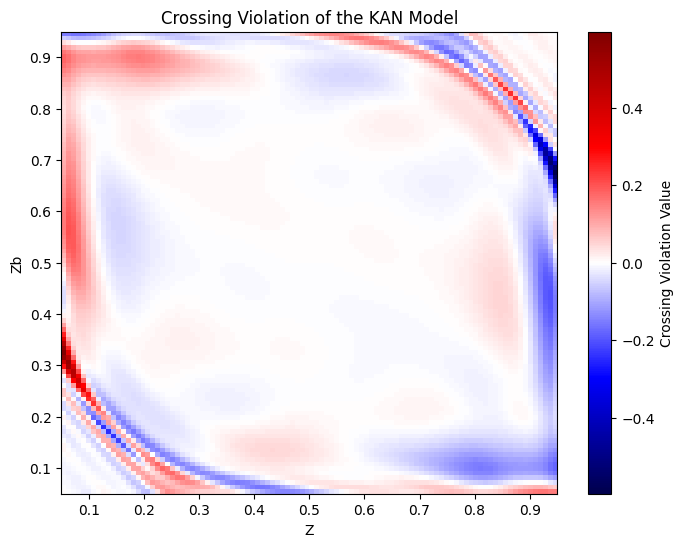

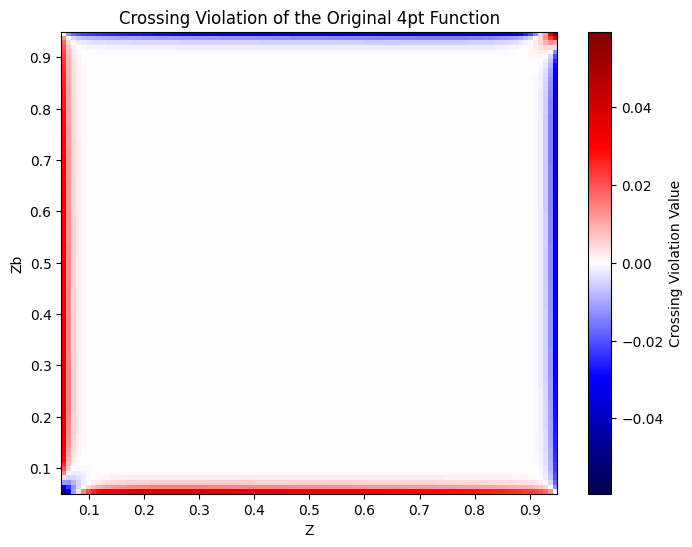

Mean Squared Error on unseen data: 7.478902e-06


7.478902261937037e-06

In [67]:
model4l4, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model4l3,
        num_epochs=1000, weight_a=1.0, weight_b=0.001, device=device
    )



    # Plot results
plot_results(model4l4, phi4pt_func, device)
plot_crossing_violation(model4l4, phi4pt_func, Delta_phi, device)
evaluate_model(model4l4, phi4pt_func, device, num_points=1000)

In [68]:
# Create powers of x list
lib = ['x'] + ['x^' + str(i) for i in range(2, 6)]  # Starts from x^2 to x^35

# Add the other functions
additional_funcs = ['exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']

# Combine powers of x with the additional functions
#lib.extend(additional_funcs)
model4l4.auto_symbolic(lib=lib)
model4l4.symbolic_formula()

fixing (0,0,0) with x, r2=0.8086287975311279, c=1
fixing (0,0,1) with x, r2=0.9863659143447876, c=1
fixing (0,0,2) with x, r2=0.9761908650398254, c=1
fixing (0,0,3) with x, r2=0.9648199677467346, c=1
fixing (0,1,0) with x, r2=0.364737331867218, c=1
fixing (0,1,1) with x^2, r2=0.9953539371490479, c=2
fixing (0,1,2) with x, r2=0.9885556697845459, c=1
fixing (0,1,3) with x, r2=0.9981443881988525, c=1
fixing (1,0,0) with x, r2=0.9999034404754639, c=1
fixing (1,0,1) with x, r2=0.9732198715209961, c=1
fixing (1,0,2) with x^2, r2=0.9999647736549377, c=2
fixing (1,0,3) with x, r2=0.9656221270561218, c=1
fixing (1,0,4) with x, r2=0.11308259516954422, c=1
fixing (1,0,5) with x, r2=0.9084808826446533, c=1
fixing (1,1,0) with x, r2=0.9792046546936035, c=1
fixing (1,1,1) with x, r2=0.02355809323489666, c=1
fixing (1,1,2) with x, r2=0.9895106554031372, c=1
fixing (1,1,3) with x, r2=0.5730690956115723, c=1
fixing (1,1,4) with x^2, r2=0.9999524354934692, c=2
fixing (1,1,5) with x, r2=0.000153946777572

([0.283236910448356*x_1 + 0.248974621025196*x_2 - 0.324790968720019*(0.635555738318801 - x_2)**2 - 0.0166009687706112*(-0.477756350301992*x_1 + x_2 - 0.738800827669846)**2 - 0.0216035603897526*(-0.477756350301992*x_1 + x_2 - 0.105851469162519)**2 + 0.0578538106424299*(-0.477756350301992*x_1 + x_2 + 0.154901731635793)**2 + 0.0889486325686982*(-0.477756350301992*x_1 + x_2 - 0.21477918194964)**2 + 0.221496979369478*(-0.460764879197646*x_1 + (0.635555738318801 - x_2)**2 - 0.499878419522378)**2 - 0.00913963198553417*(-0.20556433578013*x_1 - 0.180734082130972*x_2 + 1)**2 - 0.0130130292377398*(0.98094958479326*x_1 + x_2 - 0.66364770719169)**2 + 0.116478469608415*(0.98094958479326*x_1 + x_2 - 0.558299711814594)**2 - 0.00400087290492496*(-x_1 - 0.153578693087713*x_2 + 0.862247598060656*(0.635555738318801 - x_2)**2 + 0.203628289979411*(-0.20556433578013*x_1 - 0.180734082130972*x_2 + 1)**2 + 0.225791862815333)**2 + 0.0229296231568865*(-x_1 - 0.153578693087712*x_2 + 0.862247598060656*(0.6355557383

In [69]:
print_symbolic(model4l4)

0.283236910448356*x1 + 0.248974621025196*x2 - 0.324790968720019*(0.635555738318801 - x2)^2 - 0.0166009687706112*(-0.477756350301992*x1 + x2 - 0.738800827669846)^2 - 0.0216035603897526*(-0.477756350301992*x1 + x2 - 0.105851469162519)^2 + 0.0578538106424299*(-0.477756350301992*x1 + x2 + 0.154901731635793)^2 + 0.0889486325686982*(-0.477756350301992*x1 + x2 - 0.21477918194964)^2 + 0.221496979369478*(-0.460764879197646*x1 + (0.635555738318801 - x2)^2 - 0.499878419522378)^2 - 0.00913963198553417*(-0.20556433578013*x1 - 0.180734082130972*x2 + 1)^2 - 0.0130130292377398*(0.98094958479326*x1 + x2 - 0.66364770719169)^2 + 0.116478469608415*(0.98094958479326*x1 + x2 - 0.558299711814594)^2 - 0.00400087290492496*(-x1 - 0.153578693087713*x2 + 0.862247598060656*(0.635555738318801 - x2)^2 + 0.203628289979411*(-0.20556433578013*x1 - 0.180734082130972*x2 + 1)^2 + 0.225791862815333)^2 + 0.0229296231568865*(-x1 - 0.153578693087712*x2 + 0.862247598060656*(0.635555738318801 - x2)^2 + 0.203628289979411*(-0.205

Training:   0%|          | 1/1000 [00:00<04:19,  3.85it/s]

Epoch 0: Total Loss = 0.148127, Loss A = 0.032746, Loss B = 115.381546


Training:  10%|█         | 101/1000 [00:23<03:16,  4.57it/s]

Epoch 100: Total Loss = 0.062085, Loss A = 0.034481, Loss B = 27.603983


Training:  20%|██        | 201/1000 [00:45<02:53,  4.62it/s]

Epoch 200: Total Loss = 0.034621, Loss A = 0.015651, Loss B = 18.969479


Training:  30%|███       | 301/1000 [01:07<02:33,  4.55it/s]

Epoch 300: Total Loss = 0.013225, Loss A = 0.006818, Loss B = 6.406338


Training:  40%|████      | 401/1000 [01:31<02:19,  4.29it/s]

Epoch 400: Total Loss = 0.007851, Loss A = 0.003804, Loss B = 4.047292


Training:  50%|█████     | 501/1000 [01:55<03:20,  2.49it/s]

Epoch 500: Total Loss = 0.007921, Loss A = 0.004497, Loss B = 3.424228


Training:  60%|██████    | 601/1000 [02:18<01:30,  4.42it/s]

Epoch 600: Total Loss = 0.012625, Loss A = 0.006612, Loss B = 6.012821


Training:  70%|███████   | 701/1000 [02:40<01:04,  4.62it/s]

Epoch 700: Total Loss = 0.007784, Loss A = 0.004665, Loss B = 3.118267


Training:  80%|████████  | 801/1000 [03:02<00:55,  3.60it/s]

Epoch 800: Total Loss = 0.005514, Loss A = 0.002718, Loss B = 2.795412


Training:  90%|█████████ | 901/1000 [03:25<00:21,  4.63it/s]

Epoch 900: Total Loss = 0.005902, Loss A = 0.003058, Loss B = 2.844440


Training: 100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s]


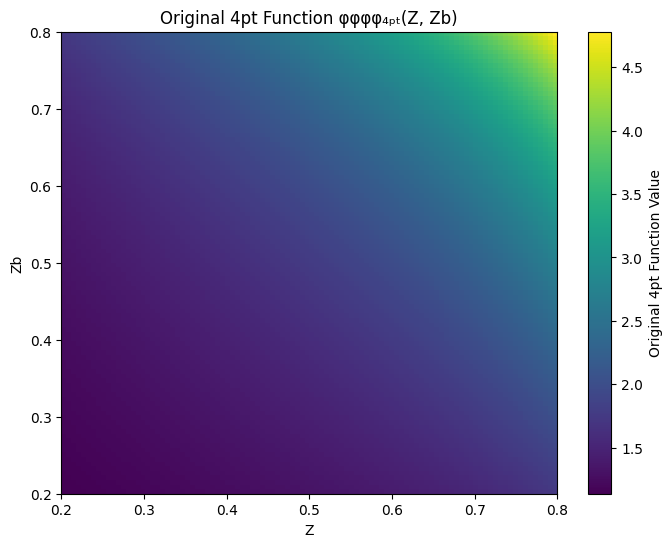

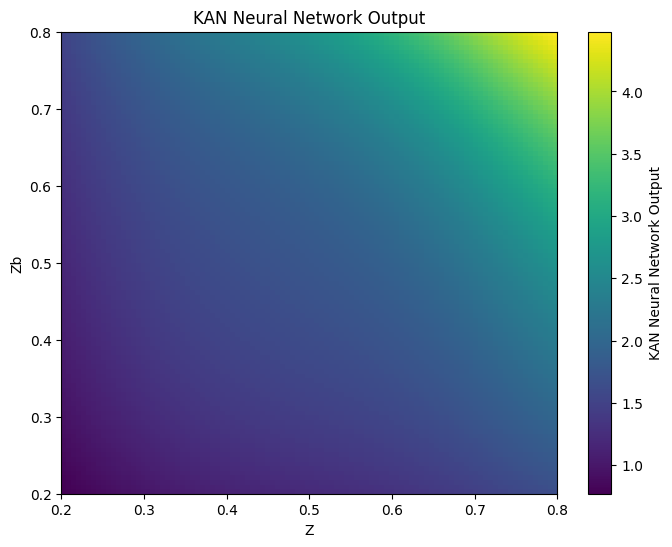

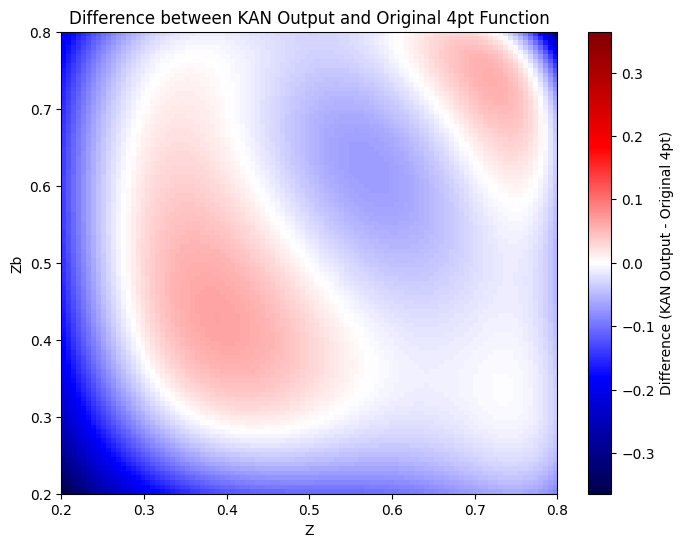

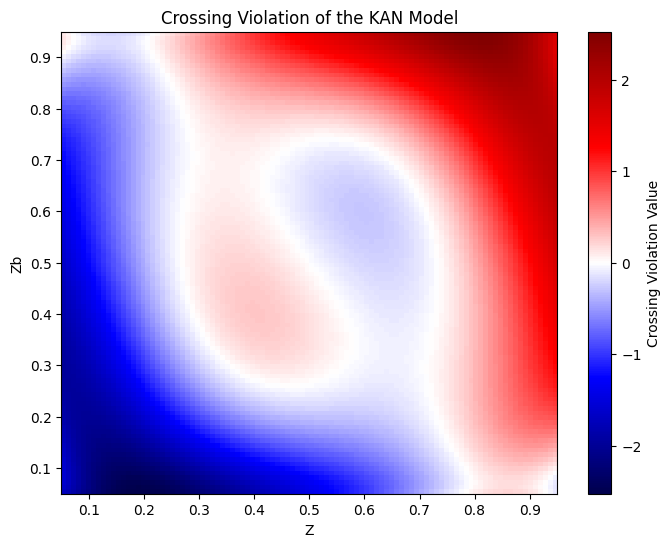

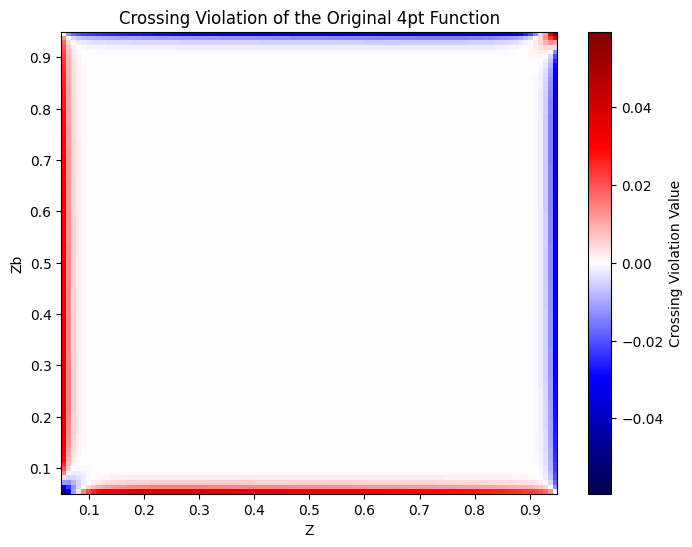

Mean Squared Error on unseen data: 3.740404e-03


0.003740403801202774

In [70]:
model4ls, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model4l4,
        num_epochs=1000, weight_a=1.0, weight_b=0.001, device=device
    )



    # Plot results
plot_results(model4ls, phi4pt_func, device)
plot_crossing_violation(model4ls, phi4pt_func, Delta_phi, device)
evaluate_model(model4ls, phi4pt_func, device, num_points=1000)

Training:   0%|          | 1/10000 [00:00<33:42,  4.94it/s]

Epoch 0: Total Loss = 0.006182, Loss A = 0.001548, Loss B = 0.463416


Training:  10%|█         | 1001/10000 [03:31<30:50,  4.86it/s]

Epoch 1000: Total Loss = 0.002419, Loss A = 0.001361, Loss B = 0.105807


Training:  20%|██        | 2002/10000 [07:02<27:23,  4.87it/s]

Epoch 2000: Total Loss = 0.001862, Loss A = 0.001129, Loss B = 0.073307


Training:  30%|███       | 3002/10000 [10:32<22:11,  5.25it/s]

Epoch 3000: Total Loss = 0.001551, Loss A = 0.000969, Loss B = 0.058242


Training:  40%|████      | 4002/10000 [13:12<15:11,  6.58it/s]

Epoch 4000: Total Loss = 0.001263, Loss A = 0.000837, Loss B = 0.042683


Training:  50%|█████     | 5002/10000 [15:50<12:38,  6.59it/s]

Epoch 5000: Total Loss = 0.004838, Loss A = 0.000787, Loss B = 0.405102


Training:  60%|██████    | 6002/10000 [18:25<10:07,  6.58it/s]

Epoch 6000: Total Loss = 2.148411, Loss A = 0.104896, Loss B = 204.351562


Training:  70%|███████   | 7002/10000 [21:00<07:35,  6.58it/s]

Epoch 7000: Total Loss = 0.052654, Loss A = 0.034988, Loss B = 1.766555


Training:  80%|████████  | 8002/10000 [23:34<05:08,  6.47it/s]

Epoch 8000: Total Loss = 0.043136, Loss A = 0.019438, Loss B = 2.369861


Training:  90%|█████████ | 9002/10000 [26:09<02:32,  6.54it/s]

Epoch 9000: Total Loss = 0.033154, Loss A = 0.009544, Loss B = 2.360957


Training: 100%|██████████| 10000/10000 [28:43<00:00,  5.80it/s]


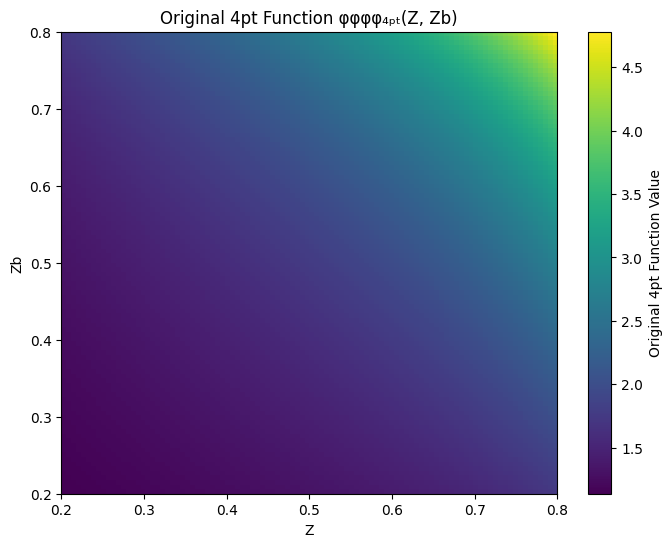

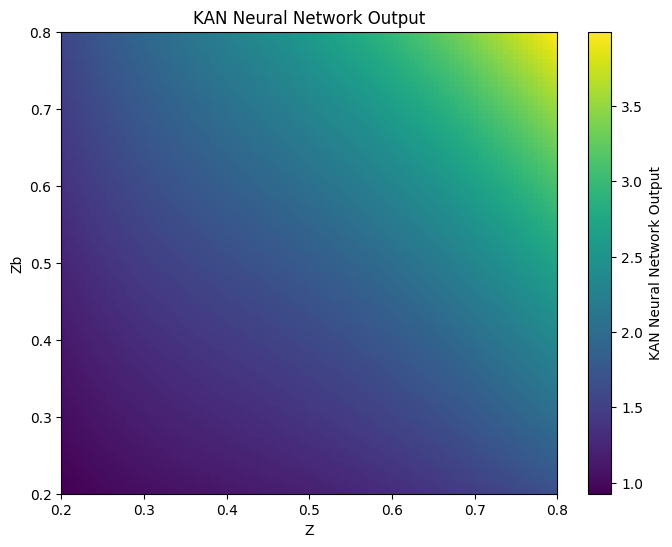

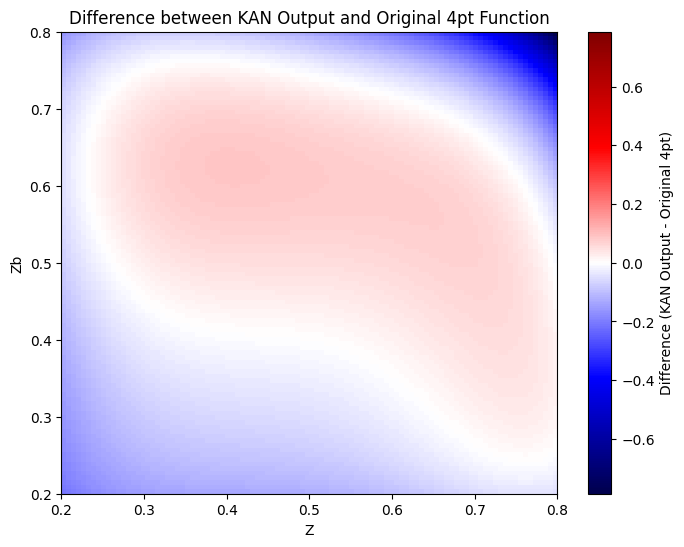

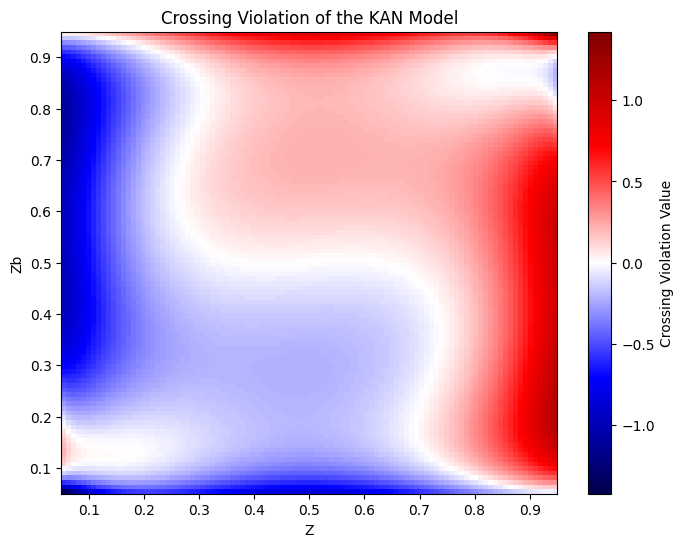

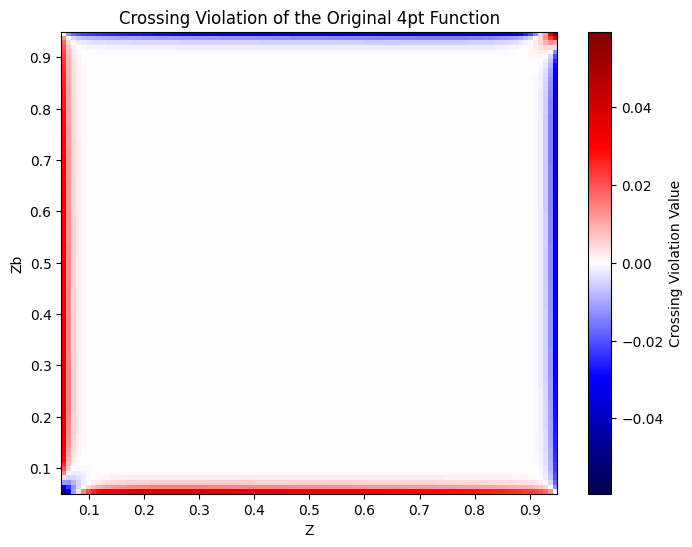

Mean Squared Error on unseen data: 7.531892e-03


0.007531891576945782

In [74]:
model4ls, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model4ls,
        num_epochs=10000, weight_a=1.0, weight_b=0.01, device=device
    )



    # Plot results
plot_results(model4ls, phi4pt_func, device)
plot_crossing_violation(model4ls, phi4pt_func, Delta_phi, device)
evaluate_model(model4ls, phi4pt_func, device, num_points=10000)